In [13]:
!pip uninstall ocean-lib -y

!pip install wheel
!pip install --pre ocean-lib

Found existing installation: ocean-lib 2.0.0a4
Uninstalling ocean-lib-2.0.0a4:
  Successfully uninstalled ocean-lib-2.0.0a4
  Using cached ocean_lib-2.0.0a4-py2.py3-none-any.whl (63 kB)


In [95]:
!pip install colorama networkx
!pip install pandas numpy requests prophet 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.1 MB/s eta 0:00:000:00:01m eta 0:00:01


In [288]:
# imports
import datetime
from datetime import timezone
import os
from pathlib import Path
import time
import math

import random
import pickle
import gc
from tqdm import tqdm

import brownie.network as b_network # accounts, connect, disconnect
from brownie.network.account import LocalAccount
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from web3.main import Web3

# from ocean_lib.example_config import ExampleConfig
from ocean_lib.ocean.ocean import Ocean
from ocean_lib.web3_internal.utils import connect_to_network# Create models

In [2]:
#Data Visualization Packages:
#Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
#Colorama
from colorama import Fore, Back, Style # For text colors
y_= Fore.CYAN
m_= Fore.WHITE

#NetworkX
import networkx as nx
import plotly.graph_objects as go #To construct network graphs

In [29]:
# fit a linear model (Open sourced Facebook's Prophet model: https://facebook.github.io/prophet/)
# As the data is subdaily, the model will fit daily seasonality
from prophet import Prophet

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [176]:

# statistics and econometrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [ ]:
!pip install bokeh

In [171]:

from bokeh.plotting import figure, show
from bokeh.models import Span
from bokeh.io import output_notebook
from bokeh.models import Range1d
from bokeh.models import ColumnDataSource as cds
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter


In [43]:

from sklearn.multioutput import RegressorChain

In [4]:
ocean = create_ocean_instance()
alice_wallet = create_alice_wallet(ocean) #you're Alice


# helper functions: setup
def create_ocean_instance() -> Ocean:
    config = {'NETWORK_NAME': 'polygon', 'METADATA_CACHE_URI': 'https://v4.aquarius.oceanprotocol.com', 'PROVIDER_URL': 'https://v4.provider.polygon.oceanprotocol.com', 'DOWNLOADS_PATH': 'consume-downloads', 'BLOCK_CONFIRMATIONS': 1}#ExampleConfig.get_config("polygon")  # points to Polygon mainnet
    config["BLOCK_CONFIRMATIONS"] = 1  # faster
    print(config)
    b_network.connect("polygon-main")
    print(f"conneceted: {b_network.is_connected()}")
    print(f"active: {b_network.show_active()}")
    connect_to_network("polygon-main")
    ocean = Ocean(config)
    return ocean


def create_alice_wallet(ocean: Ocean) -> LocalAccount:
    config = ocean.config_dict
    alice_private_key = os.getenv('REMOTE_TEST_PRIVATE_KEY1')
    alice_wallet = b_network.accounts.add(alice_private_key)
    bal = Web3.fromWei(b_network.accounts.at(alice_wallet.address).balance(), 'ether')
    print(f"alice_wallet.address={alice_wallet.address}. bal={bal}")
    assert bal > 0, f"Alice needs MATIC"
    return alice_wallet


# helper functions: time
def to_unixtime(dt: datetime.datetime):
    # must account for timezone, otherwise it's off
    ut = dt.replace(tzinfo=timezone.utc).timestamp()
    dt2 = datetime.datetime.utcfromtimestamp(ut)  # to_datetime() approach
    assert dt2 == dt, f"dt: {dt}, dt2: {dt2}"
    return ut


def to_unixtimes(dts: list) -> list:
    return [to_unixtime(dt) for dt in dts]


def to_datetime(ut) -> datetime.datetime:
    dt = datetime.datetime.utcfromtimestamp(ut)
    ut2 = dt.replace(tzinfo=timezone.utc).timestamp()  # to_unixtime() approach
    assert ut2 == ut, f"ut: {ut}, ut2: {ut2}"
    return dt


def to_datetimes(uts: list) -> list:
    return [to_datetime(ut) for ut in uts]


def round_to_nearest_hour(dt: datetime.datetime) -> datetime.datetime:
    return (dt.replace(second=0, microsecond=0, minute=0, hour=dt.hour)
            + datetime.timedelta(hours=dt.minute//30))


def pretty_time(dt: datetime.datetime) -> str:
    return dt.strftime('%Y/%m/%d, %H:%M:%S')


def print_datetime_info(descr: str, uts: list):
    dts = to_datetimes(uts)
    print(descr + ":")
    print(f"  starts on: {pretty_time(dts[0])}")
    print(f"    ends on: {pretty_time(dts[-1])}")
    print(f"  {len(dts)} datapoints")
    print(f"  time interval between datapoints: {(dts[1]-dts[0])}")


def target_12h_unixtimes(start_dt: datetime.datetime) -> list:
    target_dts = [start_dt + datetime.timedelta(hours=h) for h in range(12)]
    target_uts = to_unixtimes(target_dts)
    return target_uts


# helper-functions: higher level
def load_from_ohlc_data(file_name: str) -> tuple:
    """Returns (list_of_unixtimes, list_of_close_prices)"""
    with open(file_name, "r") as file:
        data_str = file.read().rstrip().replace('"', '')
    x = eval(data_str)  # list of lists
    uts = [xi[0]/1000 for xi in x]
    vals = [xi[4] for xi in x]
    return (uts, vals)


def filter_to_target_uts(target_uts: list, unfiltered_uts: list, unfiltered_vals: list) -> list:
    """Return filtered_vals -- values at at the target timestamps"""
    filtered_vals = [None] * len(target_uts)
    for i, target_ut in enumerate(target_uts):
        time_diffs = np.abs(np.asarray(unfiltered_uts) - target_ut)
        tol_s = 1  # should always align within e.g. 1 second
        target_ut_s = pretty_time(to_datetime(target_ut))
        assert min(time_diffs) <= tol_s, \
            f"Unfiltered times is missing target time: {target_ut_s}"
        j = np.argmin(time_diffs)
        filtered_vals[i] = unfiltered_vals[j]
    return filtered_vals


# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))


def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_


# helpers: prediction performance
def calc_nmse(y, yhat) -> float:
    assert len(y) == len(yhat)
    mse_xy = np.sum(np.square(np.asarray(y) - np.asarray(yhat)))
    mse_x = np.sum(np.square(np.asarray(y)))
    nmse = mse_xy / mse_x
    return nmse


def plot_prices(cex_vals, pred_vals, last_x_hours):
    matplotlib.rcParams.update({'font.size': 22})
    x = [h for h in range(0, last_x_hours)]
    assert len(x) == len(cex_vals) == len(pred_vals)
    fig, ax = plt.subplots()
    ax.plot(x, cex_vals, '--', label="CEX values")
    ax.plot(x, pred_vals, '-', label="Pred. values")
    ax.legend(loc='lower right')
    plt.ylabel("ETH price")
    plt.xlabel("Hour")
    fig.set_size_inches(18, 18)
    plt.xticks(x)
    plt.show()

In [5]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(10,20))
#     sns.displot(x, ax=ax[0],color=c, kind="kde")
#     sns.displot(x, ax=ax[0],color=c, kind="hist")
#     sns.histplot(data=x, ax=ax[0],color=c)
    sns.kdeplot(data=x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x=x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x=x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

In [168]:
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

In [ ]:


from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))



In [6]:
import ccxt
import pandas as pd
import numpy as np
import requests

cex_x = ccxt.binance().fetch_ohlcv('ETH/USDT', '1h')

# create a Data Frame with two columns [date,eth-prices] with dates given in intervals of 1-hour
import pandas as pd
data = pd.DataFrame(cex_x, columns=['date', 'open', 'max', 'min', 'close', 'volume'])
data['date'] = pd.to_datetime(data['date'],unit='ms')

# Divide the data in training and testing set. Because the data has temporal structure, we split the data in two blocks, vs. selecting randomly.
# 90% of the data is used for training and 10 is used for testing
train_rate = 0.9
n = data.shape[0]
ntrain = int(np.floor(n*train_rate))
train_data = data.iloc[0:ntrain,:]
test_data = data.iloc[ntrain:,:]

# Create feature vectors
# - Define how many samples in the past are used to predict future values. 
# - This also defines the number of smaples to be predicted in the future.
max_lag = 12 

# Create feature vectors with 12 columns, each representing a time-lag from the current time point
# - That is: x(t-1), x(t-2)...x(t-12) for close and open values (different features could be grouped using the same logic)
full_train_close = pd.concat([train_data['close'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
full_train_open = pd.concat([train_data['open'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
# targets are multivariate, with the values of eth from 1 - 12 hours ahead of the curent time
y_train = full_train_close[max_lag:,:]
# train set is lagged with respect to the targets
x_train = np.concatenate((full_train_close[0:-max_lag,:],full_train_open[0:-max_lag,:]),axis=1)

# Repeat the feature vector creation as above for the test set
full_test_close = pd.concat([test_data['close'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
full_test_open = pd.concat([test_data['open'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
y_test = full_test_close[max_lag:,:]
x_test = np.concatenate((full_test_close[0:-max_lag,:],full_test_open[0:-max_lag,:]),axis=1)

In [50]:
# Create models
from sklearn.multioutput import RegressorChain
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

# regression using a base estimator and RegressionChain
def fit_and_predict_reg(base_model,x_train,y_train,x_test,y_test):
    chain = RegressorChain(base_estimator=base_model).fit(x_train, y_train)  
    yhat_test = chain.predict(x_test)
    return calc_nmse(y_test,yhat_test), yhat_test

# Neural network using Keras, 2 hidden layers with RELU activations, output layer with linear activations 
def fit_andpredict_fcnn(x_train,y_train,x_test,y_test):
    inputs = Input(shape=(x_train.shape[1],))
    x = Dense(128,activation='relu')(inputs)
    x = Dense(64,activation='relu')(x)
    outputs = Dense(12,activation='linear')(x)
    model = Model(inputs=inputs,outputs=outputs)
    # set compiling parameters
    model.compile( optimizer="adam", loss='mean_absolute_percentage_error',metrics=[])
    # Fit model
    model.fit(x_train,y_train,batch_size=100, epochs=500, validation_split=0.1, verbose=0)
    # predict
    yhat_test = model.predict(x_test)
    return calc_nmse(y_test,yhat_test), yhat_test

# multi-output linear regression
from sklearn.linear_model import LinearRegression 
linreg = LinearRegression()
linreg_error,yhat_test_lin = fit_and_predict_reg(linreg,x_train,y_train,x_test,y_test)

# multi-output random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
rfr = RandomForestRegressor(max_depth=10)
rfr_error,yhat_test_rfr = fit_and_predict_reg(rfr,x_train,y_train,x_test,y_test)

# multi-output support vector machines
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1000, epsilon=.1)
svr_error,yhat_test_svr = fit_and_predict_reg(svr,x_train,y_train,x_test,y_test)

# Dense NN
dnn_error,yhat_test_dnn = fit_andpredict_fcnn(x_train,y_train,x_test,y_test)




1/1 [==============================] - 0s 20ms/step


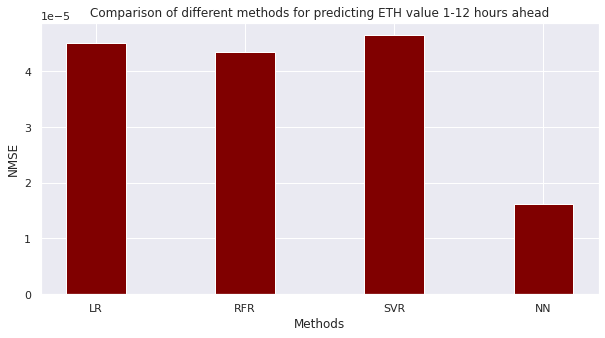

In [52]:
# Plot results

info = {'LR':linreg_error, 'RFR':rfr_error, 'SVR':svr_error,'NN':dnn_error}
methods = list(info.keys())
values = list(info.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(methods, values, color ='maroon', width = 0.4)
 
plt.xlabel("Methods")
plt.ylabel("NMSE")
plt.title("Comparison of different methods for predicting ETH value 1-12 hours ahead")
plt.show()

In [72]:
actual_close = [x[0] for x in y_test]
actual_yhat_test_lin = [x[0] for x in yhat_test_lin]
actual_yhat_test_rfr = [x[0] for x in yhat_test_rfr]
actual_yhat_test_svr = [x[0] for x in yhat_test_svr]
actual_yhat_test_dnn = [x[0] for x in yhat_test_dnn]
viz = [actual_close,actual_yhat_test_lin,actual_yhat_test_rfr,actual_yhat_test_svr,actual_yhat_test_dnn]

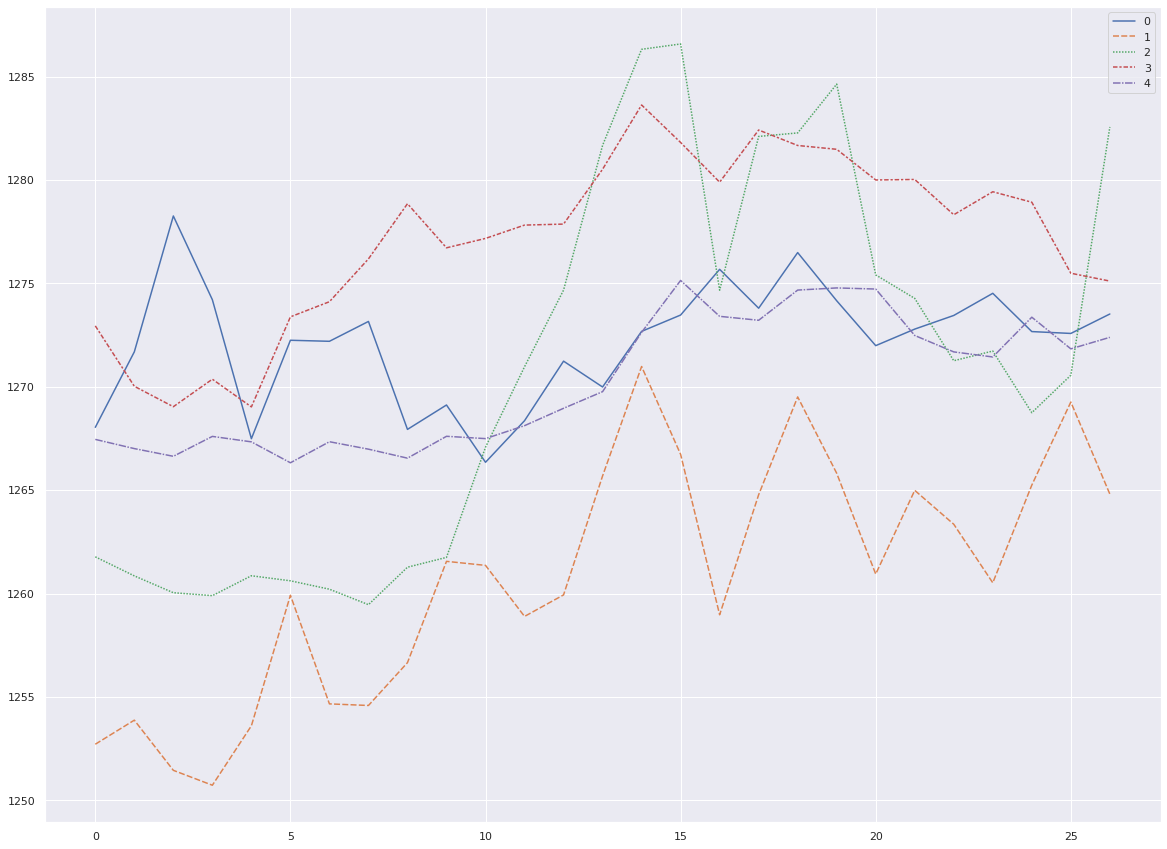

In [73]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
sns.lineplot(data=viz, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_lin, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_rfr, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_svr, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_dnn, ax=ax,legend="full")
plt.legend()
plt.show()

## Try prophet

In [218]:
import ccxt # can try predicting from the minute data?
ex = ccxt.binance()
from_ts = ex.parse8601('2022-05-21 00:00:00')
ohlcv_list = []
ohlcv = ex.fetch_ohlcv('ETH/USDT', '1h', since=from_ts, limit=1000)
# print(ohlcv)
ohlcv_list.extend(ohlcv)
# print(ohlcv_list)
while(True):
    from_ts = ohlcv_list[-1][0]
#     print("=" * 50)
#     print(ohlcv_list[:-5:-1])
#     print(from_ts)
    new_ohlcv = ex.fetch_ohlcv('ETH/USDT', '5m', since=from_ts, limit=1000)
#     print(f"len :{len(new_ohlcv)}")
#     print(new_ohlcv[-5:-1])
    ohlcv_list.extend(new_ohlcv)
#     print(ohlcv_list[-5:-1])
    if(len(new_ohlcv) < 1000):
        break
# cex_x = ex.fetch_ohlcv('ETH/USDT', '1h')
# print(cex_x)
cex_x = ohlcv_list
# print(cex_x)

allcex_uts = [xi[0]/1000 for xi in cex_x] # timestamps
allcex_vals = [xi[4] for xi in cex_x] # ETH prices

# # Extracts dates and ether price values
print_datetime_info("CEX data info", allcex_uts)

# Transform timestamps to dates
dts = to_datetimes(allcex_uts)


# create a Data Frame with two columns [date,eth-prices] with dates given in intervals of 1-hour
import pandas as pd
data = pd.DataFrame({"ds": dts, "y": allcex_vals})


CEX data info:
  starts on: 2022/05/21, 00:00:00
    ends on: 2022/12/11, 19:00:00
  48040 datapoints
  time interval between datapoints: 1:00:00


In [223]:
data.head()

ds        y
0 2022-05-21 00:00:00  1963.41
1 2022-05-21 01:00:00  1951.93
2 2022-05-21 02:00:00  1959.40
3 2022-05-21 03:00:00  1967.75
4 2022-05-21 04:00:00  1965.17

In [233]:
cex_x

[[1653091200000, 1959.08, 1973.95, 1956.14, 1963.41, 14232.7649],
 [1653094800000, 1963.41, 1965.41, 1937.36, 1951.93, 19711.081],
 [1653098400000, 1951.92, 1962.57, 1944.29, 1959.4, 8416.9029],
 [1653102000000, 1959.39, 1969.95, 1949.66, 1967.75, 9089.28],
 [1653105600000, 1967.74, 1969.43, 1962.0, 1965.17, 6704.3441],
 [1653109200000, 1965.18, 1969.51, 1961.23, 1966.94, 10879.6461],
 [1653112800000, 1966.94, 1974.1, 1961.99, 1972.08, 9272.1019],
 [1653116400000, 1972.08, 1986.57, 1965.21, 1978.63, 12482.2416],
 [1653120000000, 1978.63, 1988.48, 1976.85, 1978.79, 9136.2071],
 [1653123600000, 1978.78, 1979.49, 1966.97, 1973.41, 7427.7638],
 [1653127200000, 1973.41, 1978.79, 1965.77, 1970.84, 8310.4719],
 [1653130800000, 1970.85, 1972.8, 1956.58, 1970.46, 8887.3141],
 [1653134400000, 1970.47, 1975.76, 1961.8, 1970.29, 8088.048],
 [1653138000000, 1970.3, 1977.0, 1964.77, 1969.37, 6990.3691],
 [1653141600000, 1969.37, 1983.25, 1959.18, 1978.0, 13851.9768],
 [1653145200000, 1977.99, 1985.4

In [200]:
# Let's see if prophet is good enuf for many different weeks and months
weeks = [g for n, g in data.groupby(pd.Grouper(key='ds',freq='W'))]
months = [g for n, g in data.groupby(pd.Grouper(key='ds',freq='M'))]

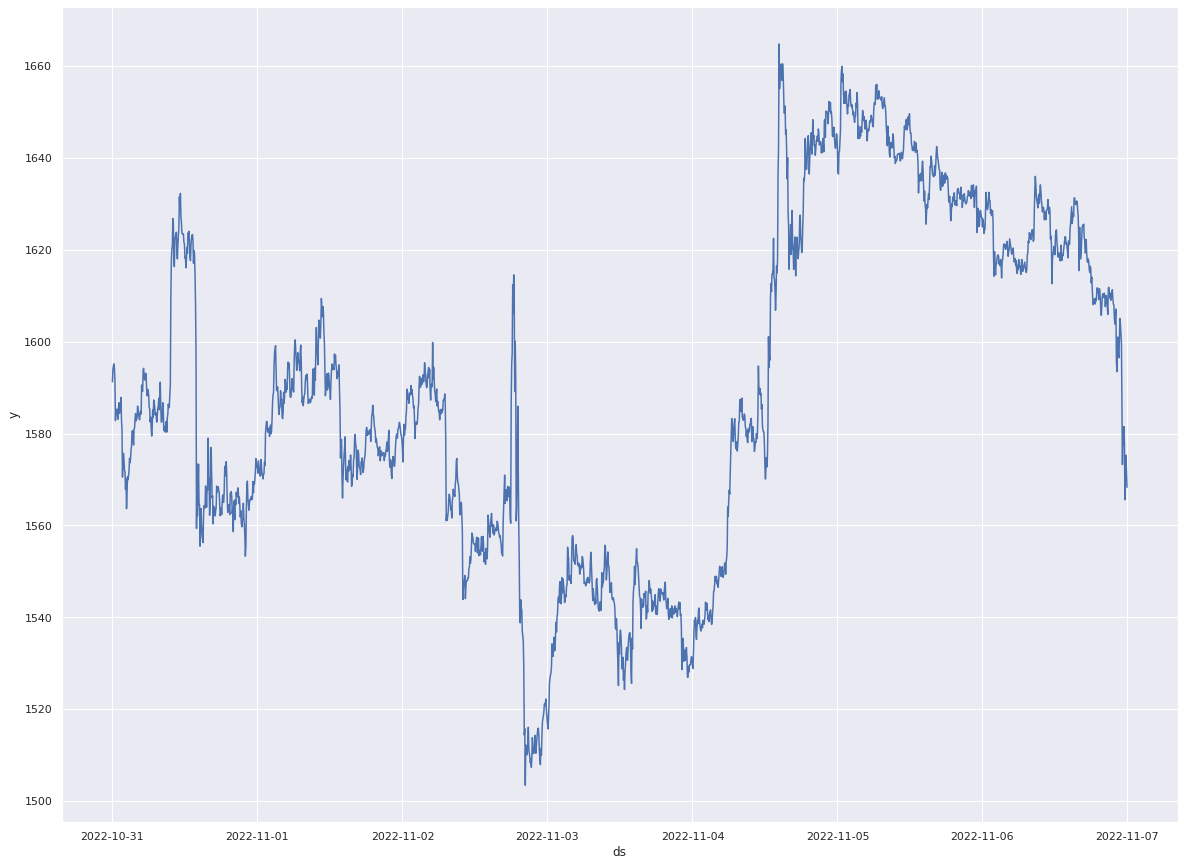

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


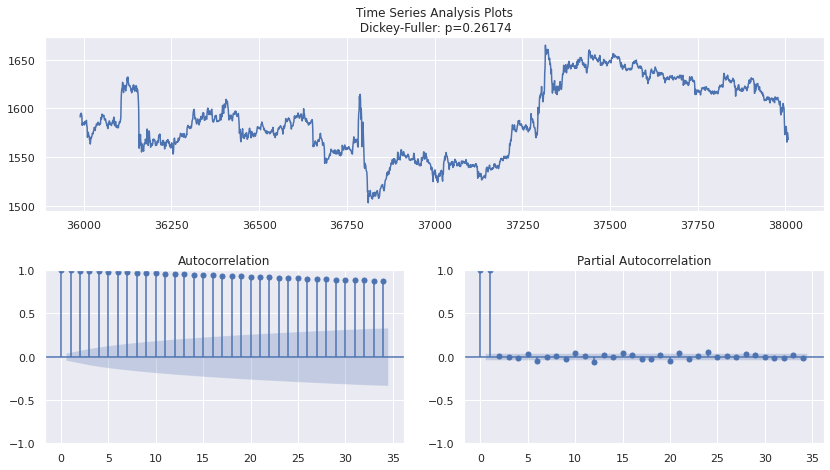

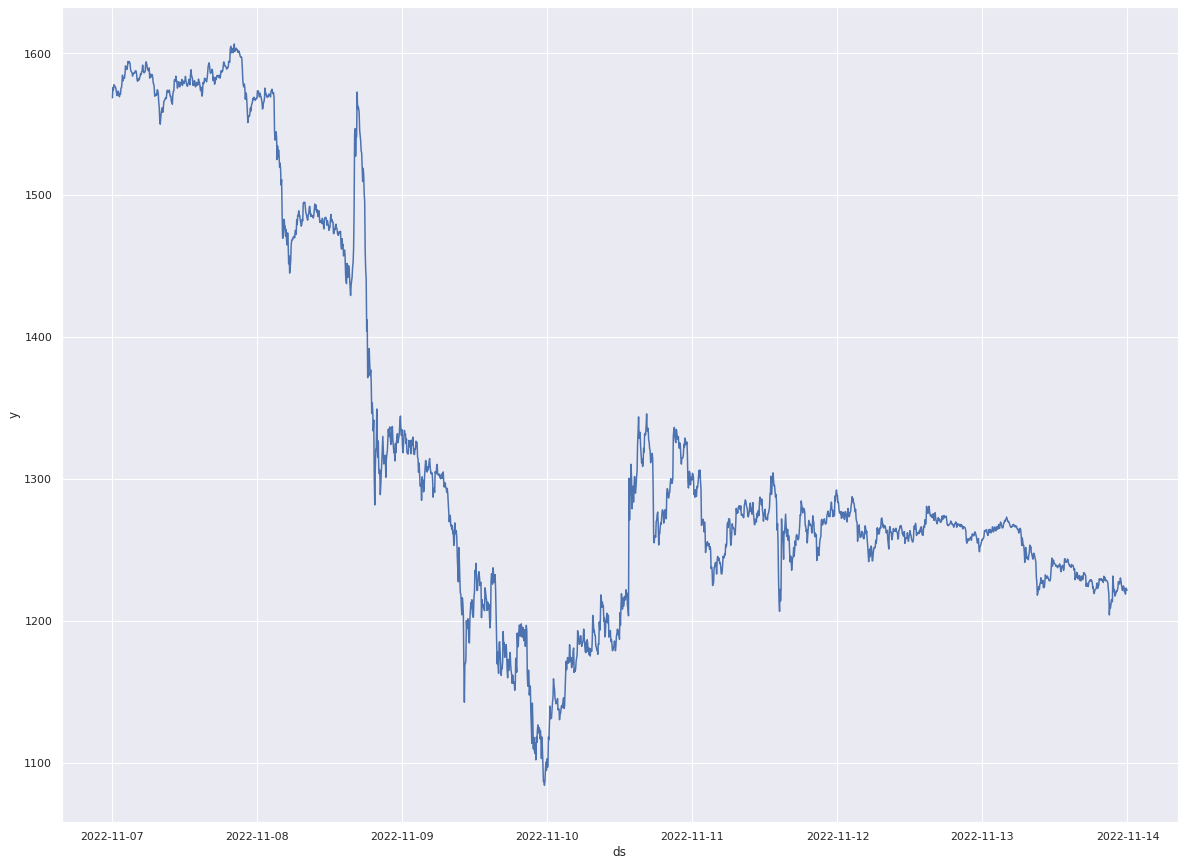

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


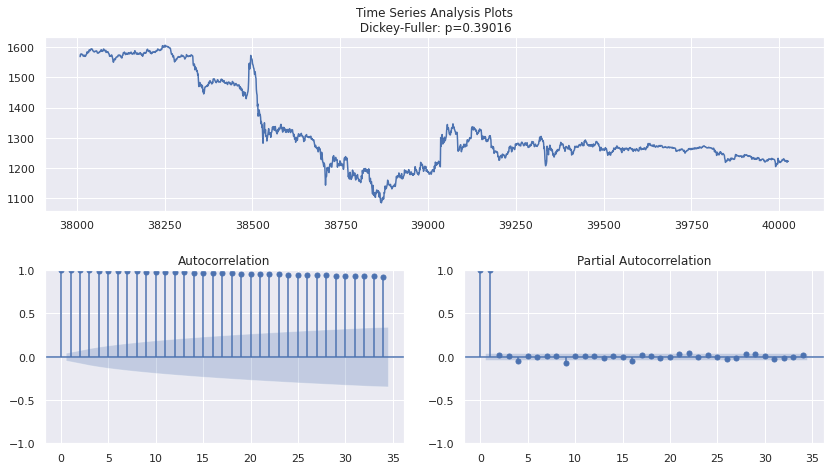

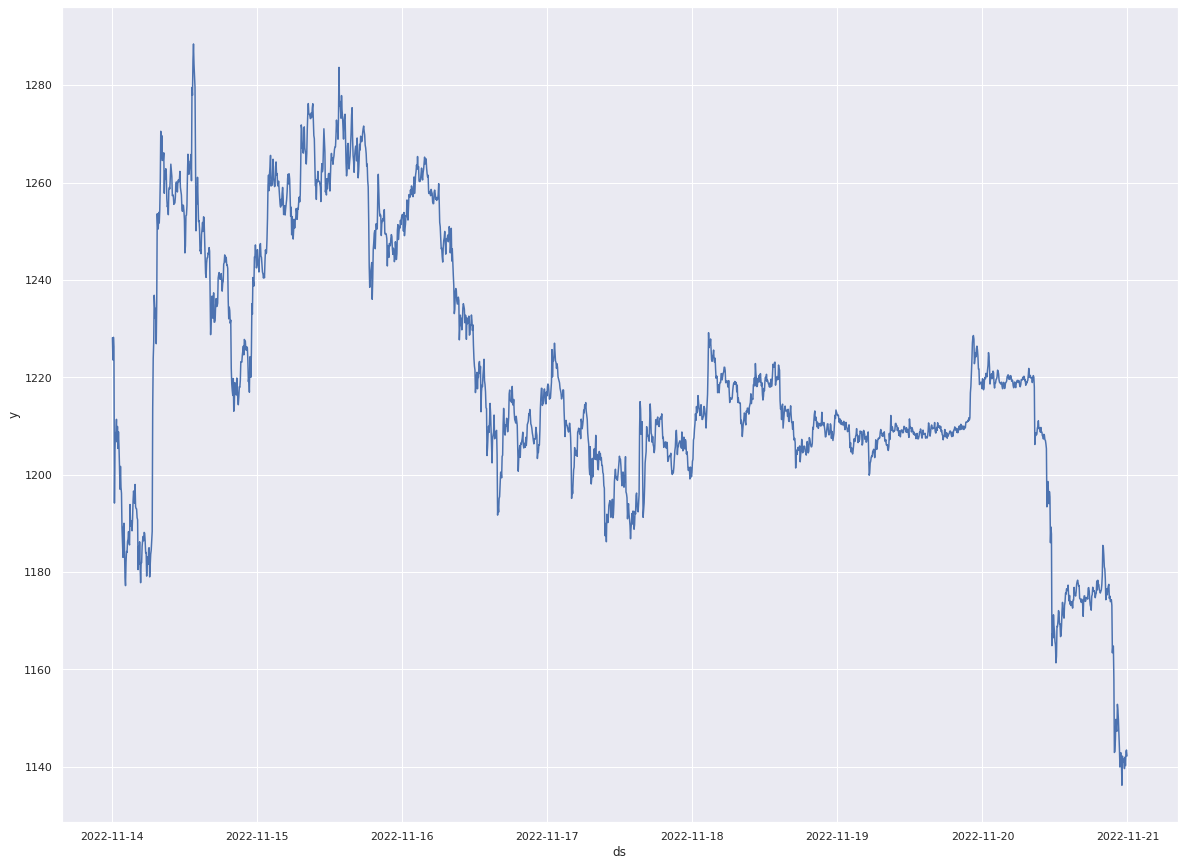

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


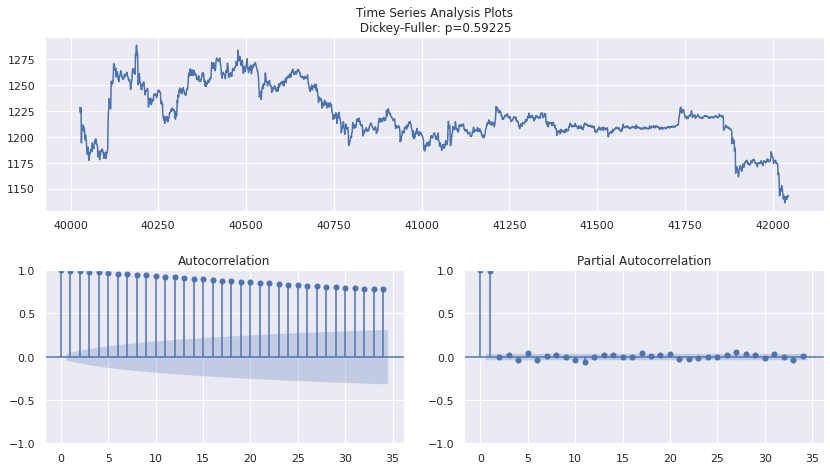

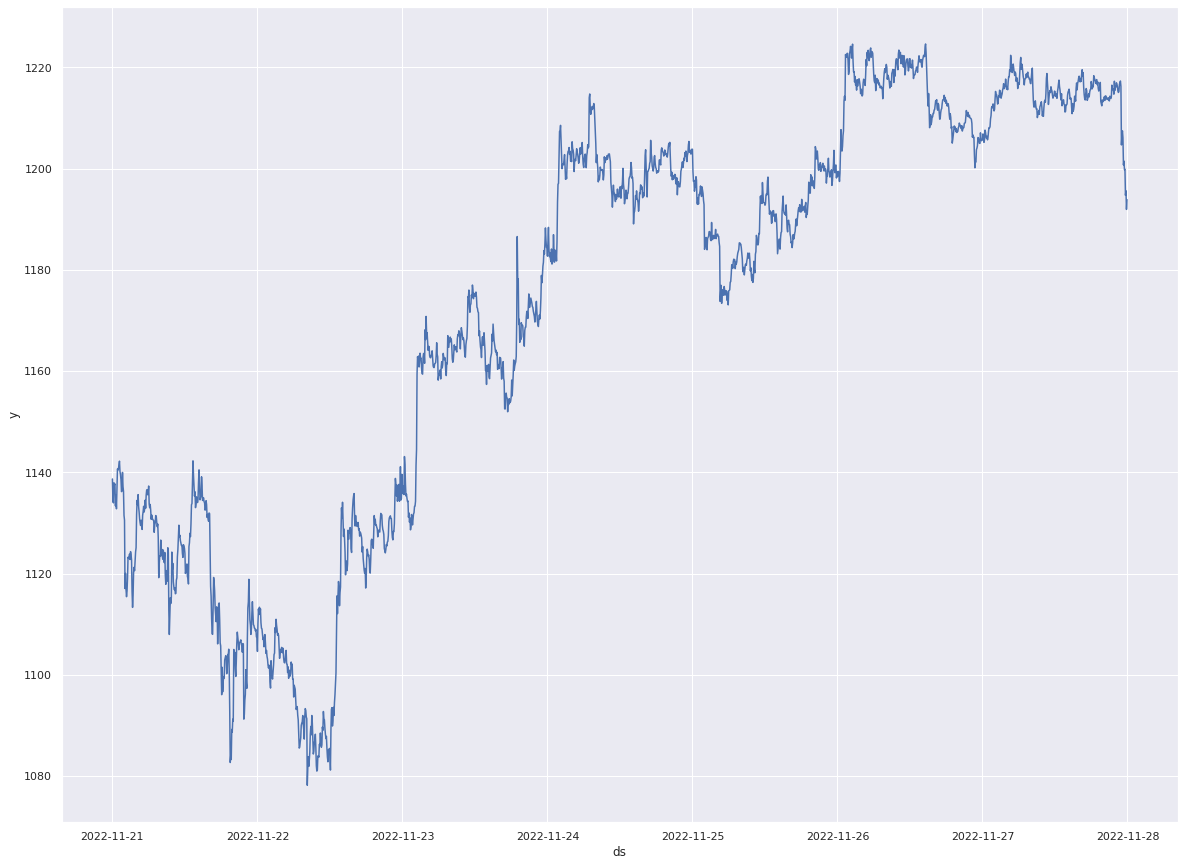

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


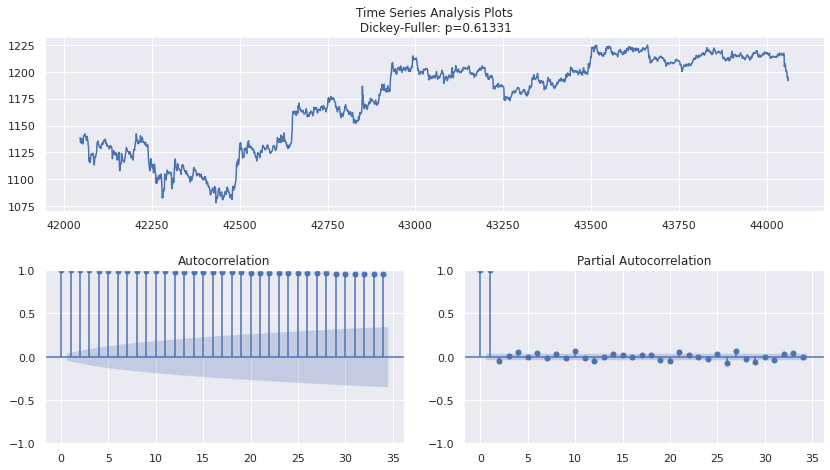

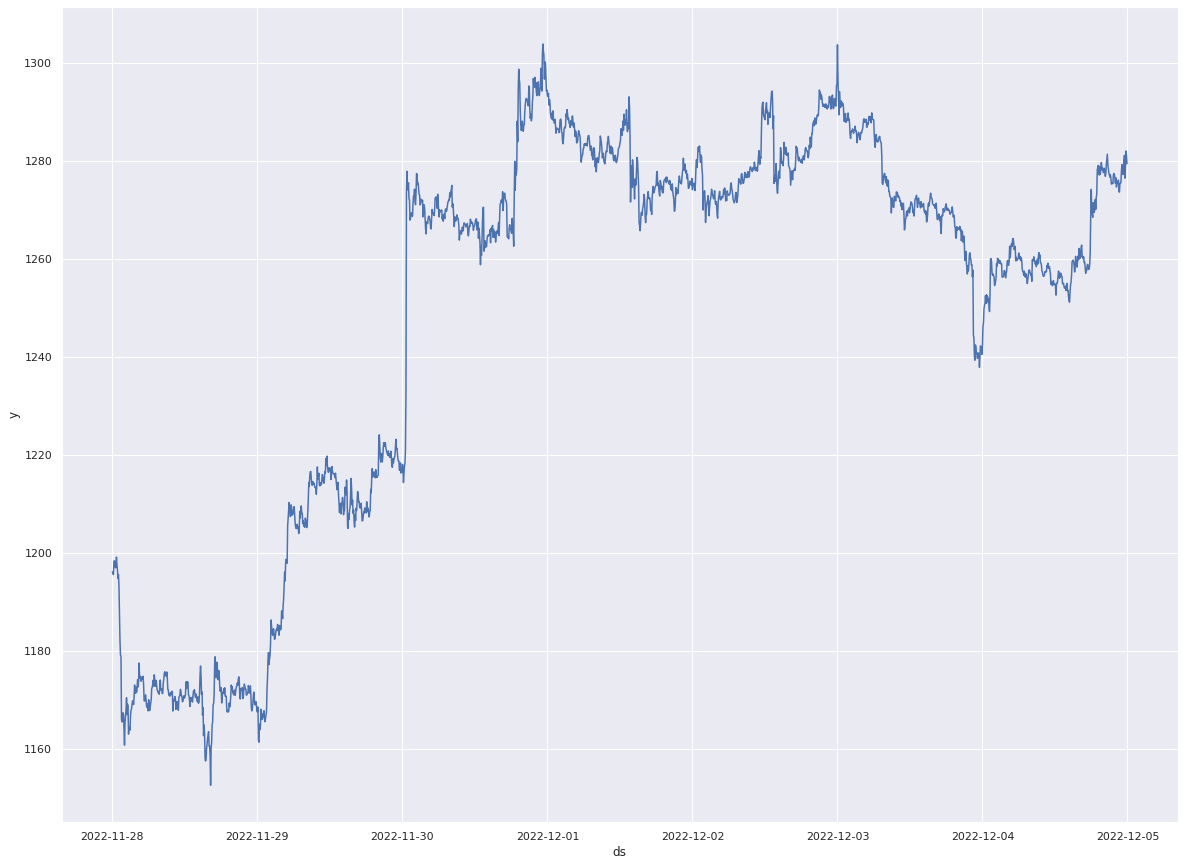

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


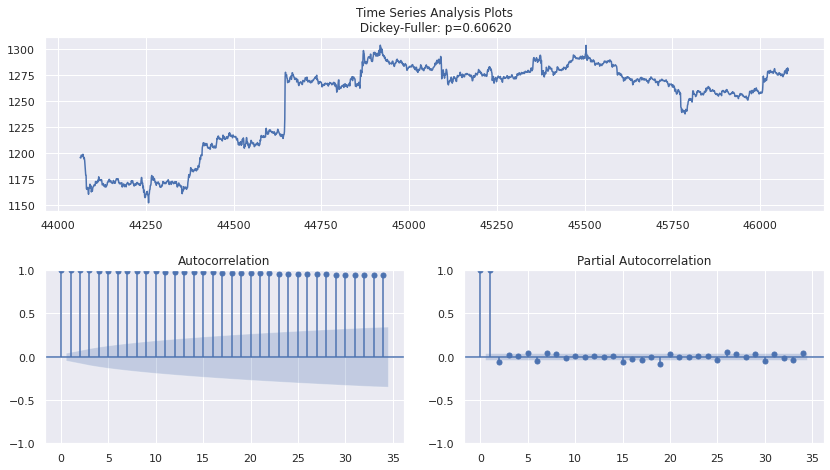

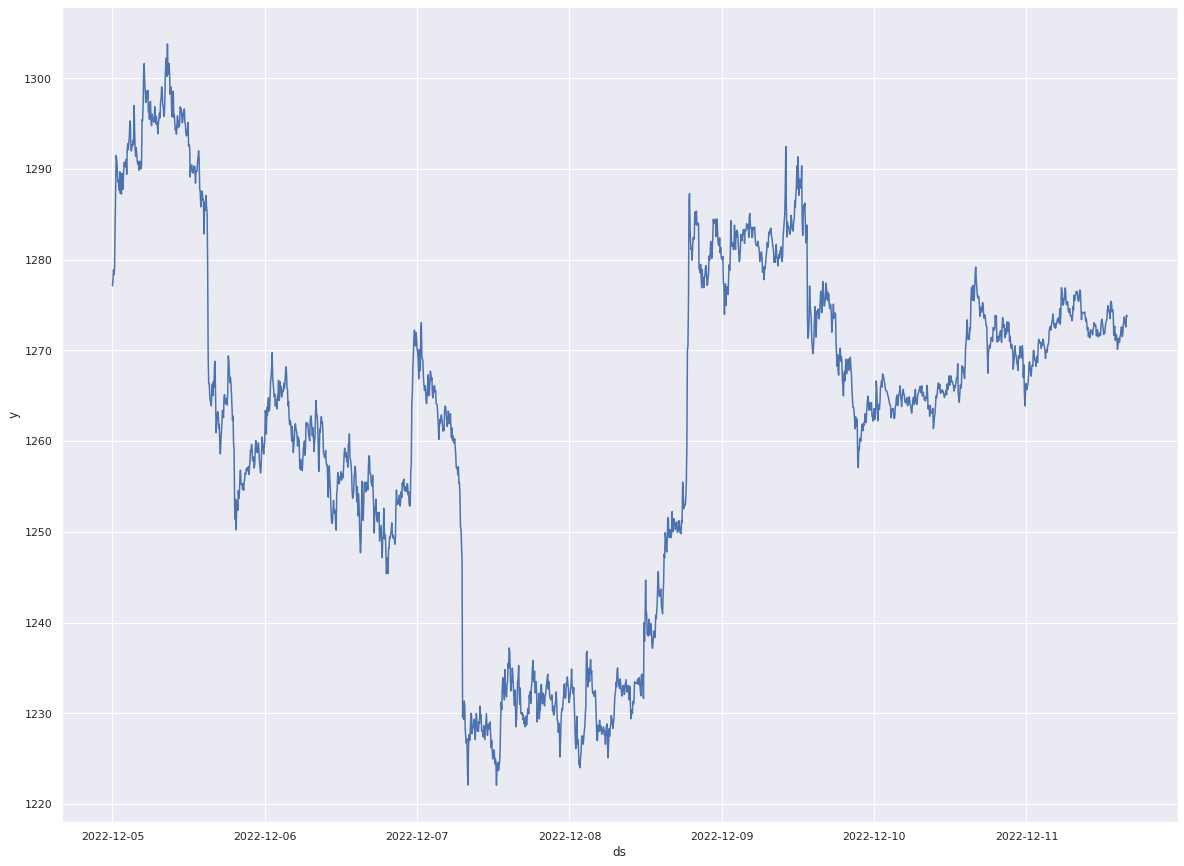

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


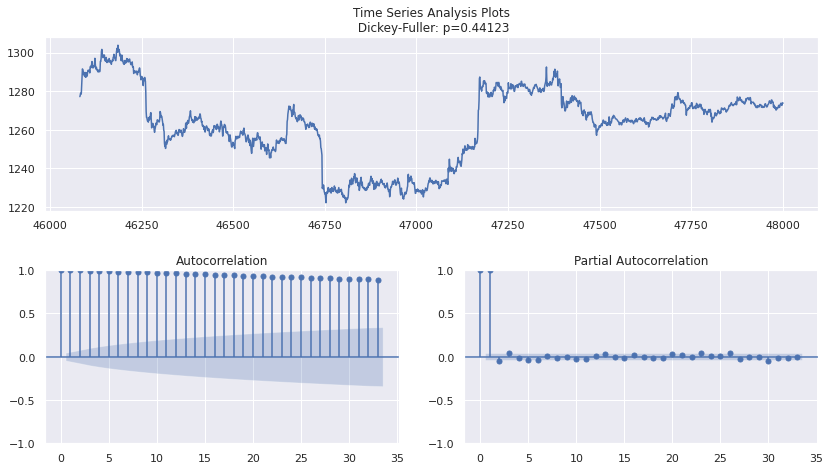

In [214]:

for i in range(len(weeks)-6, len(weeks)):
#     print(w)
    fig, ax = plt.subplots(1,1,figsize=(20,15))
    w = weeks[i]
    sns.lineplot(data=w, x="ds",y="y", ax=ax)
    
    plt.show()
    tsplot(w['y'])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/dge1ikr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/bt5rcw0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1310', 'data', 'file=/tmp/tmpmu0vbl24/dge1ikr6.json', 'init=/tmp/tmpmu0vbl24/bt5rcw0r.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelxj6o3yci/prophet_model-20221212024432.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02

20
NMSE = 1.9368453966344352e-05


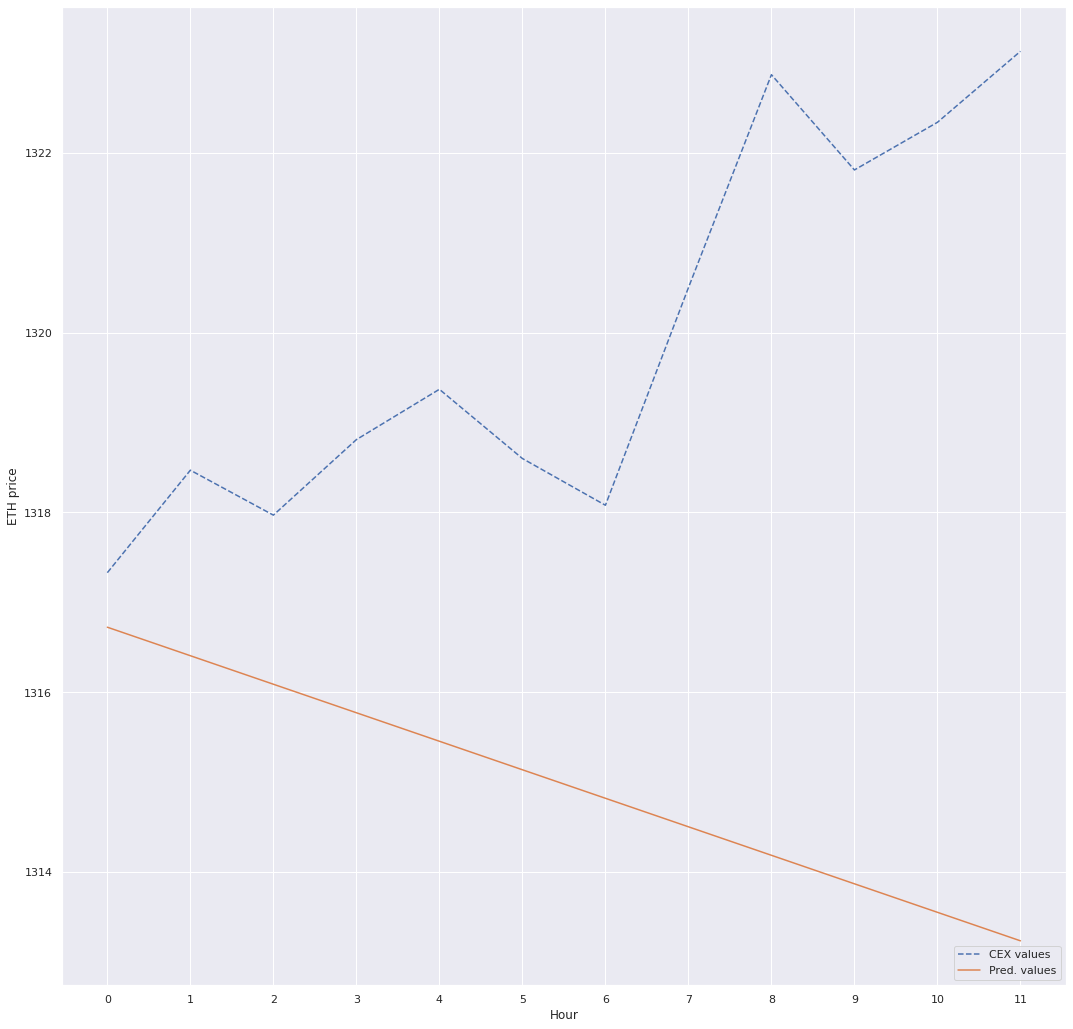

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/5g09yc54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/76p3kncy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30062', 'data', 'file=/tmp/tmpmu0vbl24/5g09yc54.json', 'init=/tmp/tmpmu0vbl24/76p3kncy.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modeley6n6o08/prophet_model-20221212024432.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

21
NMSE = 5.198027714836065e-05


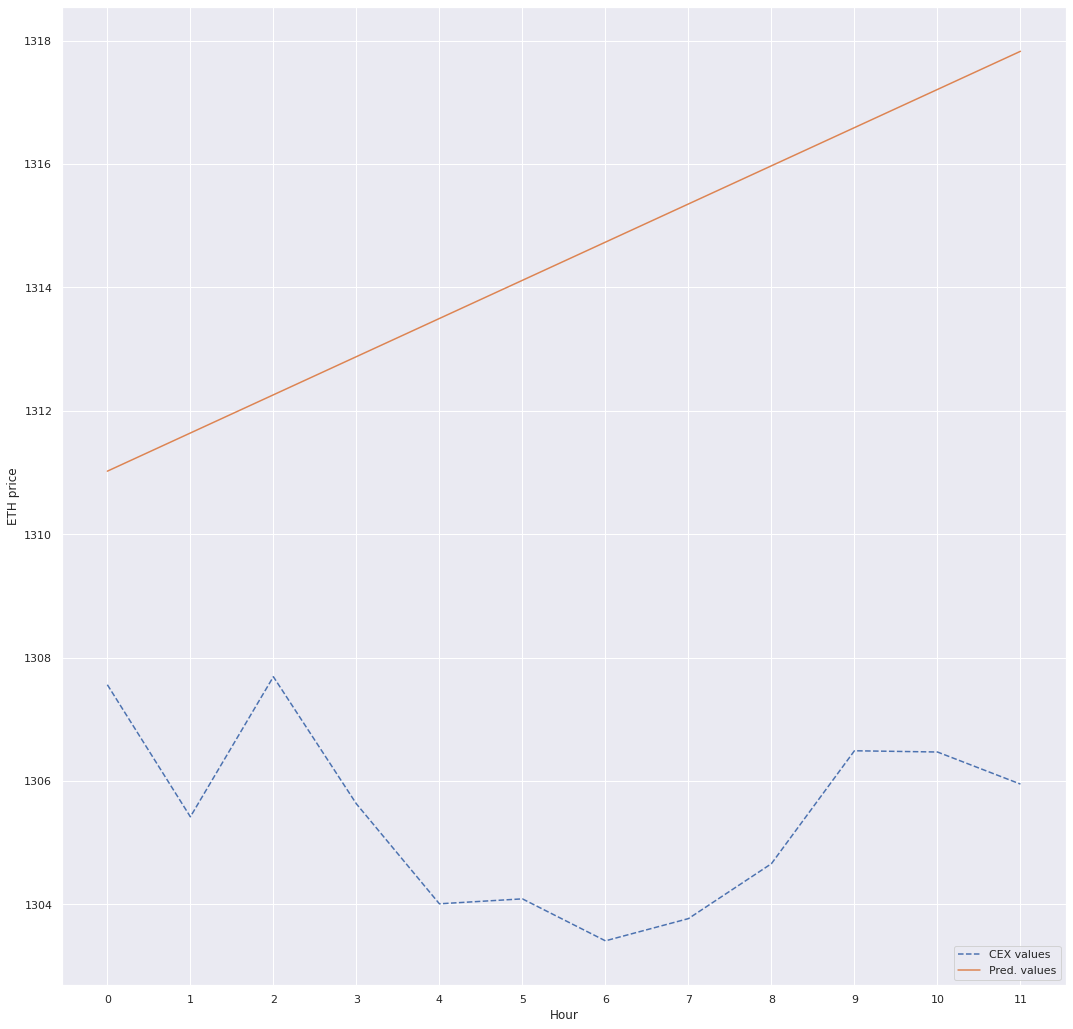

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/l08g74bx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/nfk1cblw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40001', 'data', 'file=/tmp/tmpmu0vbl24/l08g74bx.json', 'init=/tmp/tmpmu0vbl24/nfk1cblw.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modell10c_09y/prophet_model-20221212024432.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

22
NMSE = 0.00028513508657205123


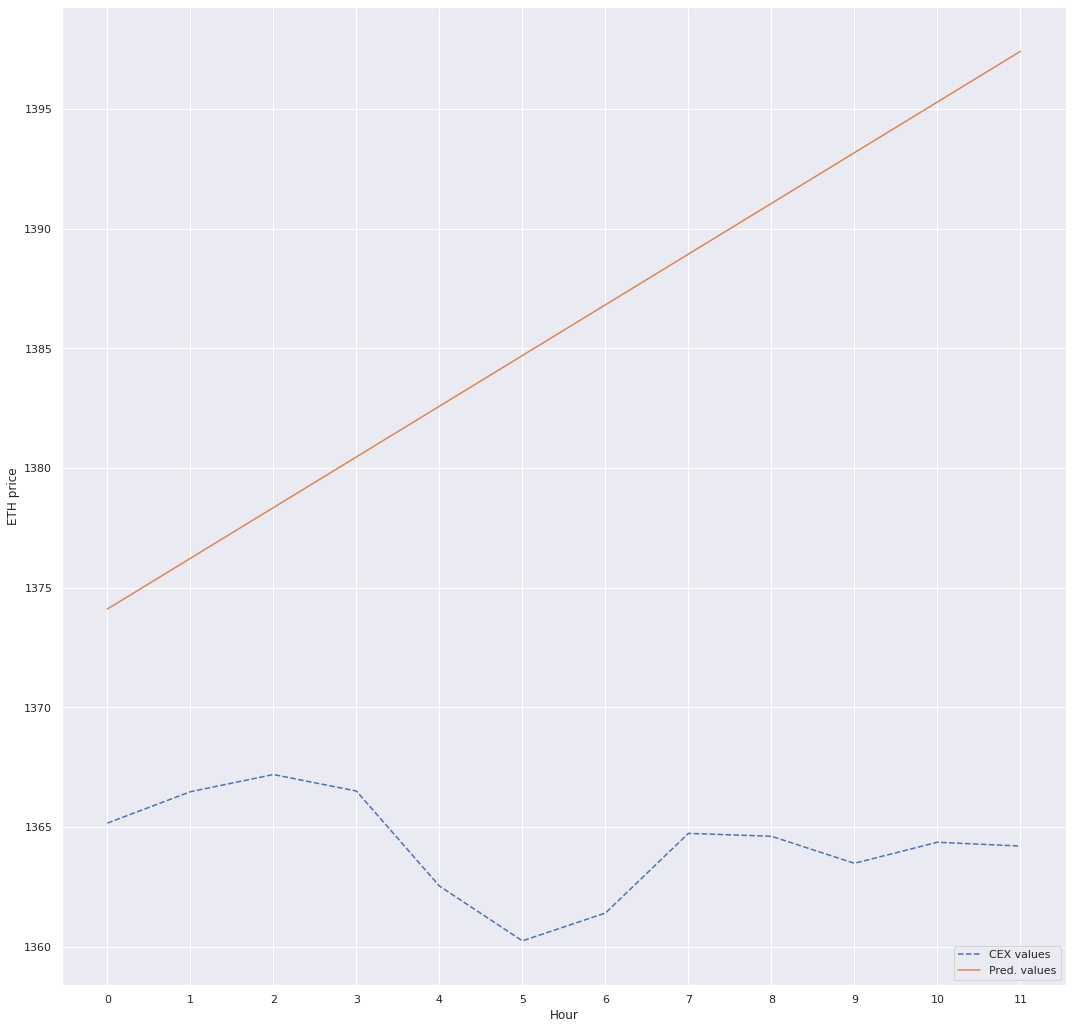

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/n8cx74dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ivq1esyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9830', 'data', 'file=/tmp/tmpmu0vbl24/n8cx74dl.json', 'init=/tmp/tmpmu0vbl24/ivq1esyf.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelp9t2v9l9/prophet_model-20221212024433.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02

23
NMSE = 4.581196112804919e-06


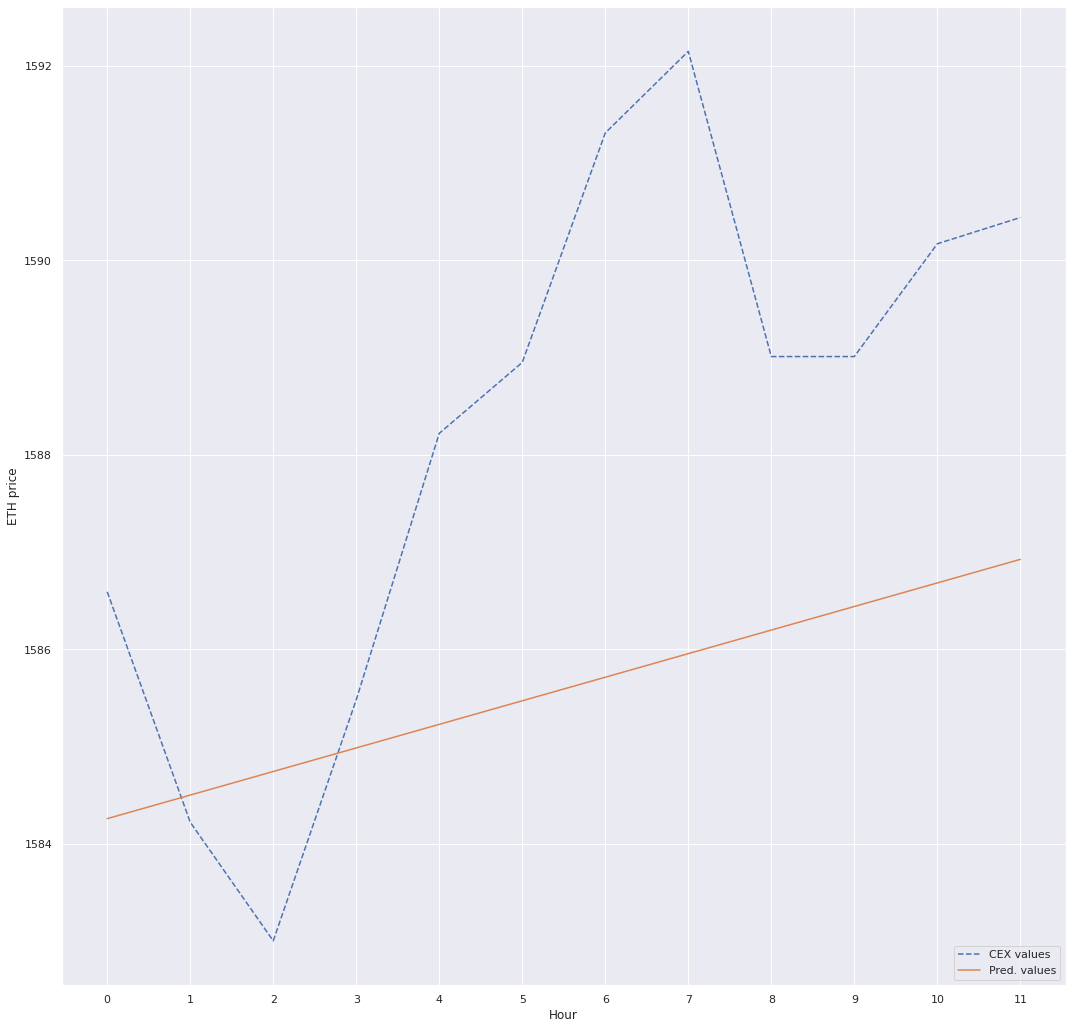

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/z1h7c_ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/1g4_y5x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4740', 'data', 'file=/tmp/tmpmu0vbl24/z1h7c_ge.json', 'init=/tmp/tmpmu0vbl24/1g4_y5x8.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelp0d03vkg/prophet_model-20221212024433.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02

24
NMSE = 0.0003810325653449041


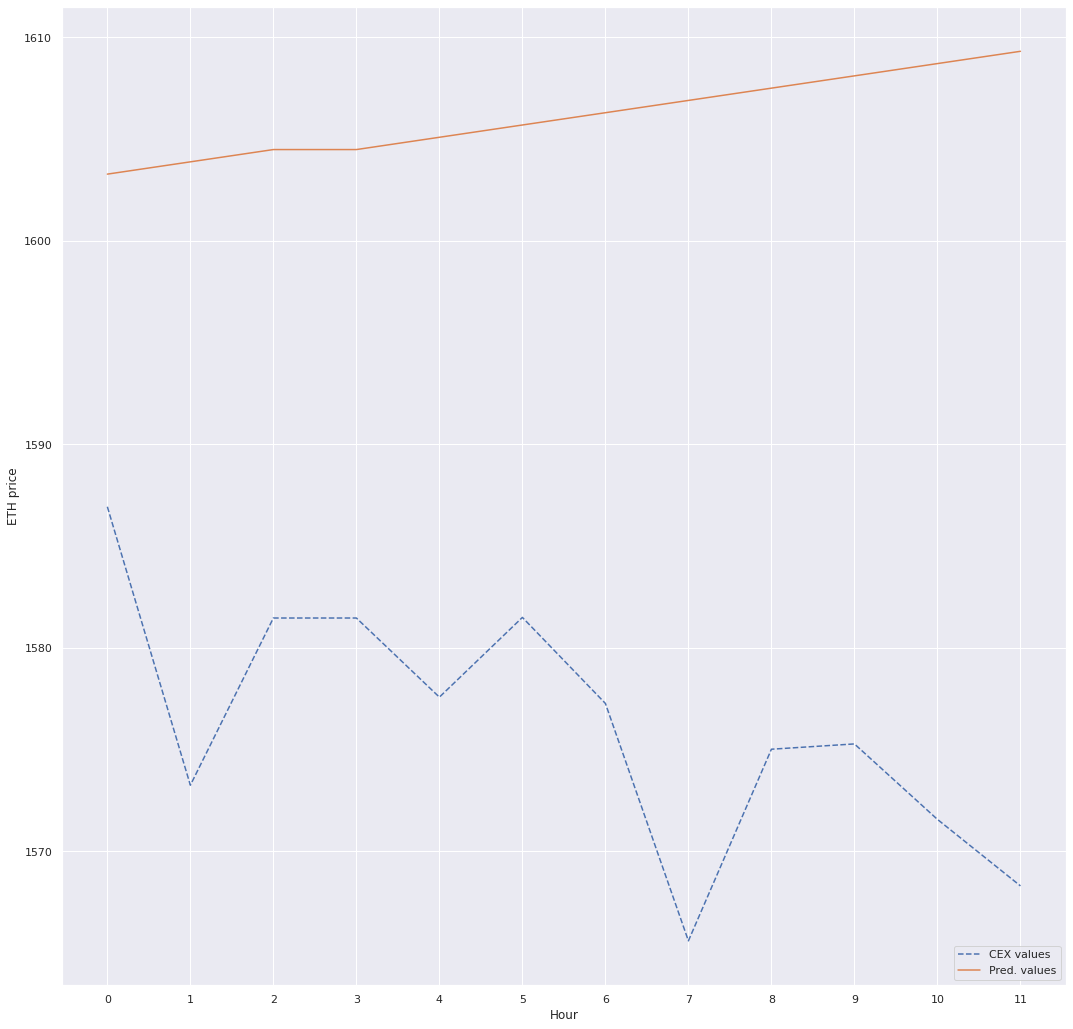

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/0n3ijufg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/3e5ab_lc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46530', 'data', 'file=/tmp/tmpmu0vbl24/0n3ijufg.json', 'init=/tmp/tmpmu0vbl24/3e5ab_lc.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelrmp1ywqx/prophet_model-20221212024433.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

25
NMSE = 0.00014024295311885945


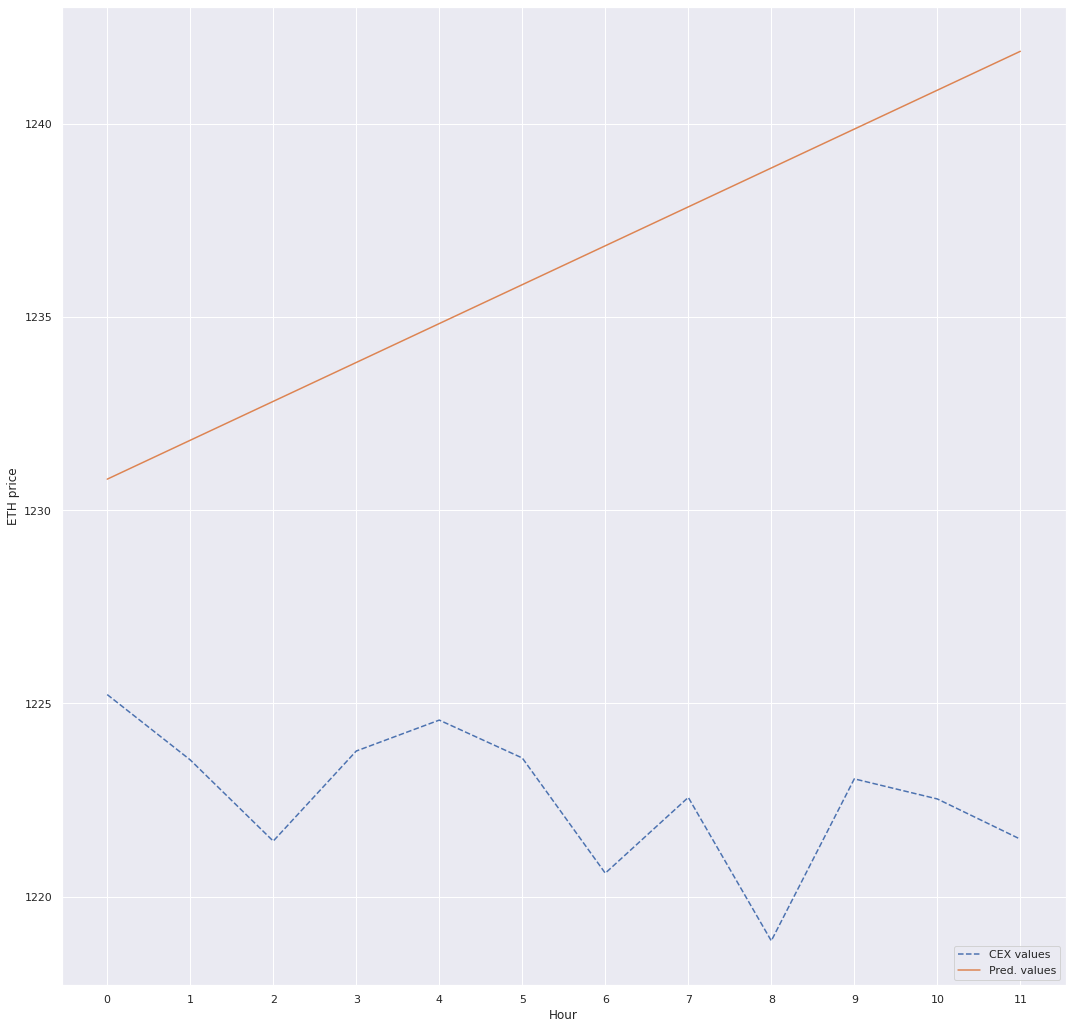

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/imh7f0aj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/qr0zjmhs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88495', 'data', 'file=/tmp/tmpmu0vbl24/imh7f0aj.json', 'init=/tmp/tmpmu0vbl24/qr0zjmhs.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modeleno16ol2/prophet_model-20221212024434.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

26
NMSE = 8.6146463183912e-06


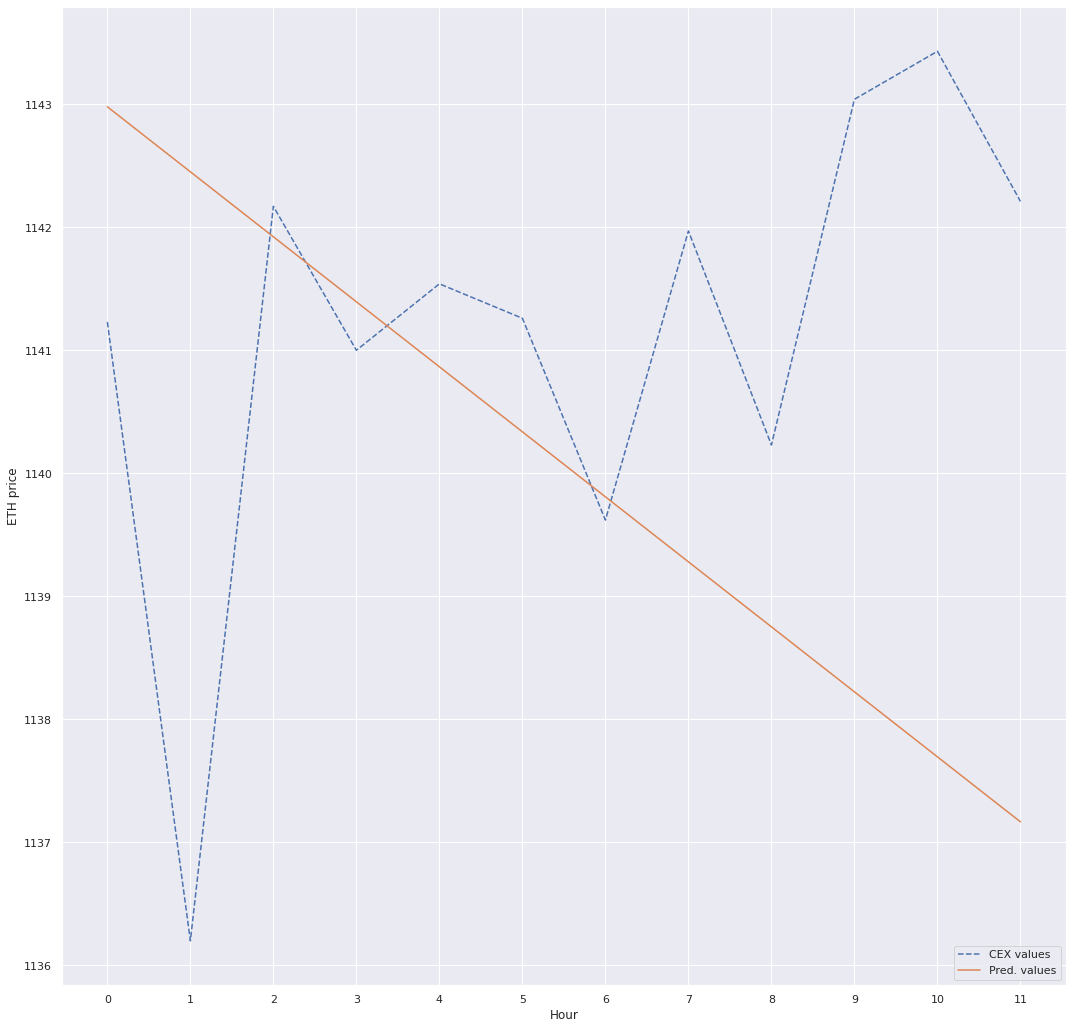

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/zzacm5le.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/tu5tpl8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50842', 'data', 'file=/tmp/tmpmu0vbl24/zzacm5le.json', 'init=/tmp/tmpmu0vbl24/tu5tpl8s.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model93sbi36_/prophet_model-20221212024434.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

27
NMSE = 0.00020511346700133876


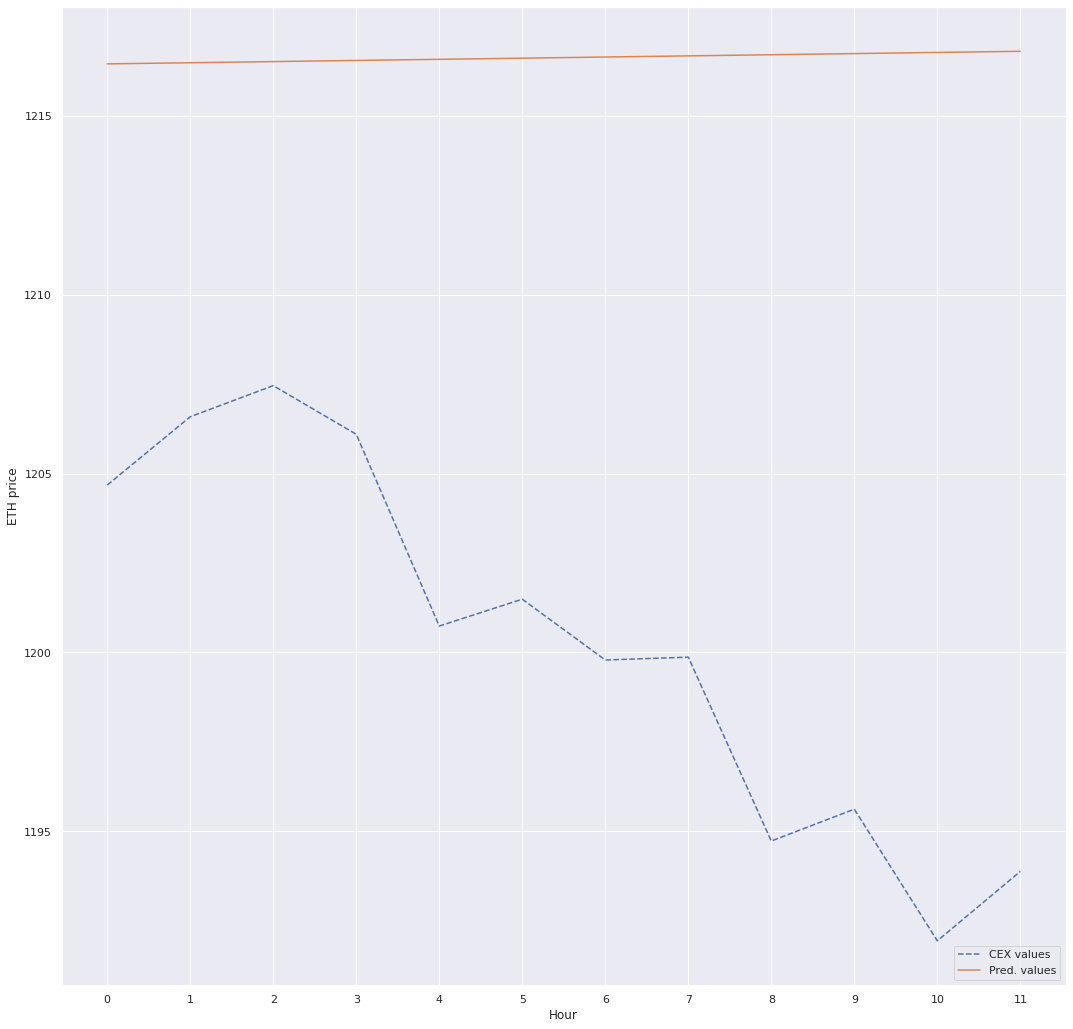

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/p58eddmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/urpnwjxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70534', 'data', 'file=/tmp/tmpmu0vbl24/p58eddmw.json', 'init=/tmp/tmpmu0vbl24/urpnwjxv.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelpr45zbfs/prophet_model-20221212024434.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

28
NMSE = 1.4989608300717672e-05


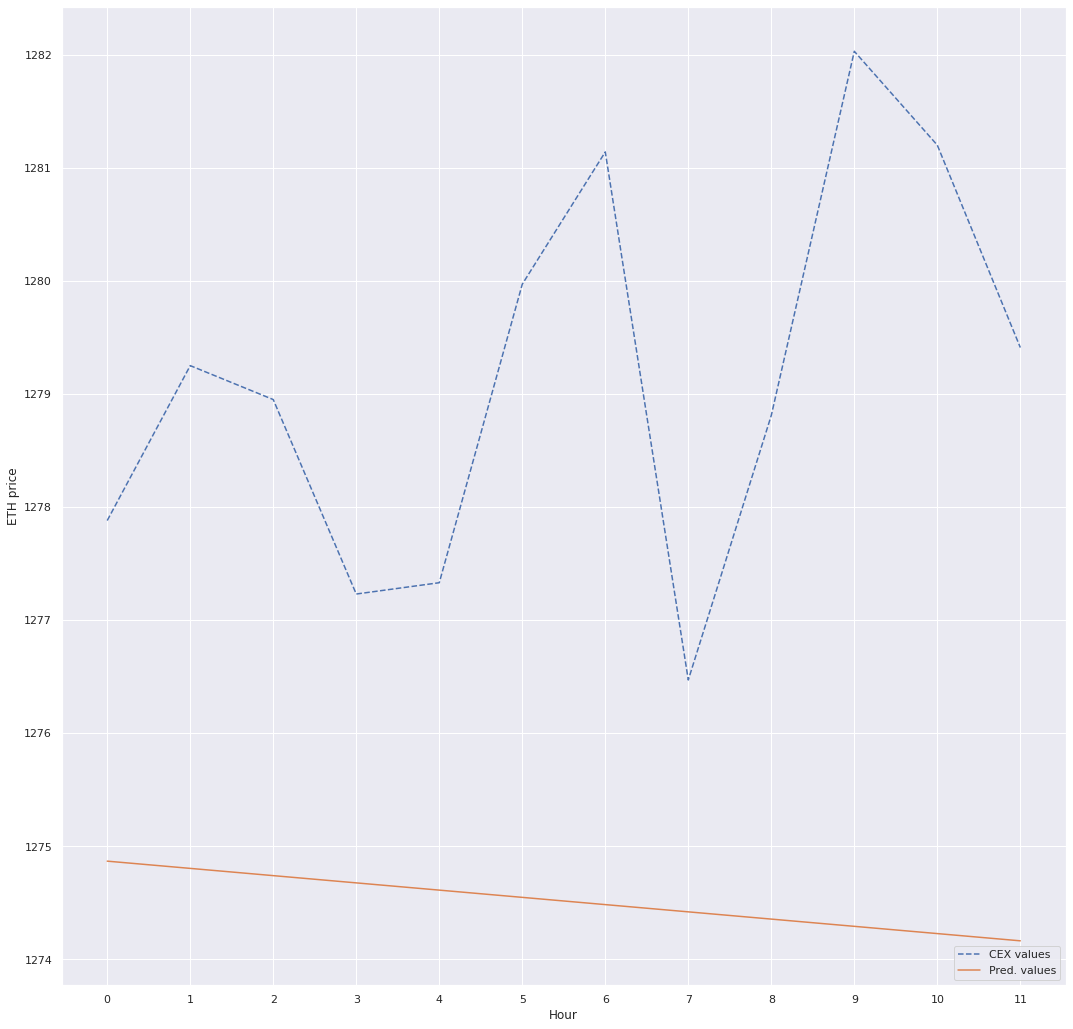

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/g4omss1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/5k8yxk7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1159', 'data', 'file=/tmp/tmpmu0vbl24/g4omss1v.json', 'init=/tmp/tmpmu0vbl24/5k8yxk7g.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelijhr7sbh/prophet_model-20221212024434.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02

29
NMSE = 7.916896712411224e-07


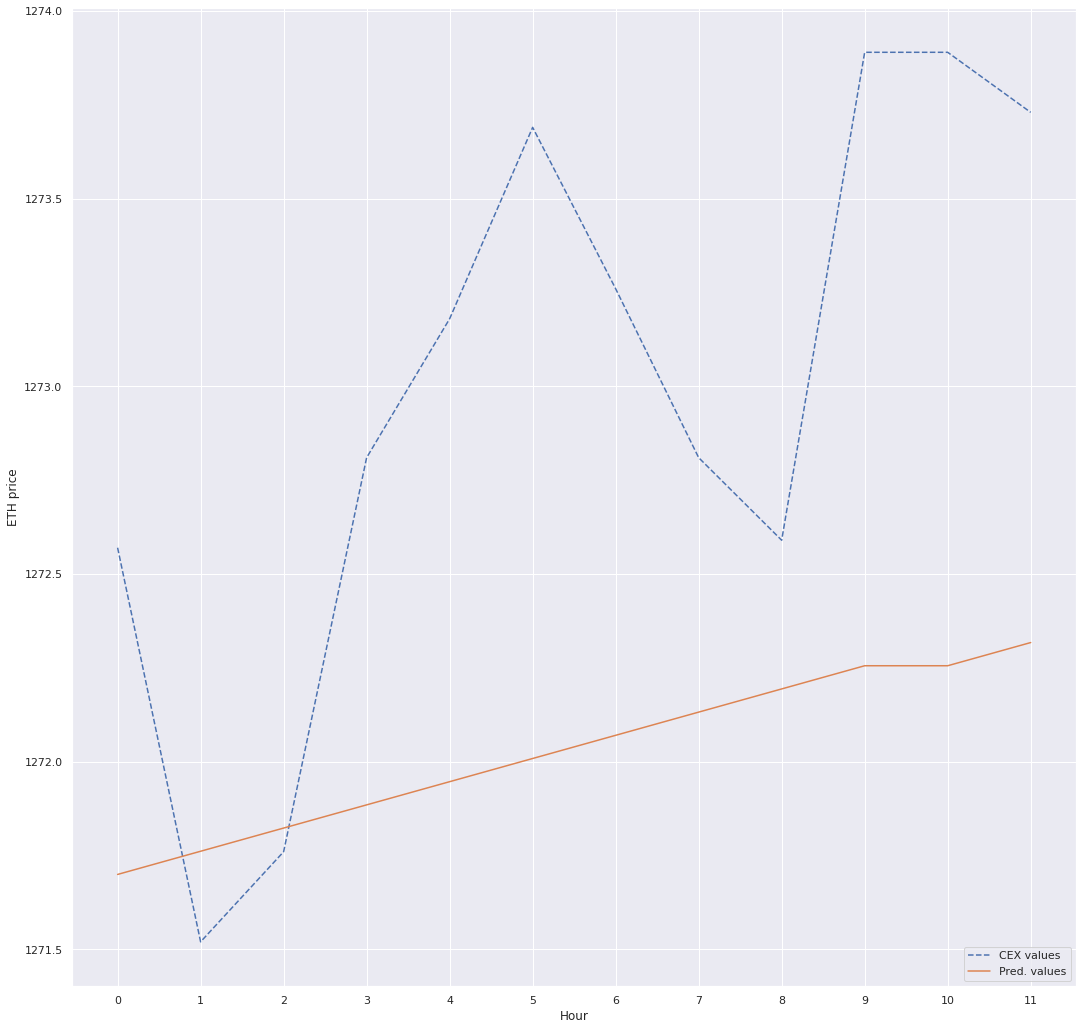

mean weeks nsme: 0.00011118499435550135


In [210]:

start_hour = 24 * 2
NSME_list = []

for i in range(len(weeks)-10, len(weeks)):
    print(i)
    w = weeks[i] 
    last_x_hours = 12
    # use the last 12 hours of testing set, all the previous data is used as training
    train_data = w.iloc[-last_x_hours-start_hour:-last_x_hours,:]
    test_data = w.iloc[-last_x_hours:,:]
    model = Prophet()  #weekly_seasonality=True,  # daily_seasonality=True
    model.fit(train_data)
    #Predict ETH values over the range of the test set
    forecast = model.predict(pd.DataFrame({"ds":test_data.ds}))
    pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()
    # now, we have predicted and actual values. Let's find error, and plot!
    cex_vals = test_data.y
    nmse = calc_nmse(cex_vals, pred_vals_test)
    print(f"NMSE = {nmse}")
    NSME_list.append(nmse)
    plot_prices(cex_vals, pred_vals_test,last_x_hours)
    
print("=" * 10)
print(f"mean weeks nsme: {np.mean(NSME_list)}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/6u48jtef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/7m71obhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33706', 'data', 'file=/tmp/tmpmu0vbl24/6u48jtef.json', 'init=/tmp/tmpmu0vbl24/7m71obhi.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelrca7pkbk/prophet_model-20221212024101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.7956439340408935e-05


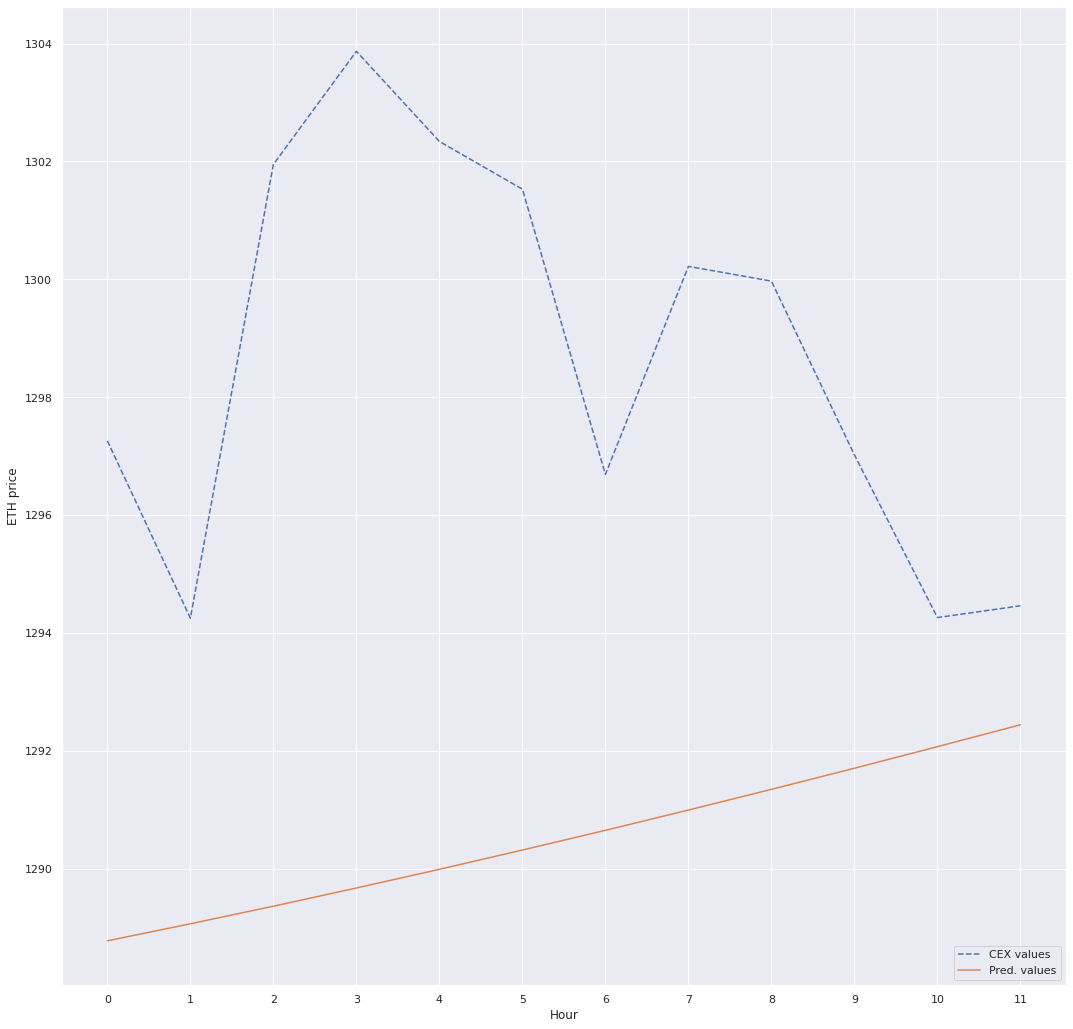

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/911ixrk0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/wkkxclbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44476', 'data', 'file=/tmp/tmpmu0vbl24/911ixrk0.json', 'init=/tmp/tmpmu0vbl24/wkkxclbm.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model1cz_yyp6/prophet_model-20221212024104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.573581888816463e-06


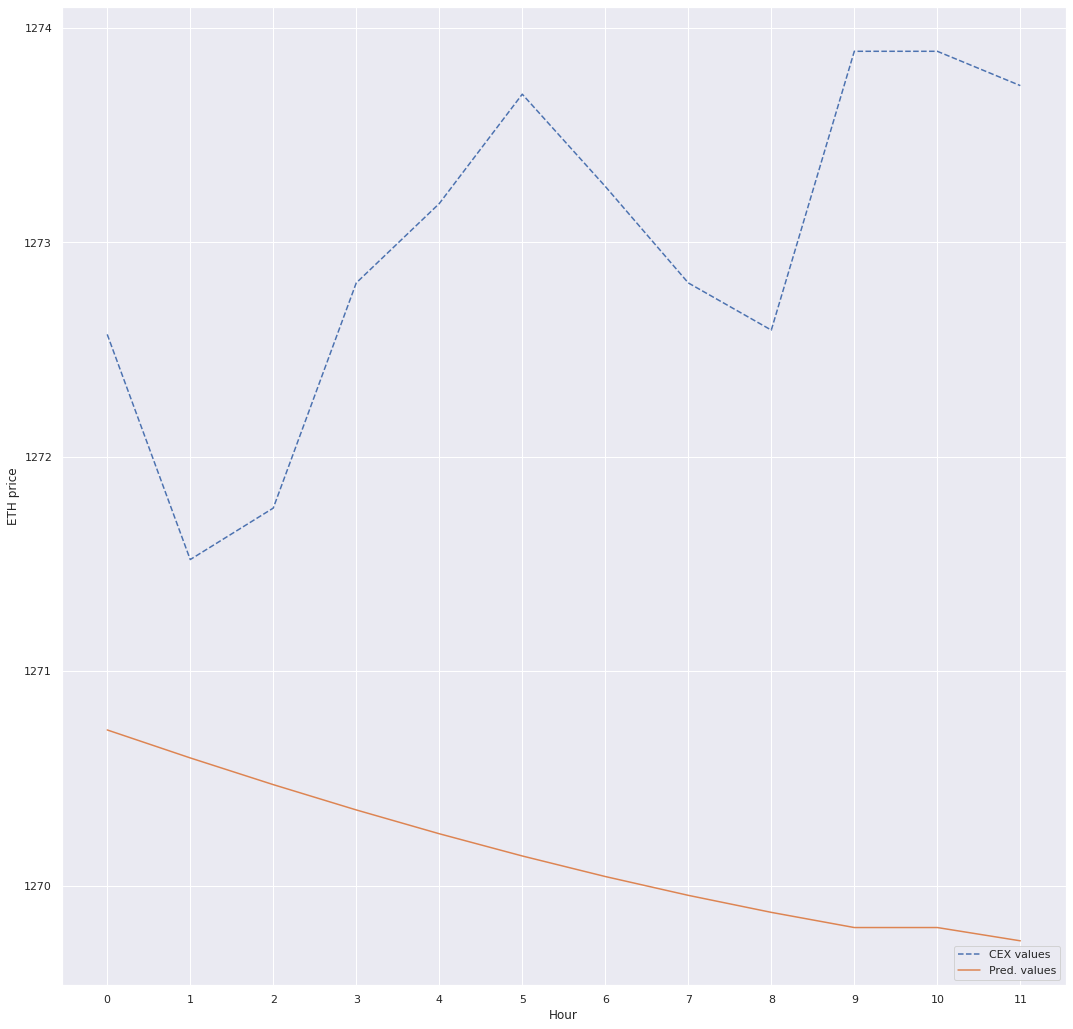

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/yengtb8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/nccm_1f_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13576', 'data', 'file=/tmp/tmpmu0vbl24/yengtb8t.json', 'init=/tmp/tmpmu0vbl24/nccm_1f_.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelvmqf07eq/prophet_model-20221212024105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.0017056489420687038


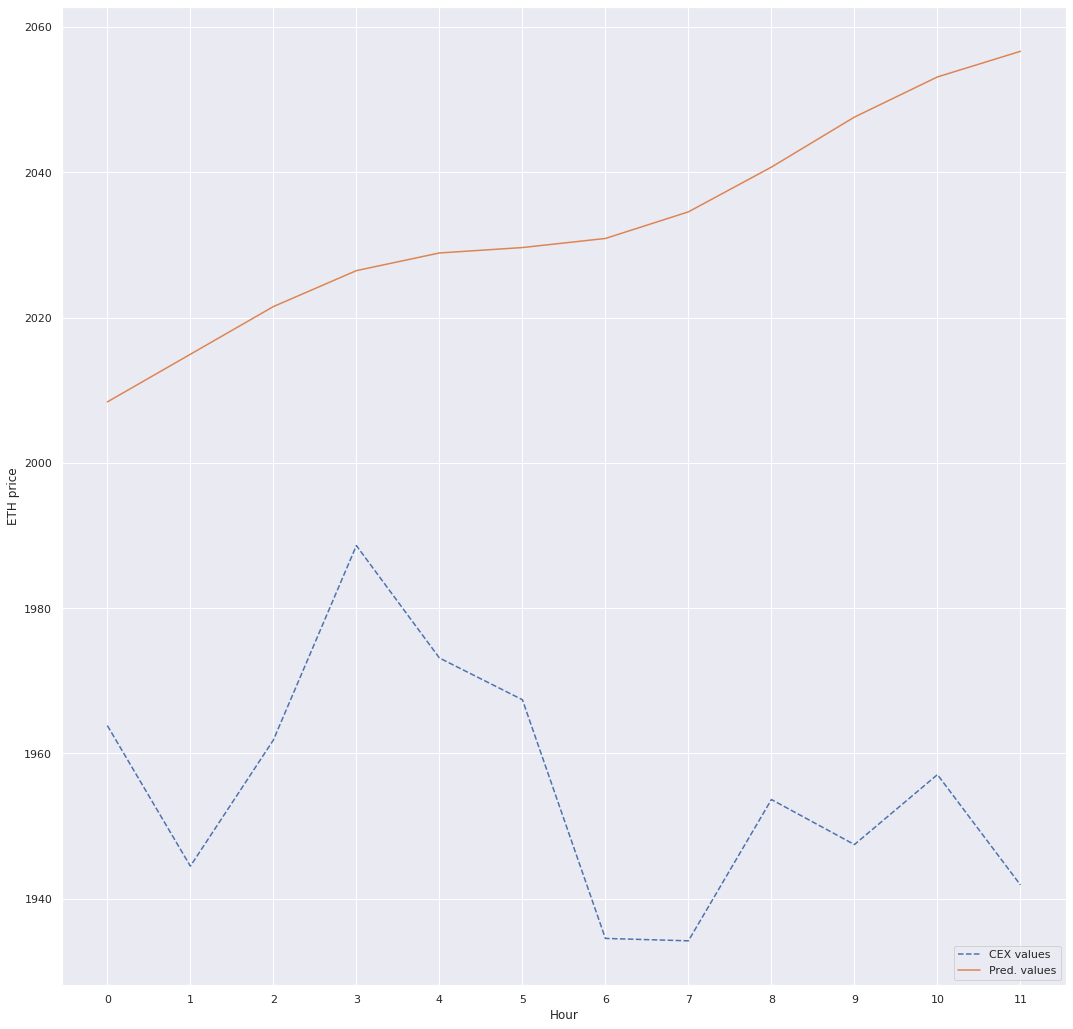

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/t3_oazbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/_j5ji8o3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38243', 'data', 'file=/tmp/tmpmu0vbl24/t3_oazbk.json', 'init=/tmp/tmpmu0vbl24/_j5ji8o3.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelo0tqlgnz/prophet_model-20221212024106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.006391070926750876


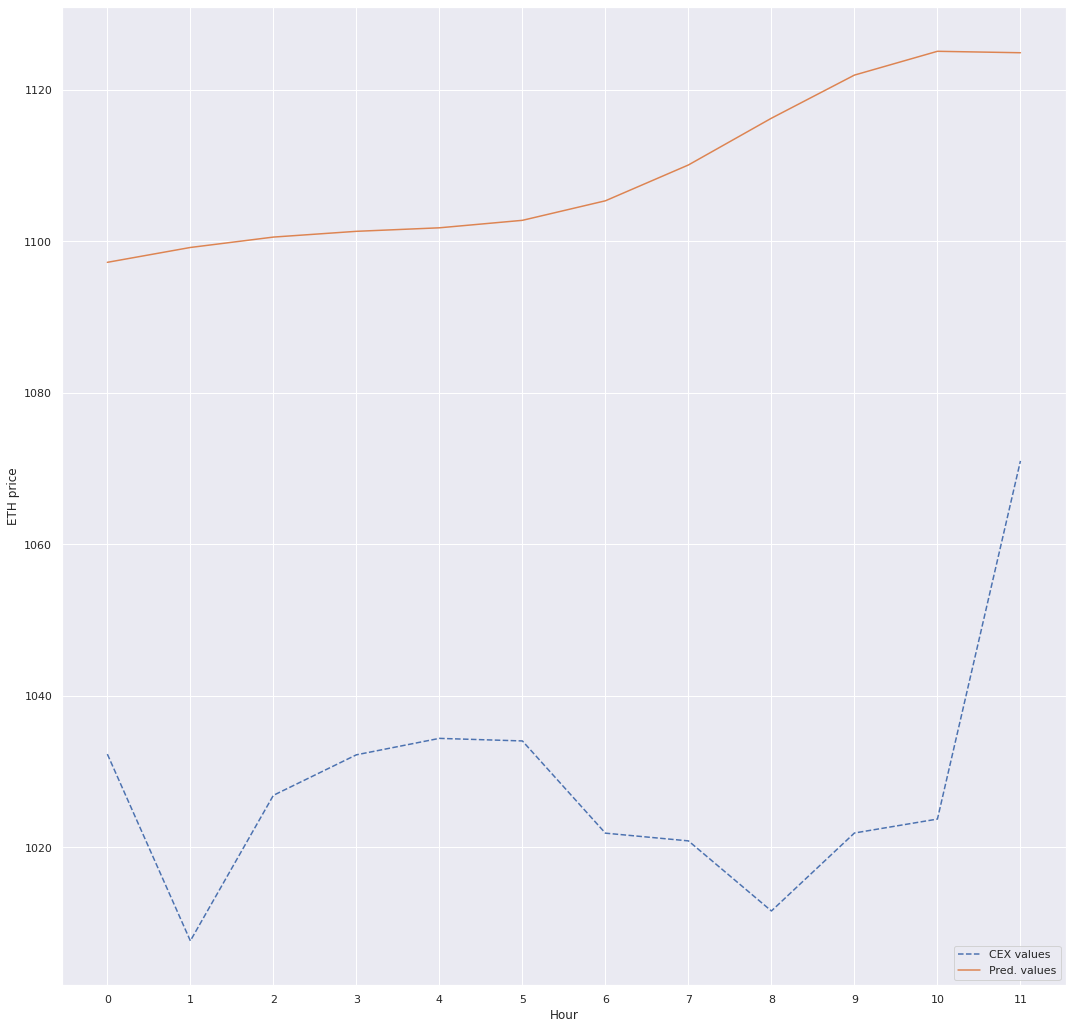

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/857q1xpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/cxelv7x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10314', 'data', 'file=/tmp/tmpmu0vbl24/857q1xpo.json', 'init=/tmp/tmpmu0vbl24/cxelv7x3.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelsskkeoj2/prophet_model-20221212024106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.00026719236751571857


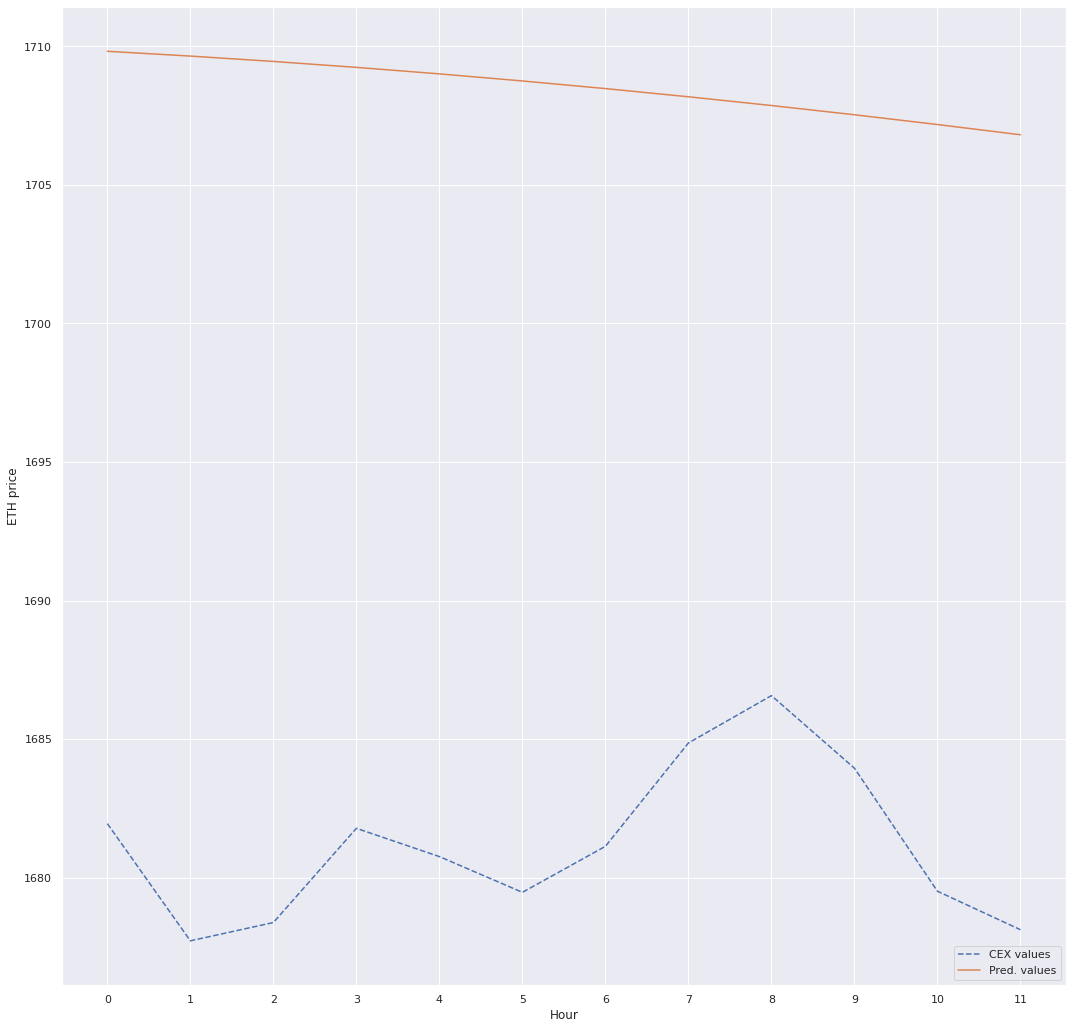

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9xm_yhhm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/vlijklr6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88252', 'data', 'file=/tmp/tmpmu0vbl24/9xm_yhhm.json', 'init=/tmp/tmpmu0vbl24/vlijklr6.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelns2rphpt/prophet_model-20221212024110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.00021470138799732215


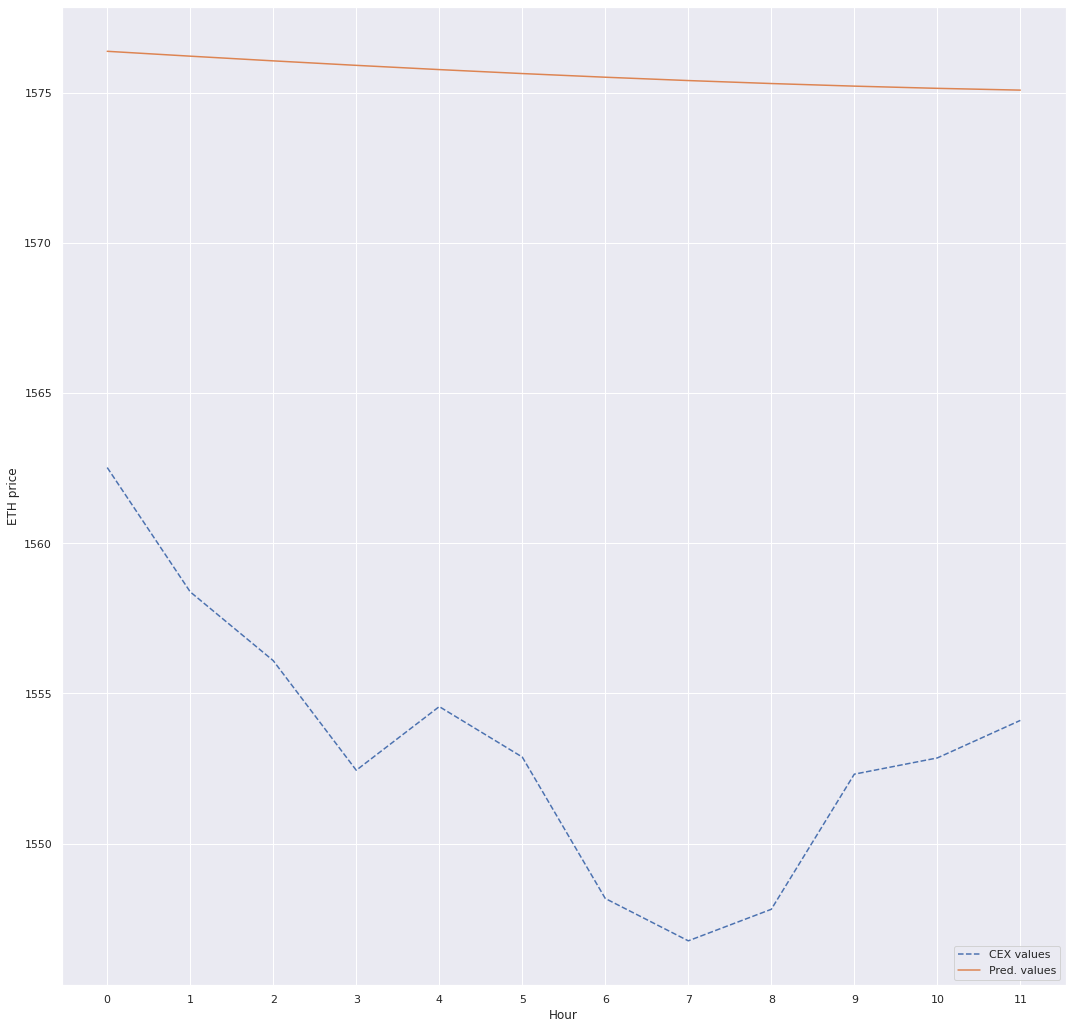

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/6f8z2dxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ns637vle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74105', 'data', 'file=/tmp/tmpmu0vbl24/6f8z2dxr.json', 'init=/tmp/tmpmu0vbl24/ns637vle.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_2ih10hl/prophet_model-20221212024113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.0002064471643293748


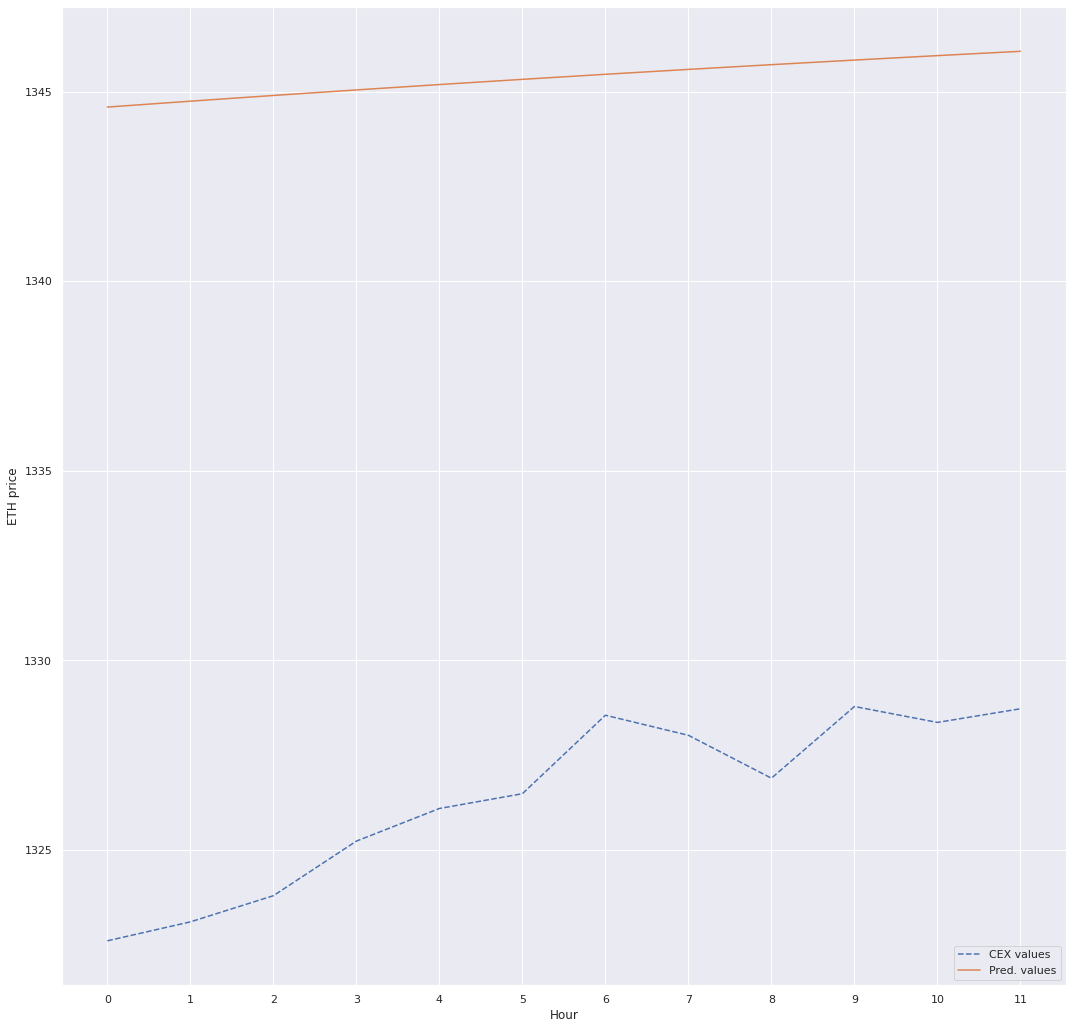

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/xve4ue25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/f7ypibzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43455', 'data', 'file=/tmp/tmpmu0vbl24/xve4ue25.json', 'init=/tmp/tmpmu0vbl24/f7ypibzk.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelatsyygve/prophet_model-20221212024116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 1.4500990054348417e-05


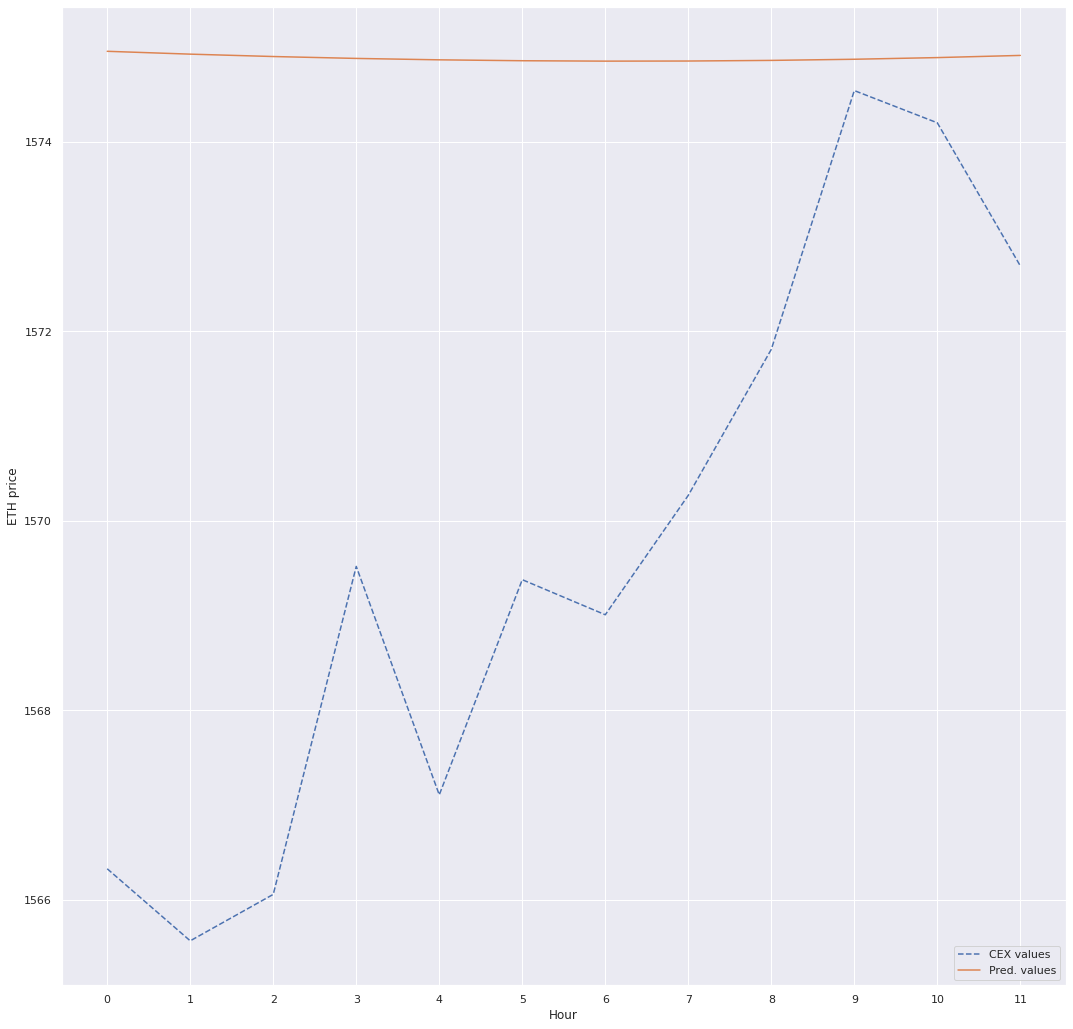

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/wr7mp4oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/frj8xio4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45226', 'data', 'file=/tmp/tmpmu0vbl24/wr7mp4oa.json', 'init=/tmp/tmpmu0vbl24/frj8xio4.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelq7znzbth/prophet_model-20221212024119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.7956439340408935e-05


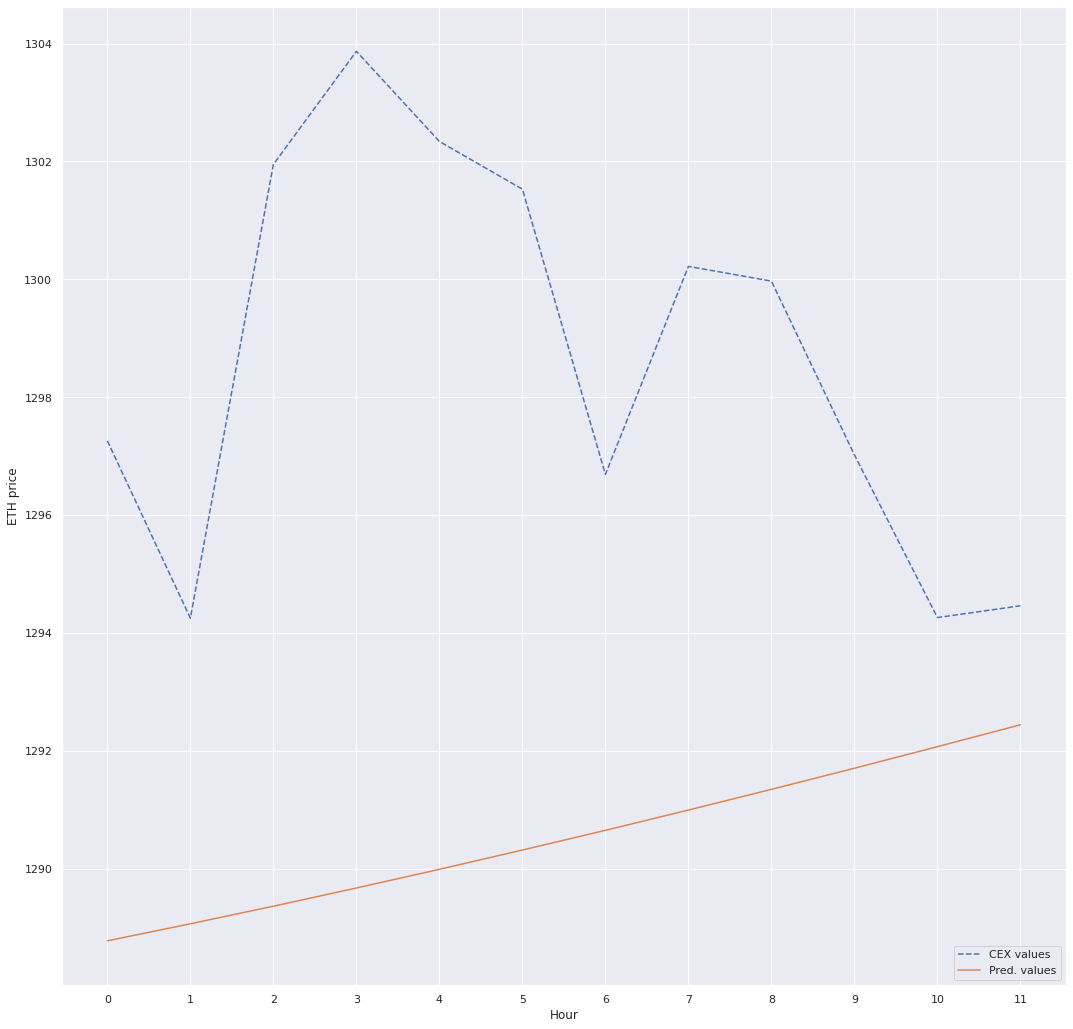

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/w0zeui8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/wzdm2gaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84435', 'data', 'file=/tmp/tmpmu0vbl24/w0zeui8c.json', 'init=/tmp/tmpmu0vbl24/wzdm2gaf.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelw5kyo5z2/prophet_model-20221212024122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.573581888816463e-06


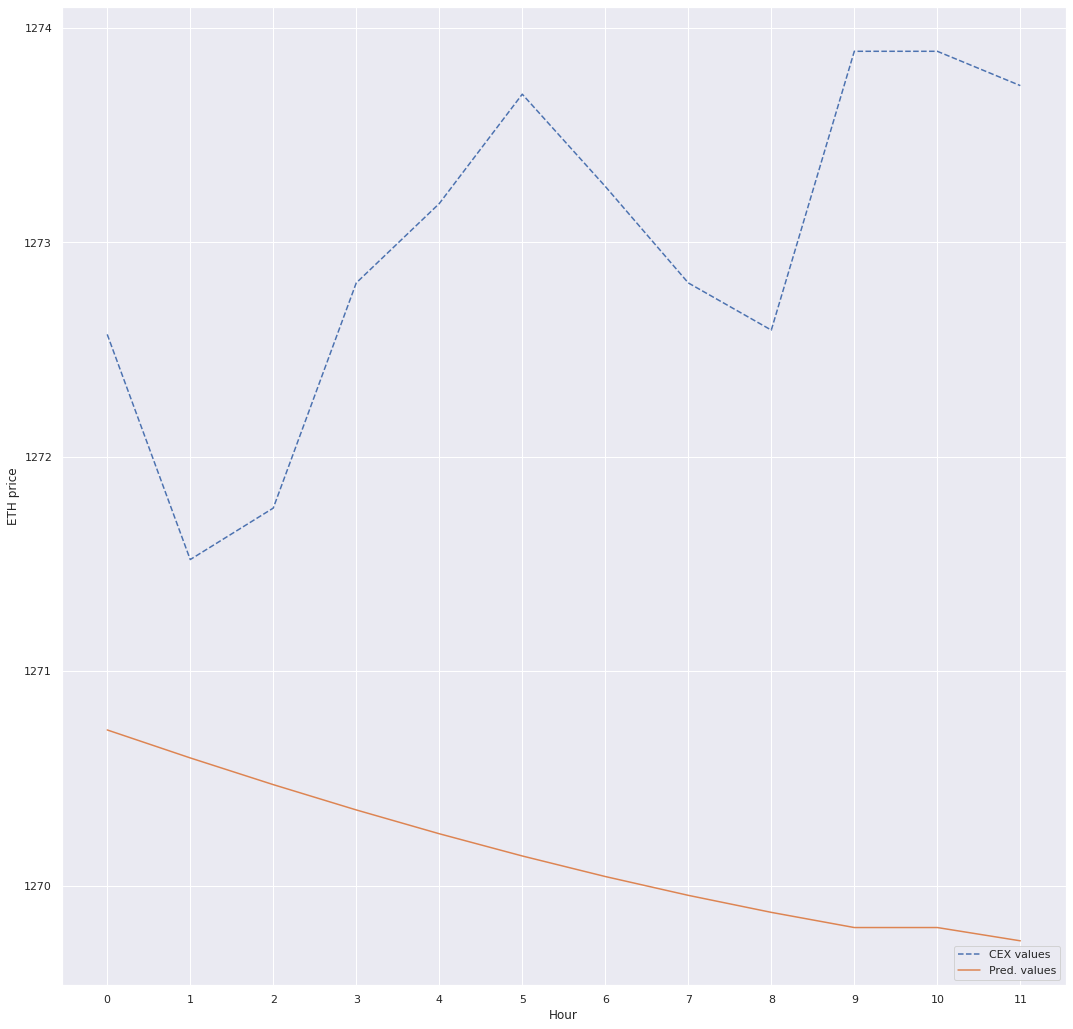

mean months nsme: 0.0008906621821174797


In [208]:
NSME_list = []

for i in range(len(months)-10, len(months)):
    w = months[i] 
    last_x_hours = 12
    # use the last 12 hours of testing set, all the previous data is used as training
    train_data = w.iloc[:-last_x_hours,:]
    test_data = w.iloc[-last_x_hours:,:]
    model = Prophet(daily_seasonality=True)  #weekly_seasonality=True,  # daily_seasonality=True
    model.fit(train_data)
    #Predict ETH values over the range of the test set
    forecast = model.predict(pd.DataFrame({"ds":test_data.ds}))
    pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()
    # now, we have predicted and actual values. Let's find error, and plot!
    cex_vals = test_data.y
    nmse = calc_nmse(cex_vals, pred_vals_test)
    print(f"NMSE = {nmse}")
    NSME_list.append(nmse)
    plot_prices(cex_vals, pred_vals_test,last_x_hours)
    
print("=" * 10)
print(f"mean months nsme: {np.mean(NSME_list)}")

In [126]:
data.iloc[-1000:].reset_index()['y']

0      1231.57
1      1231.83
2      1232.67
3      1233.12
4      1234.88
        ...   
995    1272.86
996    1272.79
997    1271.62
998    1271.62
999    1272.30
Name: y, Length: 1000, dtype: float64

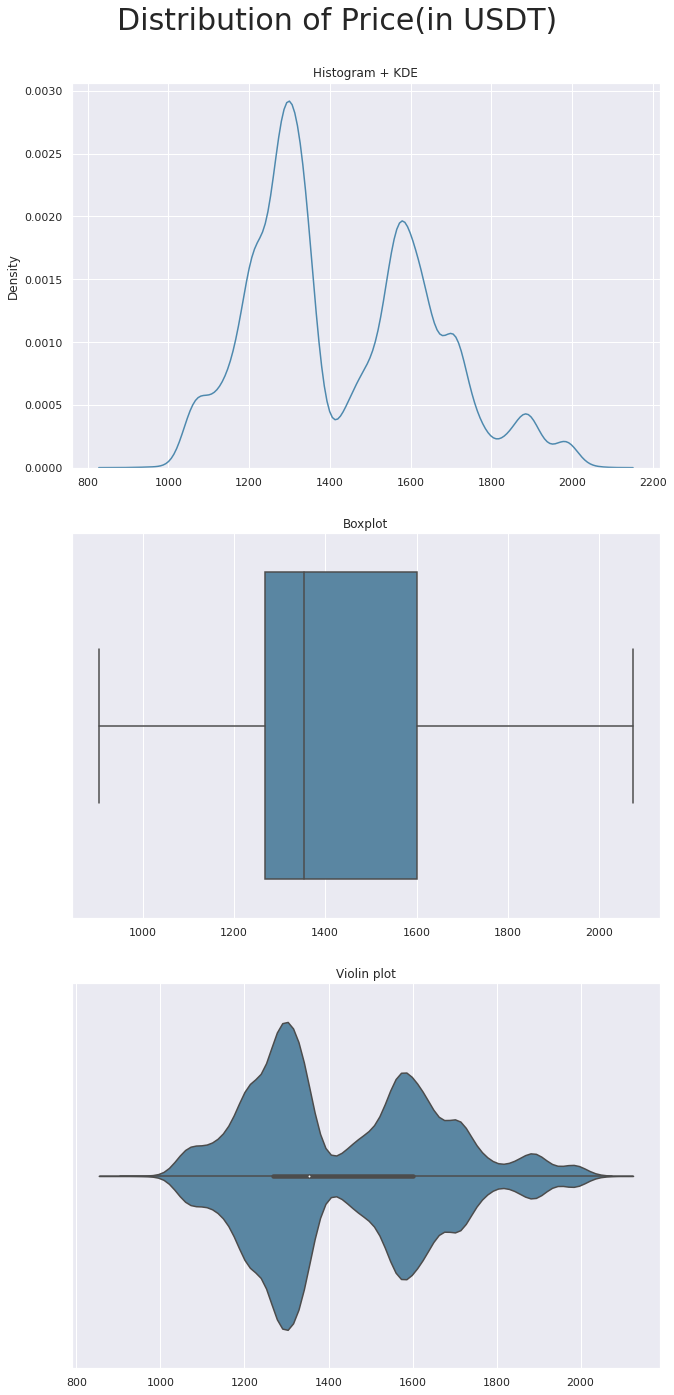

In [10]:
triple_plot(data.reset_index()['y'],'Distribution of Price(in USDT)',custom_colors[0])

In [78]:
# export retrieved data to prevent rate limiting issues
fp = "binance_data_21_5_22.csv"
data.to_csv(fp,index=False)
test_data = pd.read_csv(fp)
test_data.head()

ds        y
0  2022-05-21 00:00:00  1963.41
1  2022-05-21 01:00:00  1951.93
2  2022-05-21 02:00:00  1959.40
3  2022-05-21 03:00:00  1967.75
4  2022-05-21 04:00:00  1965.17

In [11]:

# Best one so far perhaps
num_weeks = 5
last_x_hours = 12
start_hour = 24 * 7 * num_weeks


# use the last 12 hours of testing set, all the previous data is used as training
train_data = data.iloc[-last_x_hours-start_hour:-last_x_hours,:]
test_data = data.iloc[-last_x_hours:,:]


In [13]:
model = Prophet()  #weekly_seasonality=True,  # daily_seasonality=True
model.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/j6unmzy0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ojrlp3fv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81522', 'data', 'file=/tmp/tmpmu0vbl24/j6unmzy0.json', 'init=/tmp/tmpmu0vbl24/ojrlp3fv.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model0n5j3ola/prophet_model-20221211235259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:52:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [14]:
#Observe ETH Predictions over train set
forecast = model.predict(pd.DataFrame({"ds":train_data.ds}))
pred_vals_train = forecast.set_index('ds')['yhat'].to_numpy()


pred_vals_train: 840 840
NMSE = 3.024937676592406e-06


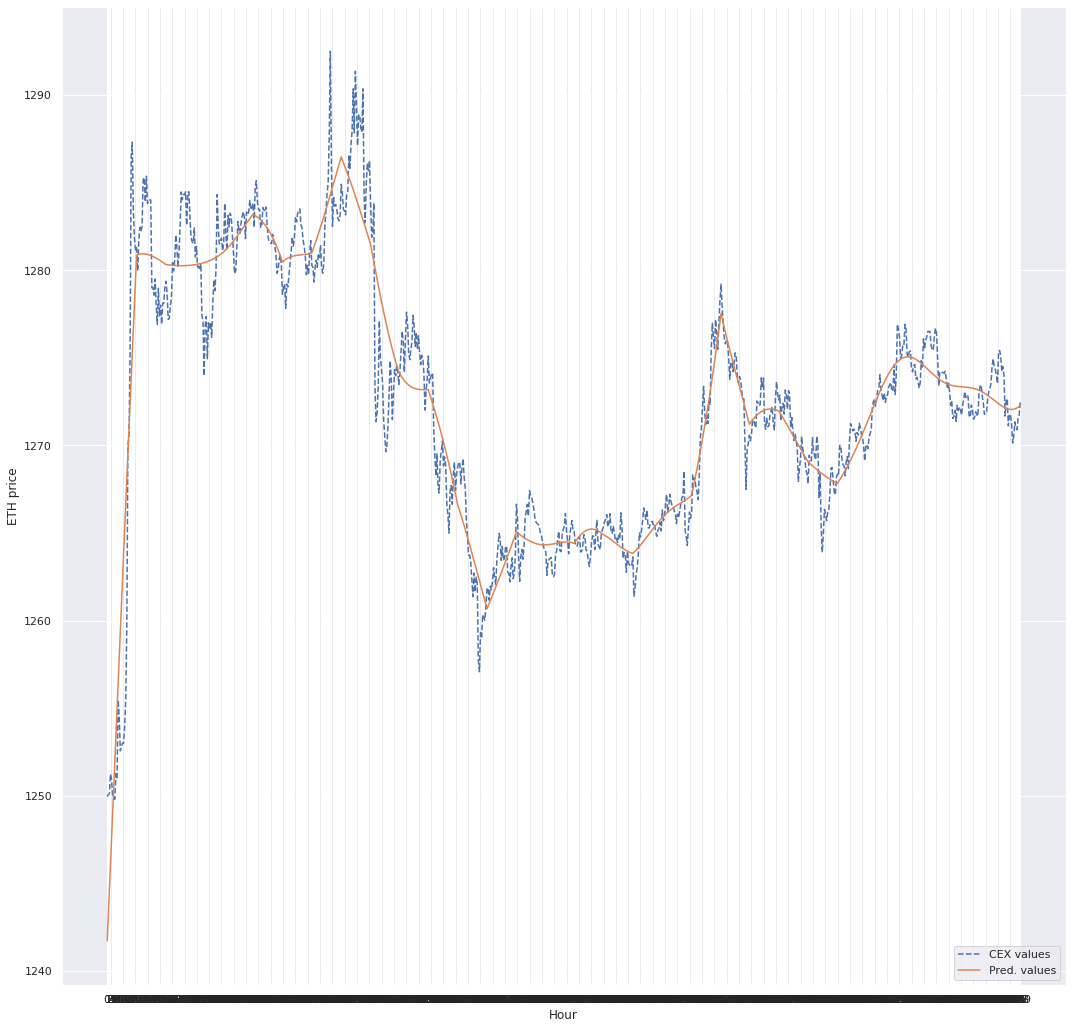

In [15]:
cex_vals = train_data.y
print(f"pred_vals_train: {len(pred_vals_train)} {len(cex_vals)}")
nmse = calc_nmse(cex_vals, pred_vals_train)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_train,len(pred_vals_train))

In [16]:
#Predict ETH values over the range of the test set
forecast = model.predict(pd.DataFrame({"ds":test_data.ds}))
pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()

NMSE = 1.9676399416191274e-07


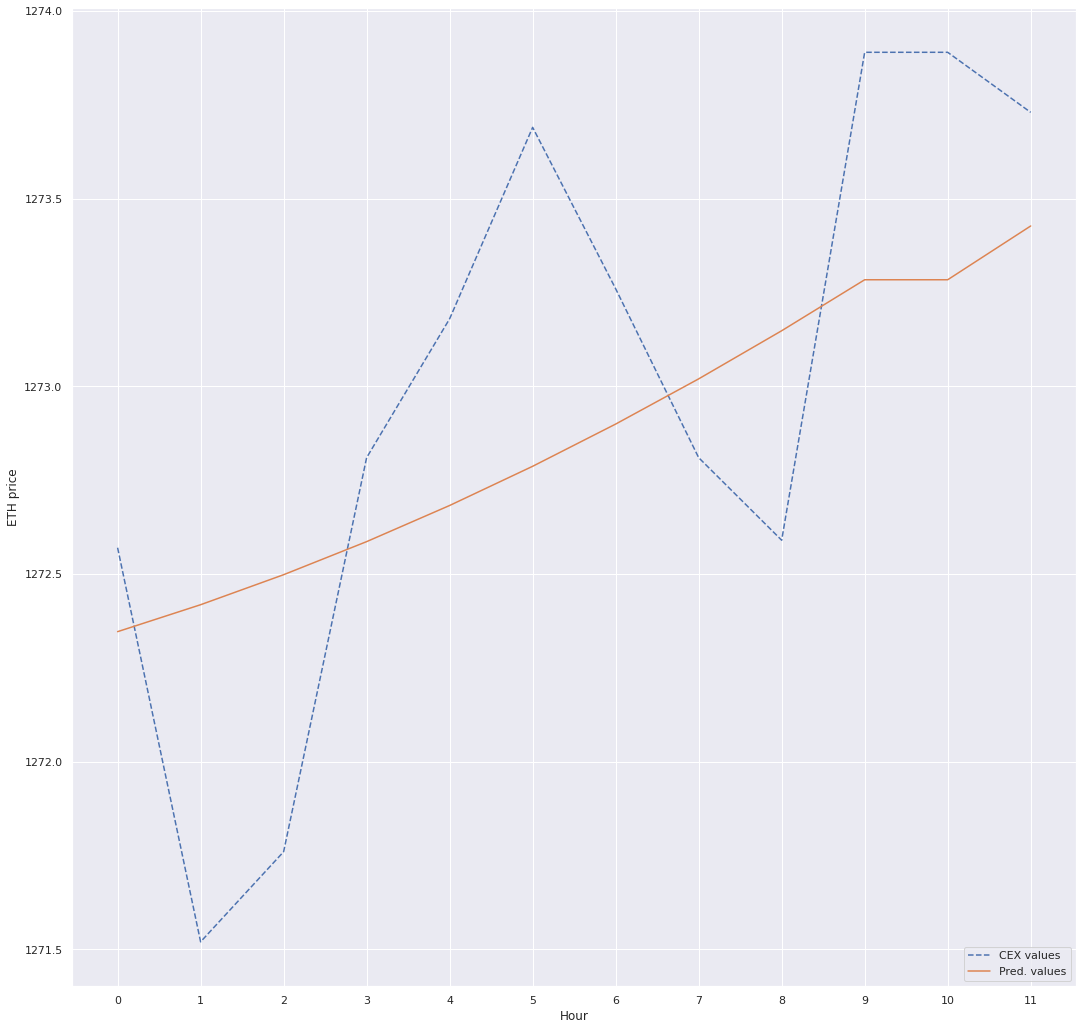

In [20]:
# now, we have predicted and actual values. Let's find error, and plot!
cex_vals = test_data.y
nmse = calc_nmse(cex_vals, pred_vals_test)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_test,last_x_hours)

In [18]:
# fit model with all the available data
model = Prophet()
model.fit(data)

# generate dates for prediction (12 hours ahead of the latest datapoint in the data time)
future_dates = model.make_future_dataframe(periods=12, freq="h", include_history=False)

# predcit eth values on future_dates
forecast = model.predict(future_dates)
pred_vals = forecast.set_index('ds')['yhat'].to_numpy()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/hvtzvuvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/vl431un5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47830', 'data', 'file=/tmp/tmpmu0vbl24/hvtzvuvu.json', 'init=/tmp/tmpmu0vbl24/vl431un5.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelctwn6_te/prophet_model-20221211235322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


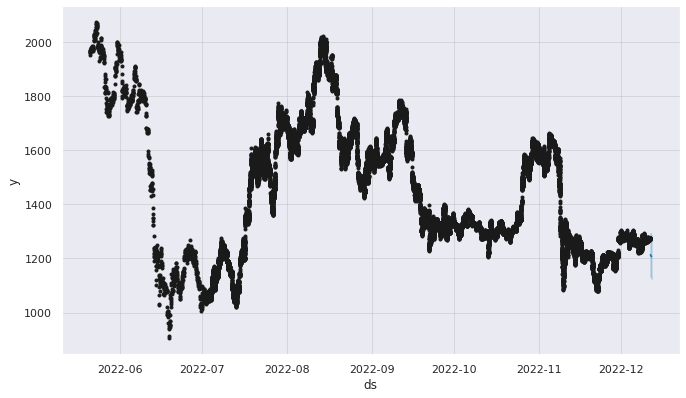

In [27]:
fig1 = model.plot(forecast)

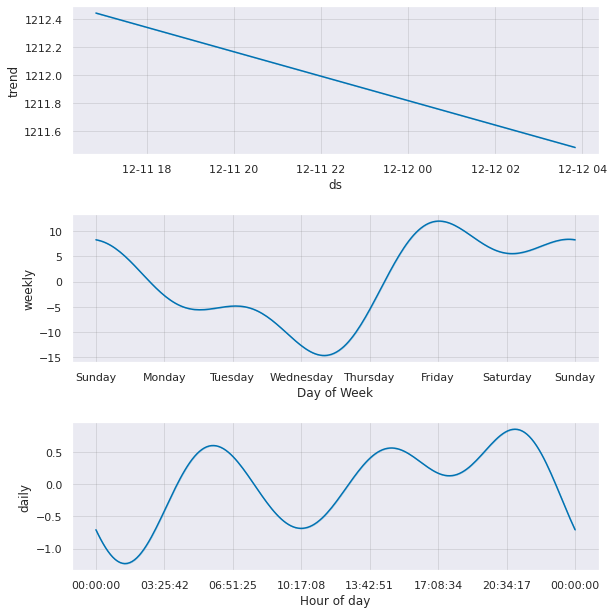

In [26]:
fig1 = model.plot_components(forecast)

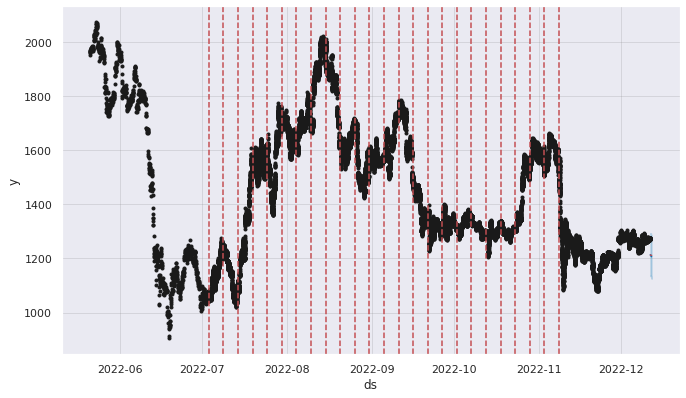

In [92]:


fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)



## Try mutiple regressors

In [132]:
num_lags = 5

multi_prop_data = pd.concat([data['y'].shift(i).rename(f"{i}_shift") for i in range(0,num_lags)],axis=1).dropna()#.values

In [133]:
multi_prop_data.rename(columns={"0_shift":"y"},inplace=True)

In [134]:
multi_prop_data["ds"] = data["ds"]

In [160]:
num_weeks = 0.1# 5 results in overfit
last_x_hours = 12
start_hour = math.ceil(24 * 7 * num_weeks)


# use the last 12 hours of testing set, all the previous data is used as training
multi_train_data = multi_prop_data.iloc[-last_x_hours-start_hour:-last_x_hours,:]
multi_test_data = multi_prop_data.iloc[-last_x_hours:,:]


In [161]:
# Instantitae new prophet model
pro_regressor= Prophet(weekly_seasonality=True)
for i in range(1,num_lags):
    pro_regressor.add_regressor(f"{i}_shift")

In [162]:
pro_regressor.fit(multi_train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/54alv7so.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/pt_3k9l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36071', 'data', 'file=/tmp/tmpmu0vbl24/54alv7so.json', 'init=/tmp/tmpmu0vbl24/pt_3k9l8.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelby90c_5g/prophet_model-20221212013845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:48 - cmdstanpy - INFO 

In [163]:
#Observe ETH Predictions over train set
forecast = pro_regressor.predict(multi_train_data)
pred_vals_train = forecast.set_index('ds')['yhat'].to_numpy()


pred_vals_train: 17 17
NMSE = 7.153513052871918e-12


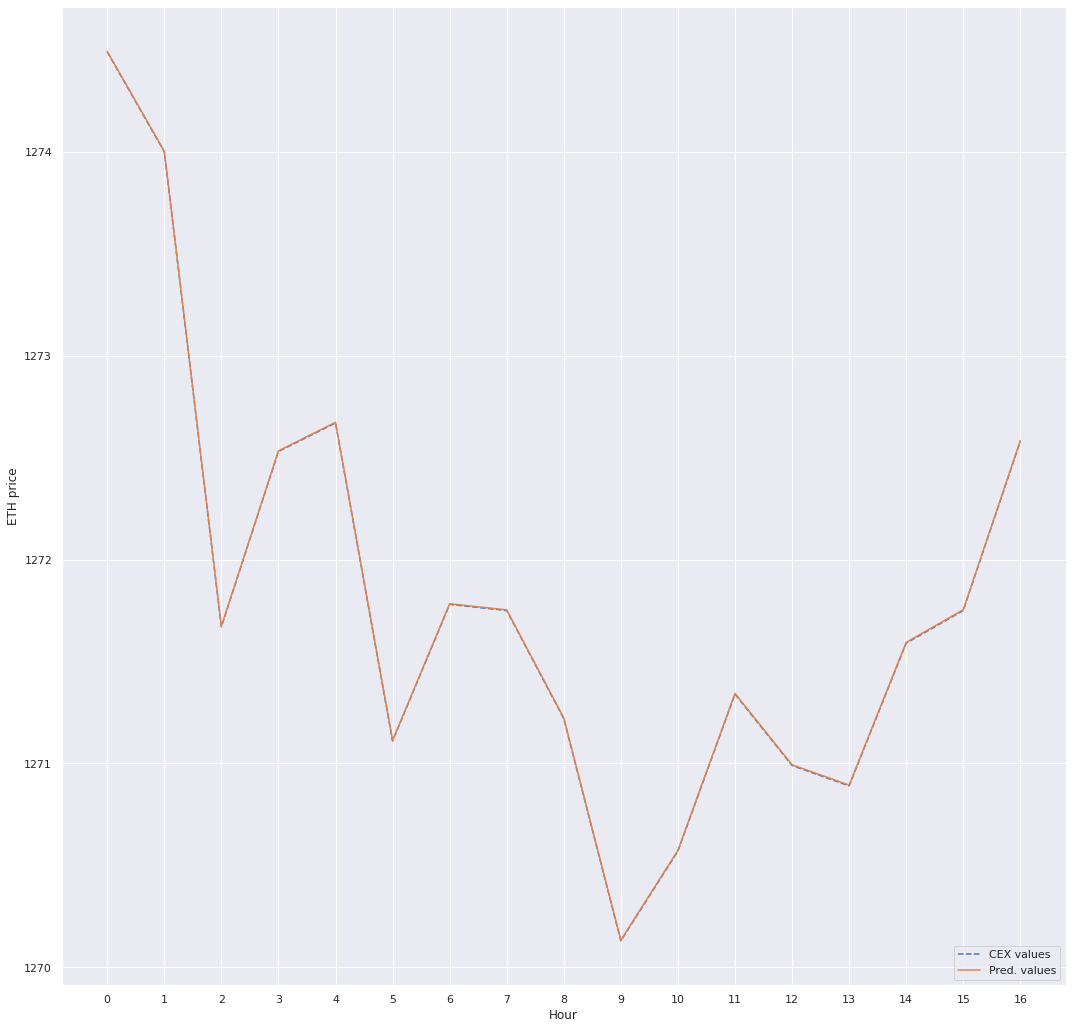

In [164]:
cex_vals = multi_train_data.y
print(f"pred_vals_train: {len(pred_vals_train)} {len(cex_vals)}")
nmse = calc_nmse(cex_vals, pred_vals_train)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_train,len(pred_vals_train))

In [165]:
#Predict ETH values over the range of the test set
forecast = model.predict(multi_test_data)
pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()

NMSE = 0.00206794871489184


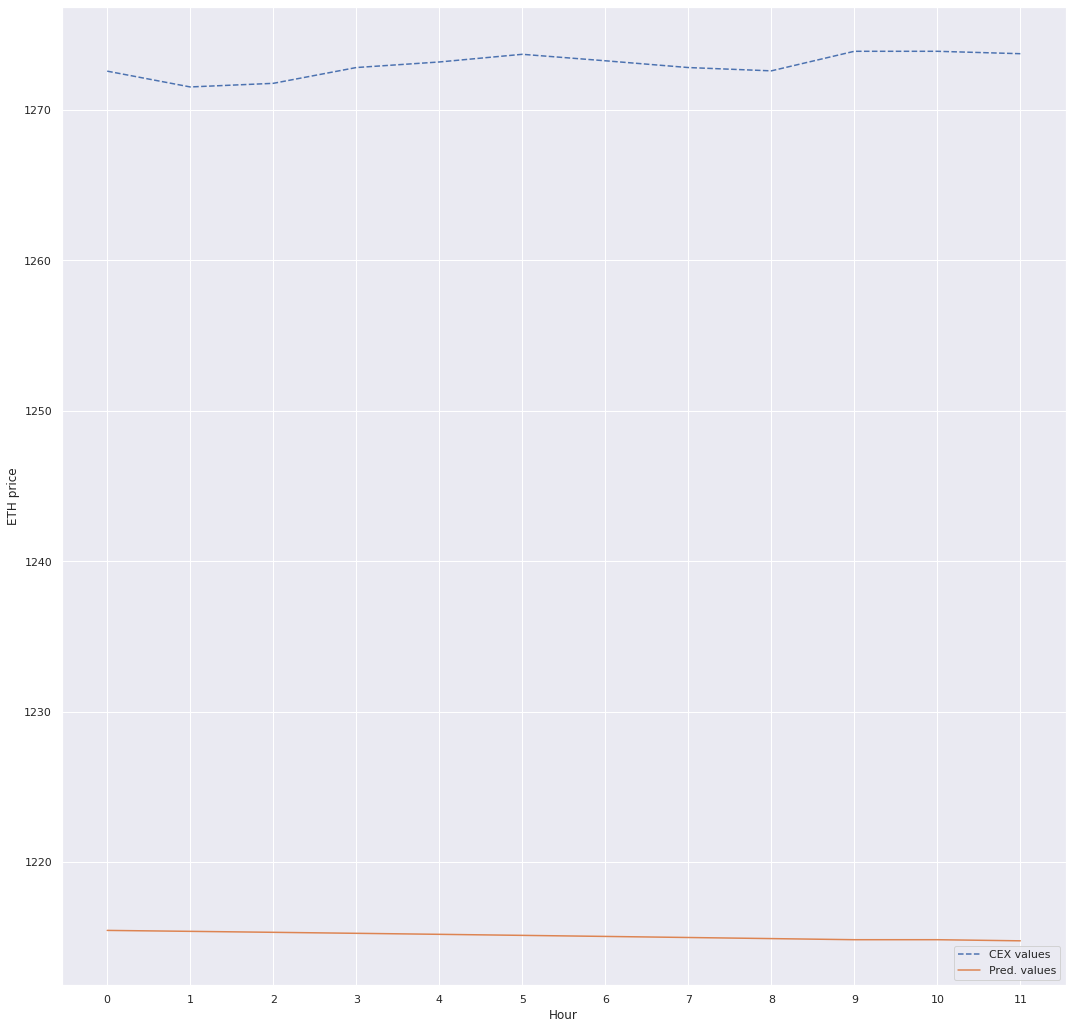

In [166]:
# now, we have predicted and actual values. Let's find error, and plot!
cex_vals = multi_test_data.y
nmse = calc_nmse(cex_vals, pred_vals_test)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_test,last_x_hours)

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


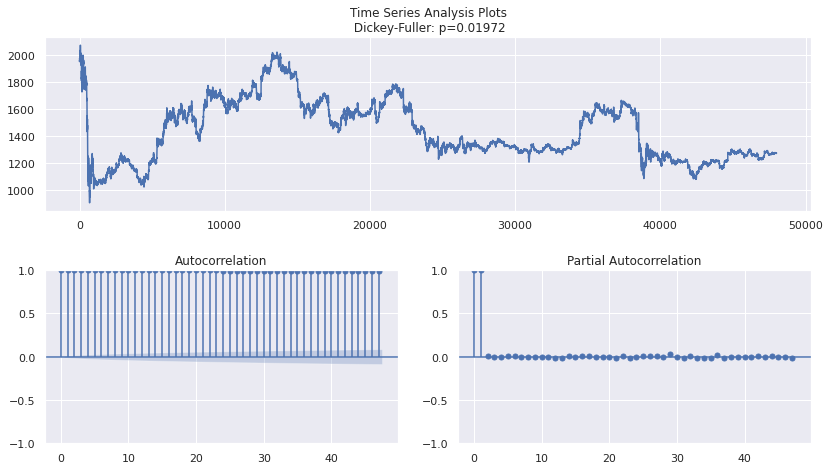

In [177]:
tsplot(data['y'])
# shows that whatever data i trained it on, it was highly auto correlated. So including the lags may have caused significant issues

# Try prophet with ochlv

## Seems like best so far,despite similar mean NMSE


Reasons:
1. predicted sometimes follows the actual trend
2. Makes use of the OCHLV values, which are traditionally used to show some signals


Flaws:
1. Has trend inversions for some weeks:(

In [250]:
for idx,x in enumerate(cex_x):
    cur = cex_x[idx][0]
#     print(cex_x[idx][0])
#     print(type(cur))
    if(isinstance(cur, datetime.datetime)):
        continue
    cex_x[idx][0] = to_datetime(cex_x[idx][0]/1000)

ochlv_data = pd.DataFrame(data = cex_x, columns=["ds","open","y","high","low","volume"])
# ochlv_data.astype({'ds': 'datetime64[ns]'})
ochlv_data.head()

ds     open        y     high      low      volume
0 2022-05-21 00:00:00  1959.08  1973.95  1956.14  1963.41  14232.7649
1 2022-05-21 01:00:00  1963.41  1965.41  1937.36  1951.93  19711.0810
2 2022-05-21 02:00:00  1951.92  1962.57  1944.29  1959.40   8416.9029
3 2022-05-21 03:00:00  1959.39  1969.95  1949.66  1967.75   9089.2800
4 2022-05-21 04:00:00  1967.74  1969.43  1962.00  1965.17   6704.3441

In [252]:
num_weeks = 2# 5 results in overfit
last_x_hours = 12
start_hour = math.ceil(24 * 7 * num_weeks)


# use the last 12 hours of testing set, all the previous data is used as training
ochlv_train_data = ochlv_data.iloc[-last_x_hours-start_hour:-last_x_hours,:]
ochlv_test_data = ochlv_data.iloc[-last_x_hours:,:]

In [253]:


pro_regressor_5= Prophet()
pro_regressor_5.add_regressor('open')
pro_regressor_5.add_regressor('high')
pro_regressor_5.add_regressor('low')
pro_regressor_5.add_regressor('volume')



In [255]:
pro_regressor_5.fit(ochlv_train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/1pz_xiyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/05hdklby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24461', 'data', 'file=/tmp/tmpmu0vbl24/1pz_xiyn.json', 'init=/tmp/tmpmu0vbl24/05hdklby.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model3kdwhq1t/prophet_model-20221212031346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:13:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03

In [257]:
#Predict ETH values over the range of the test set
forecast = pro_regressor_5.predict(ochlv_test_data)
pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()

NMSE = 3.962773082471459e-08


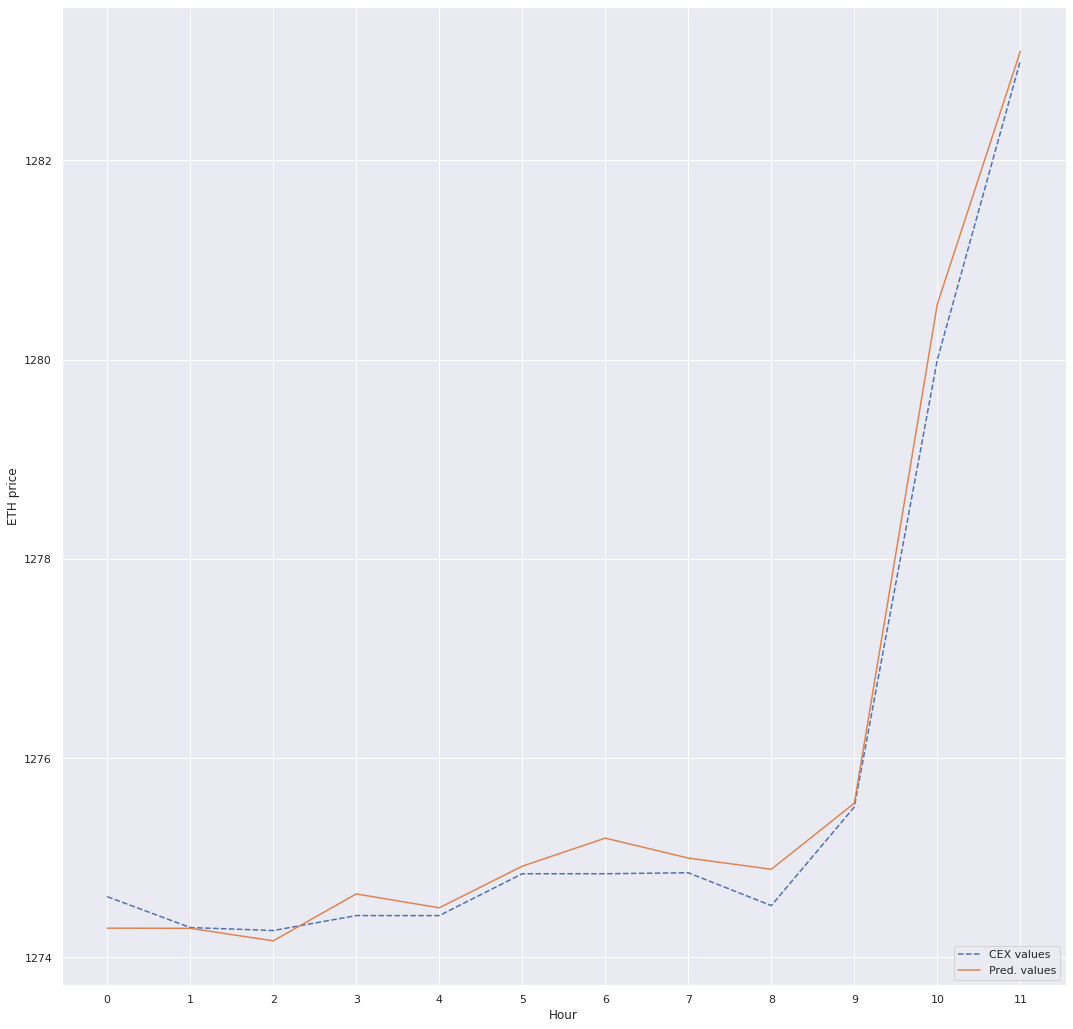

In [258]:
# now, we have predicted and actual values. Let's find error, and plot!
cex_vals = ochlv_test_data.y
nmse = calc_nmse(cex_vals, pred_vals_test)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_test,last_x_hours)

In [259]:

ochlv_months = [g for n, g in ochlv_data.groupby(pd.Grouper(key='ds',freq='M'))]

In [262]:
ochlv_months.head()

AttributeError: 'list' object has no attribute 'head'

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/bcm85kix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/glt57vji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40624', 'data', 'file=/tmp/tmpmu0vbl24/bcm85kix.json', 'init=/tmp/tmpmu0vbl24/glt57vji.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelp6_n_eiy/prophet_model-20221212034923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:23 - cmdstanpy - IN

-7
NMSE = 0.002254204268408172


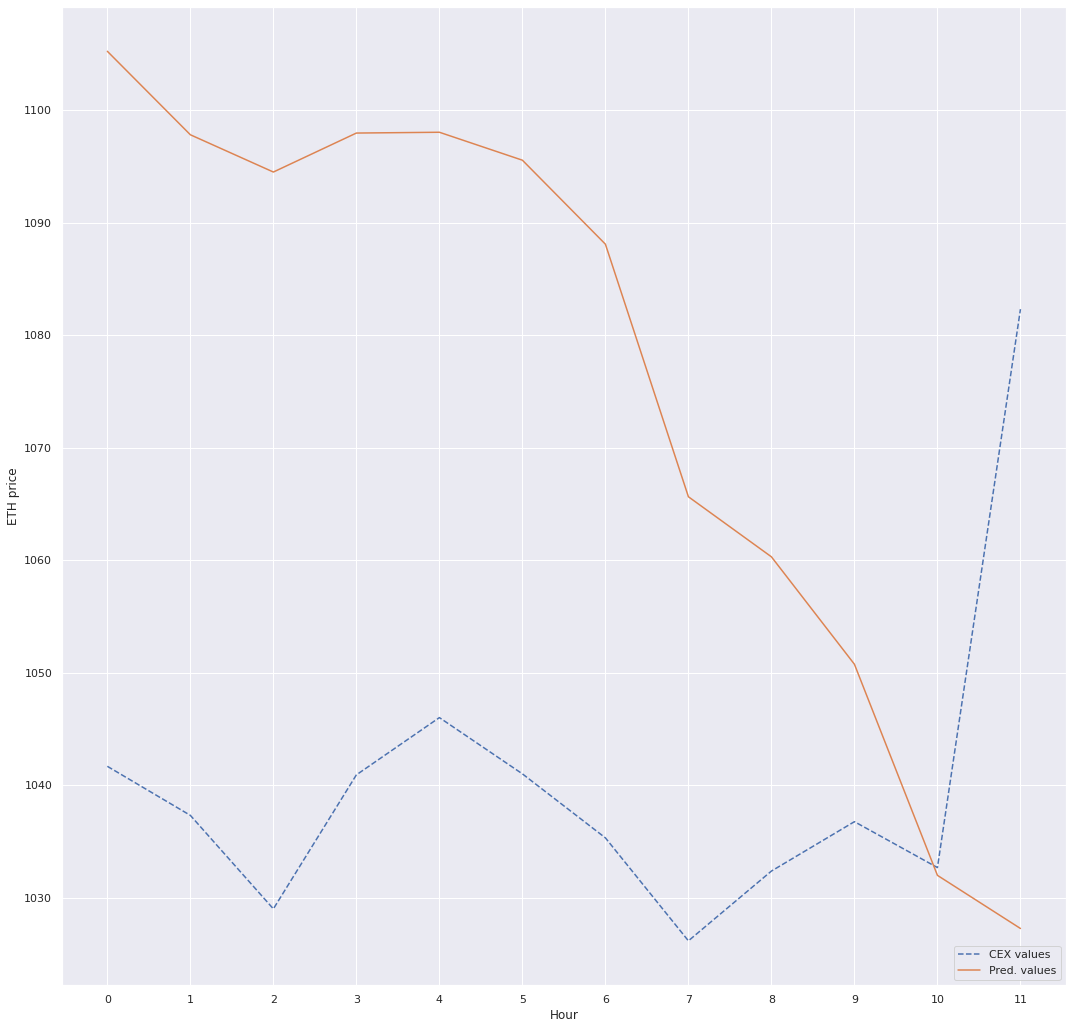

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/2yf3erbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9gzk8f4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59129', 'data', 'file=/tmp/tmpmu0vbl24/2yf3erbk.json', 'init=/tmp/tmpmu0vbl24/9gzk8f4b.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_uyozrkm/prophet_model-20221212034923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:23 - cmdstanpy - IN

-6


03:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 7.322509610401012e-05


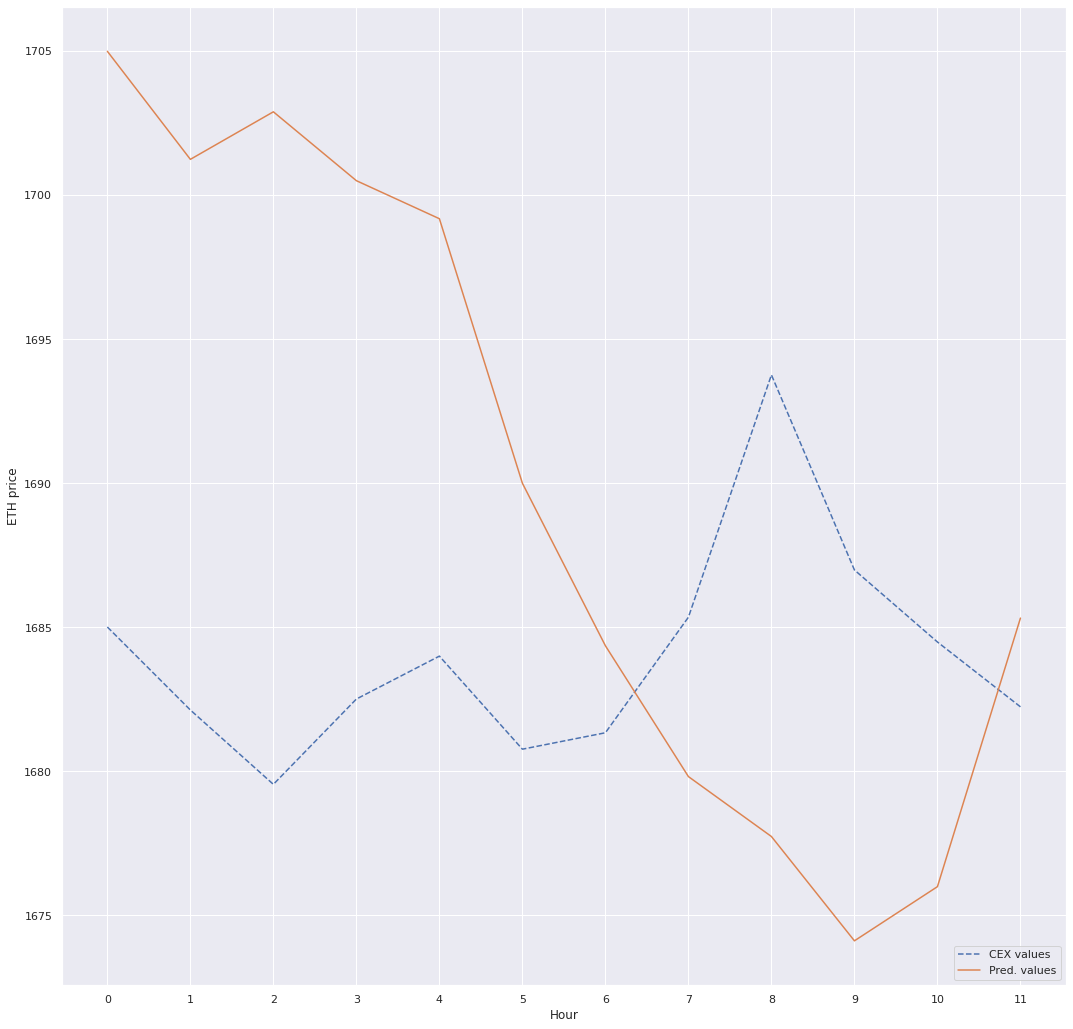

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/0zlrw867.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9skrdf9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57452', 'data', 'file=/tmp/tmpmu0vbl24/0zlrw867.json', 'init=/tmp/tmpmu0vbl24/9skrdf9u.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelaxswovc6/prophet_model-20221212034924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:24 - cmdstanpy - IN

-5


03:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 8.088392380458427e-05


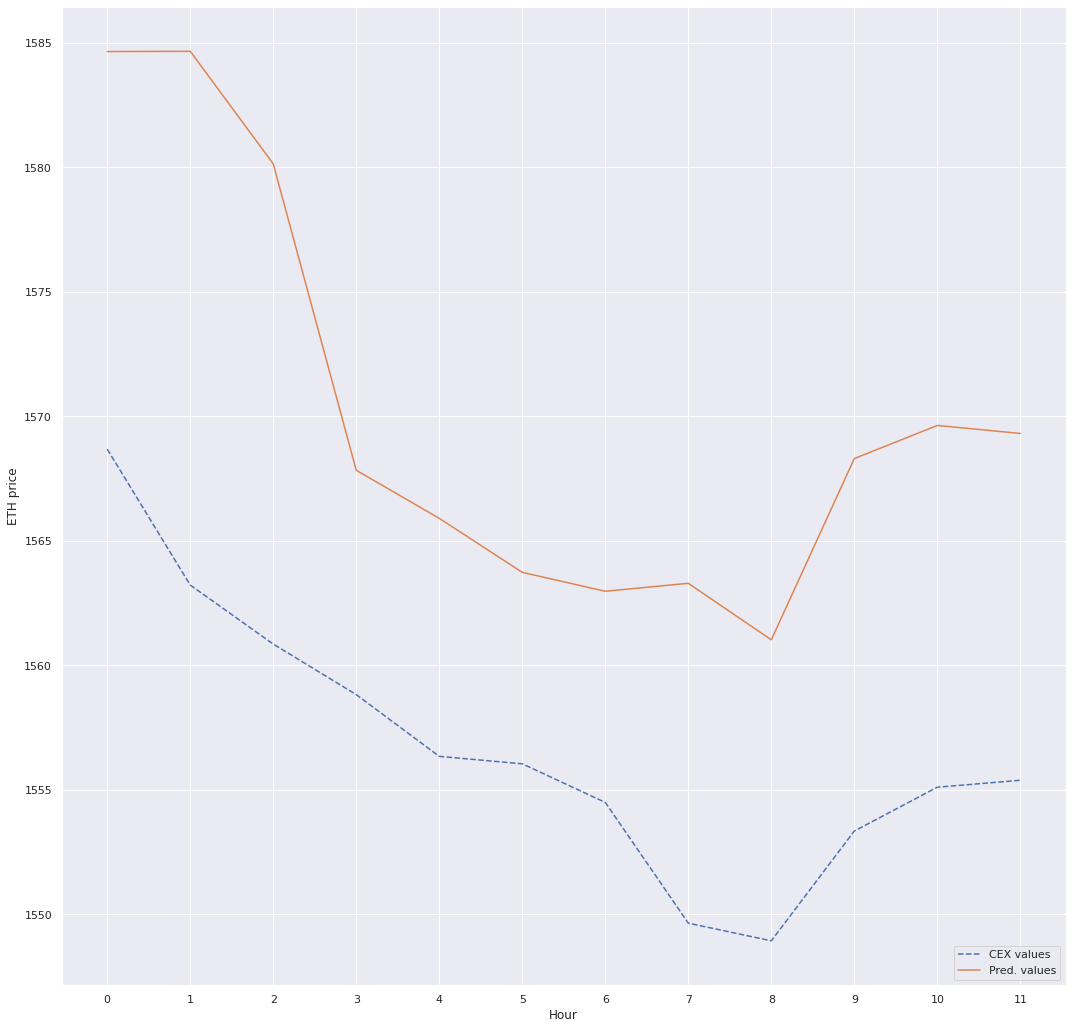

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/nw_znthb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/a__faapq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10309', 'data', 'file=/tmp/tmpmu0vbl24/nw_znthb.json', 'init=/tmp/tmpmu0vbl24/a__faapq.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelkmtvlrw6/prophet_model-20221212034924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:24 - cmdstanpy - IN

-4


03:49:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.988298852168005e-06


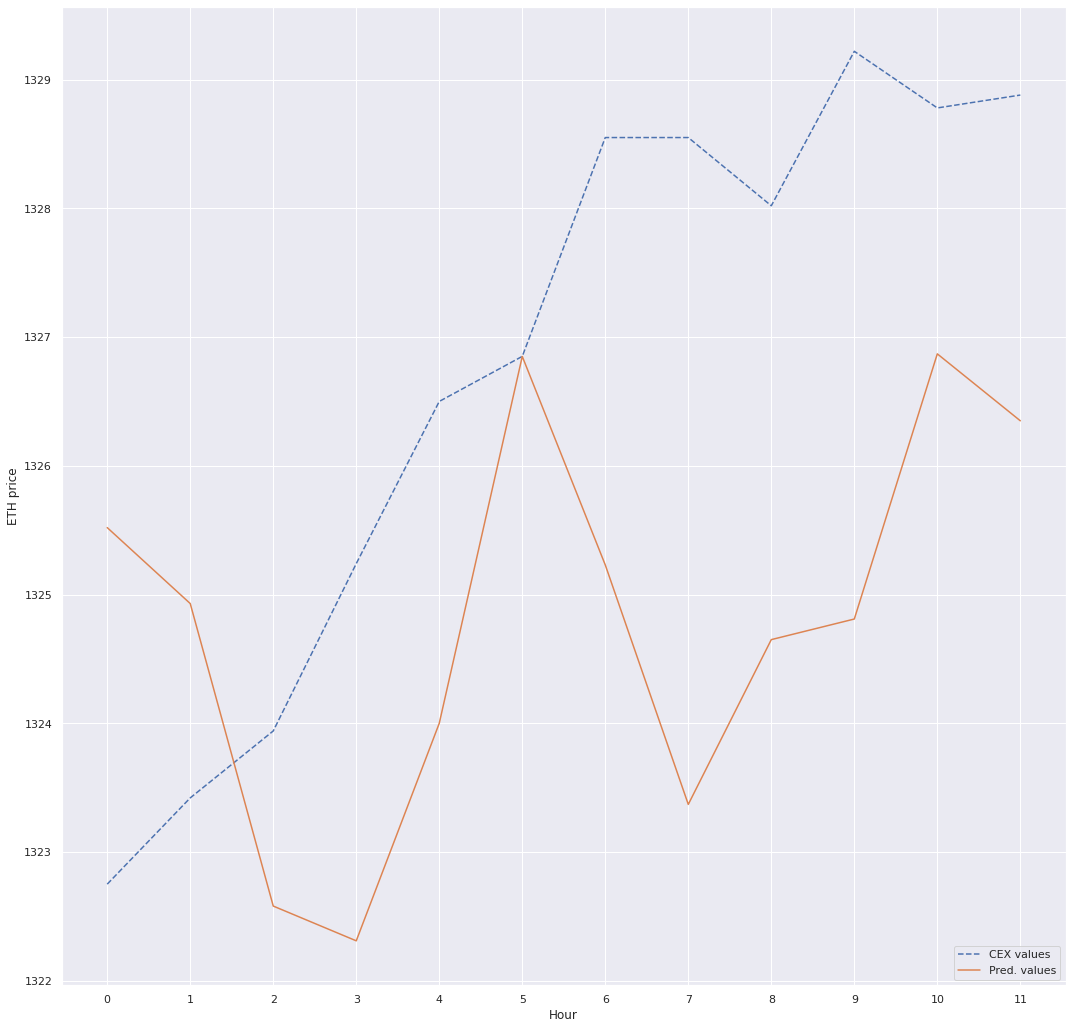

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/p6i_wtlb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/y43w2rtr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7782', 'data', 'file=/tmp/tmpmu0vbl24/p6i_wtlb.json', 'init=/tmp/tmpmu0vbl24/y43w2rtr.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelotymu704/prophet_model-20221212034925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:25 - cmdstanpy - INF

-3
NMSE = 1.5380615095318943e-05


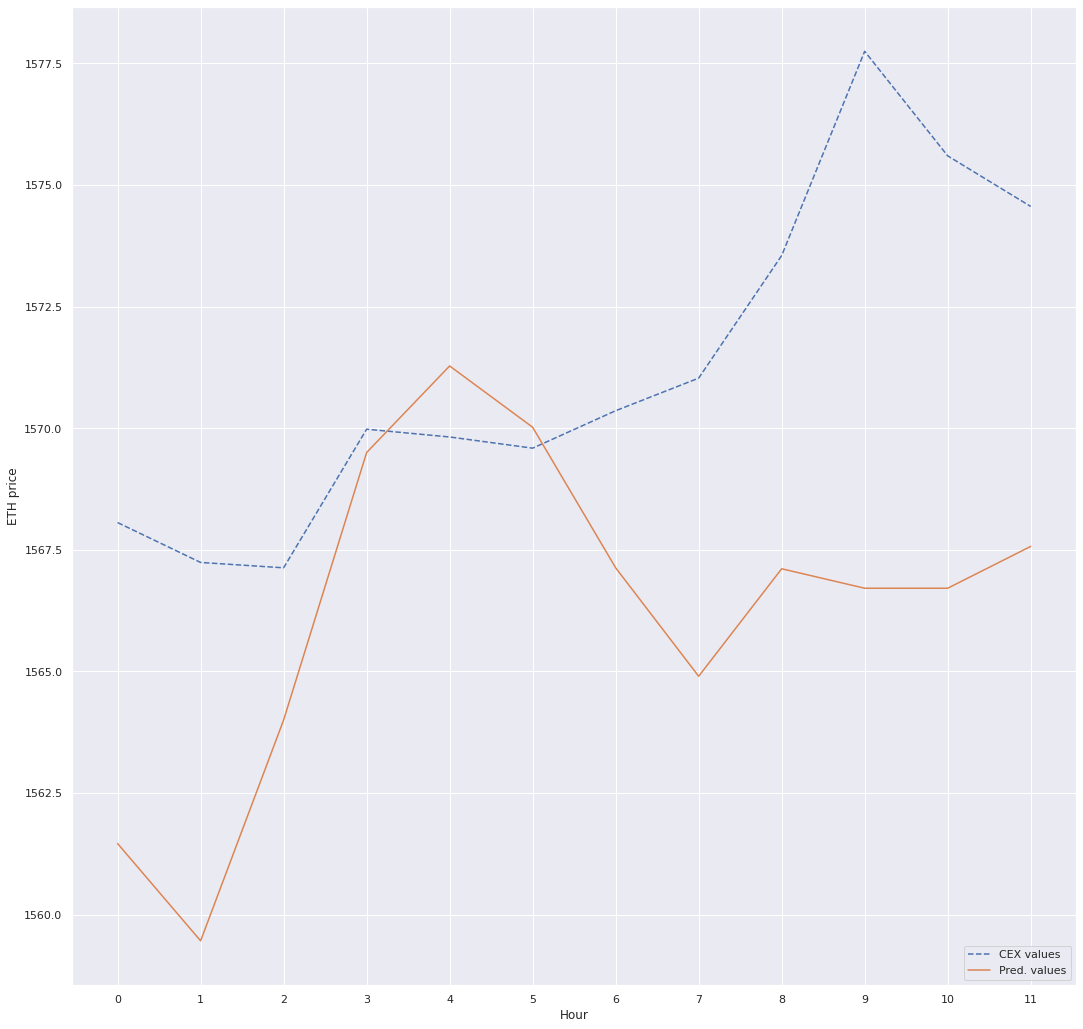

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/guh3qt78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/hjlx9lxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63588', 'data', 'file=/tmp/tmpmu0vbl24/guh3qt78.json', 'init=/tmp/tmpmu0vbl24/hjlx9lxr.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelw5mhft7y/prophet_model-20221212034926.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:26 - cmdstanpy - IN

-2


03:49:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 3.4881888518597646e-05


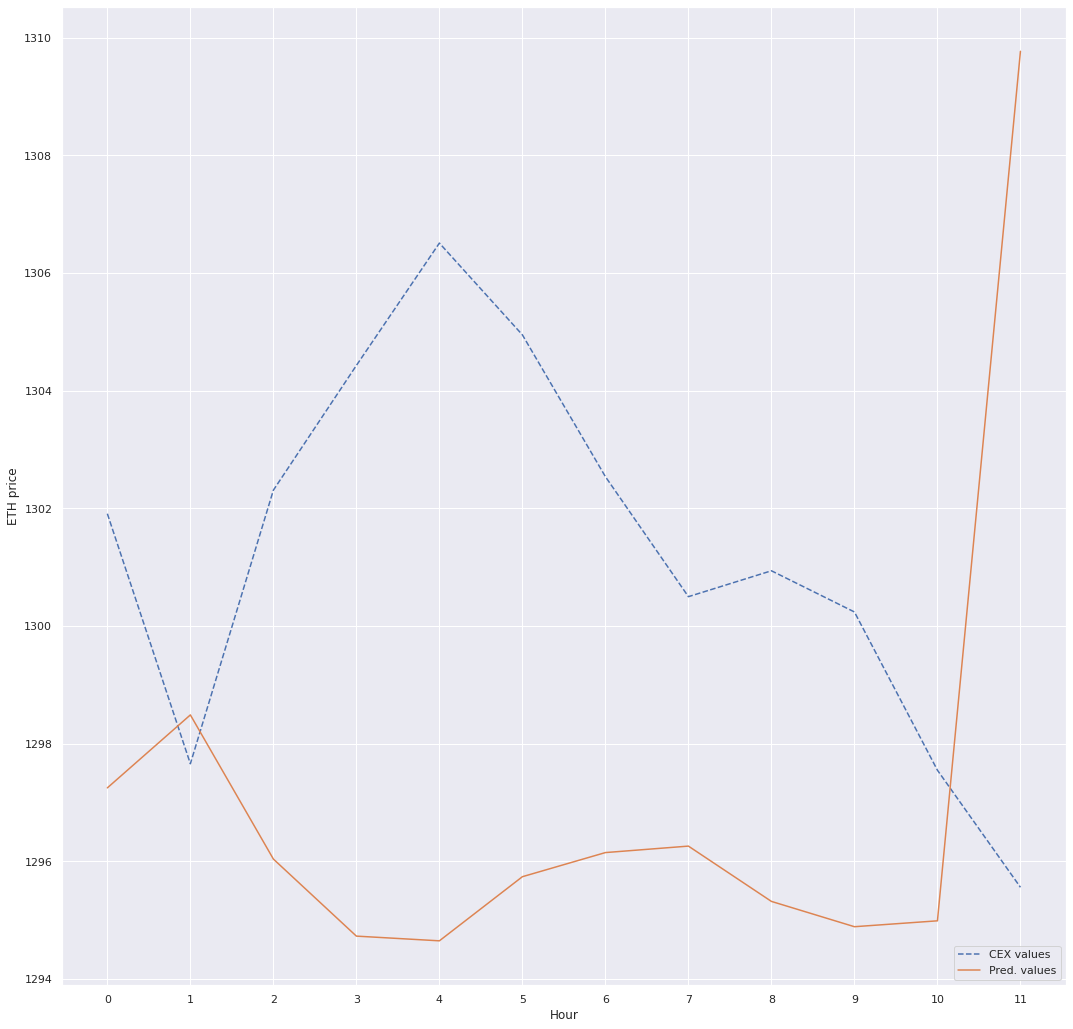

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/jsgopvxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kjlr6zcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2620', 'data', 'file=/tmp/tmpmu0vbl24/jsgopvxc.json', 'init=/tmp/tmpmu0vbl24/kjlr6zcl.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model70d8q23_/prophet_model-20221212034927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:27 - cmdstanpy - INF

-1


03:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.705873761052534e-06


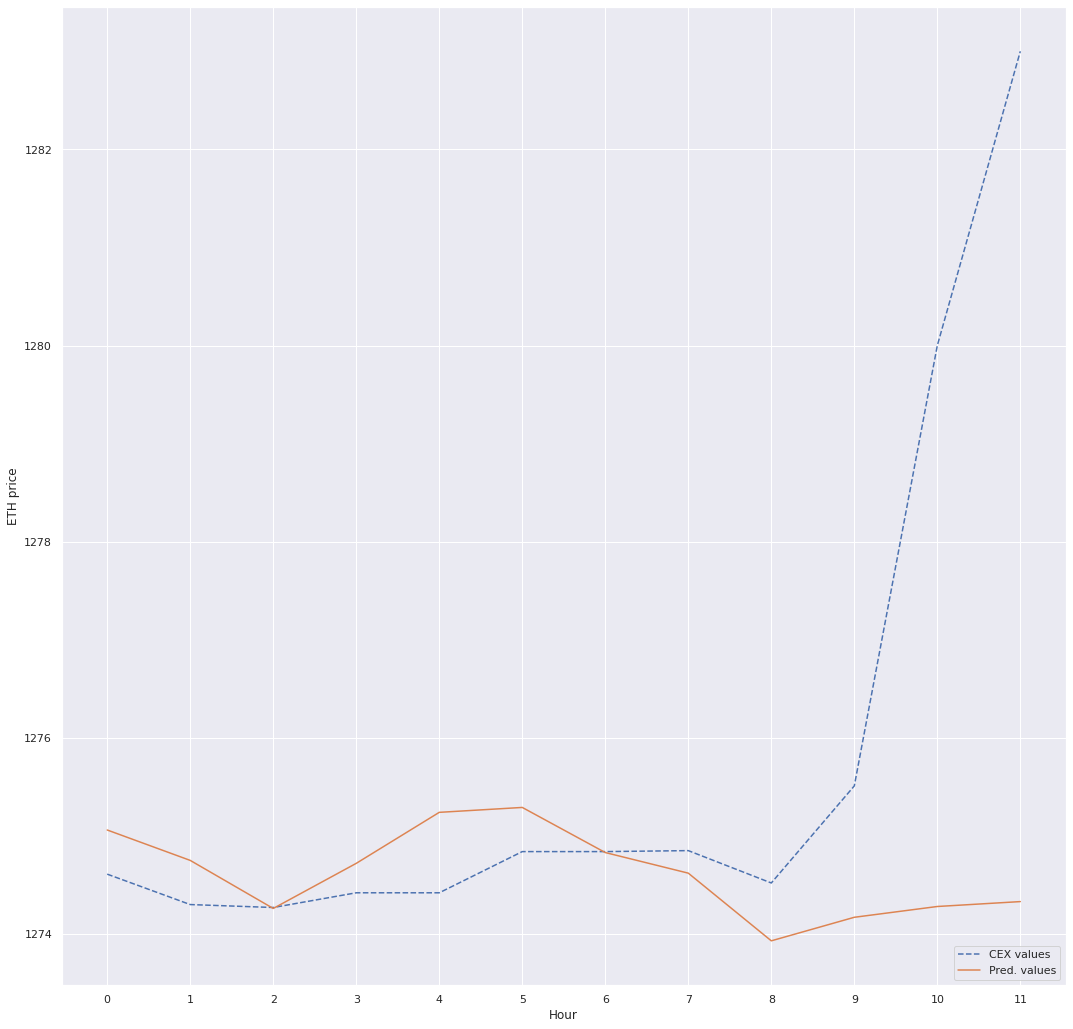

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/150p0ufj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/d77brtd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1447', 'data', 'file=/tmp/tmpmu0vbl24/150p0ufj.json', 'init=/tmp/tmpmu0vbl24/d77brtd4.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modeltqqqx7al/prophet_model-20221212034928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:28 - cmdstanpy - INF

0


03:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.00012849751865263398


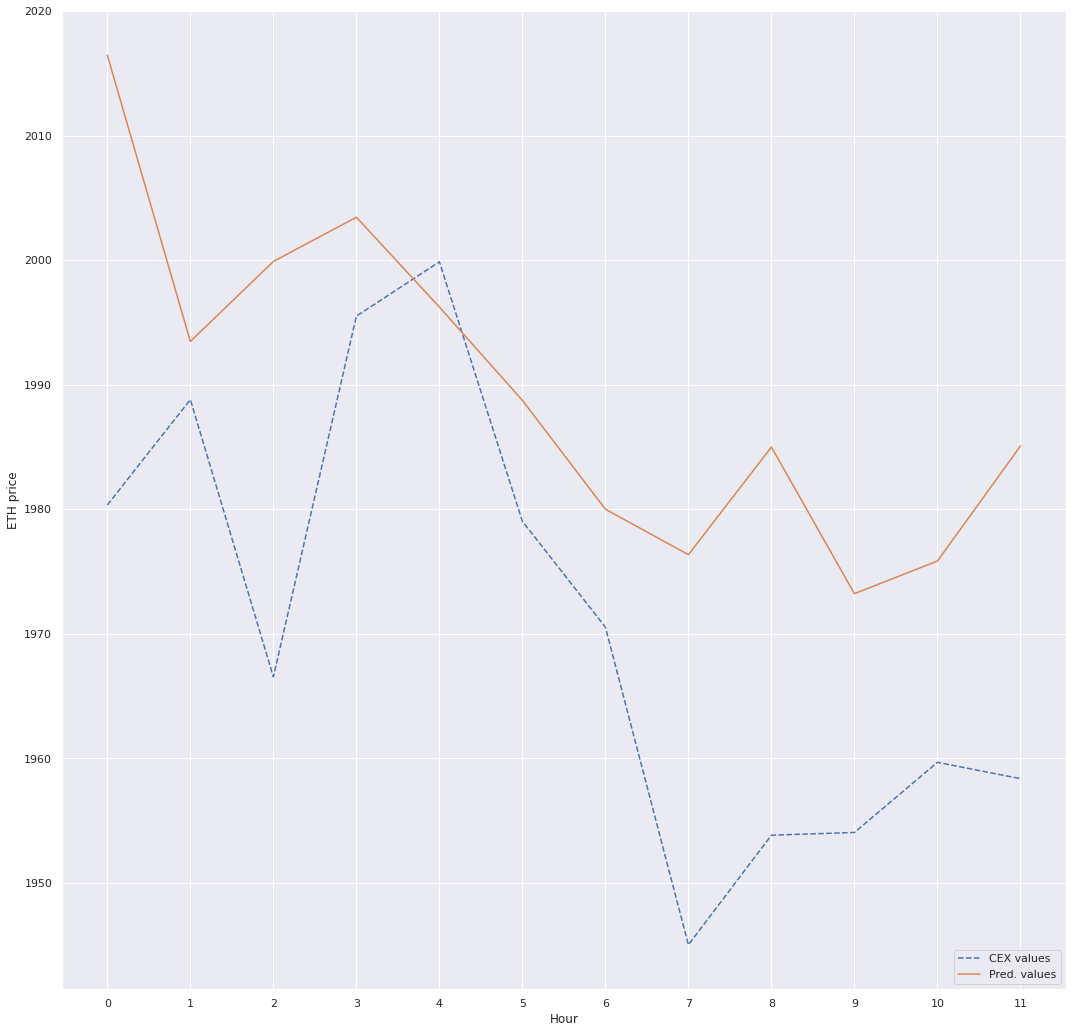

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/cw9_s1_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/t6rc50w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12926', 'data', 'file=/tmp/tmpmu0vbl24/cw9_s1_a.json', 'init=/tmp/tmpmu0vbl24/t6rc50w8.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelvwylaelj/prophet_model-20221212034928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:28 - cmdstanpy - IN

1
NMSE = 0.002254204268408172


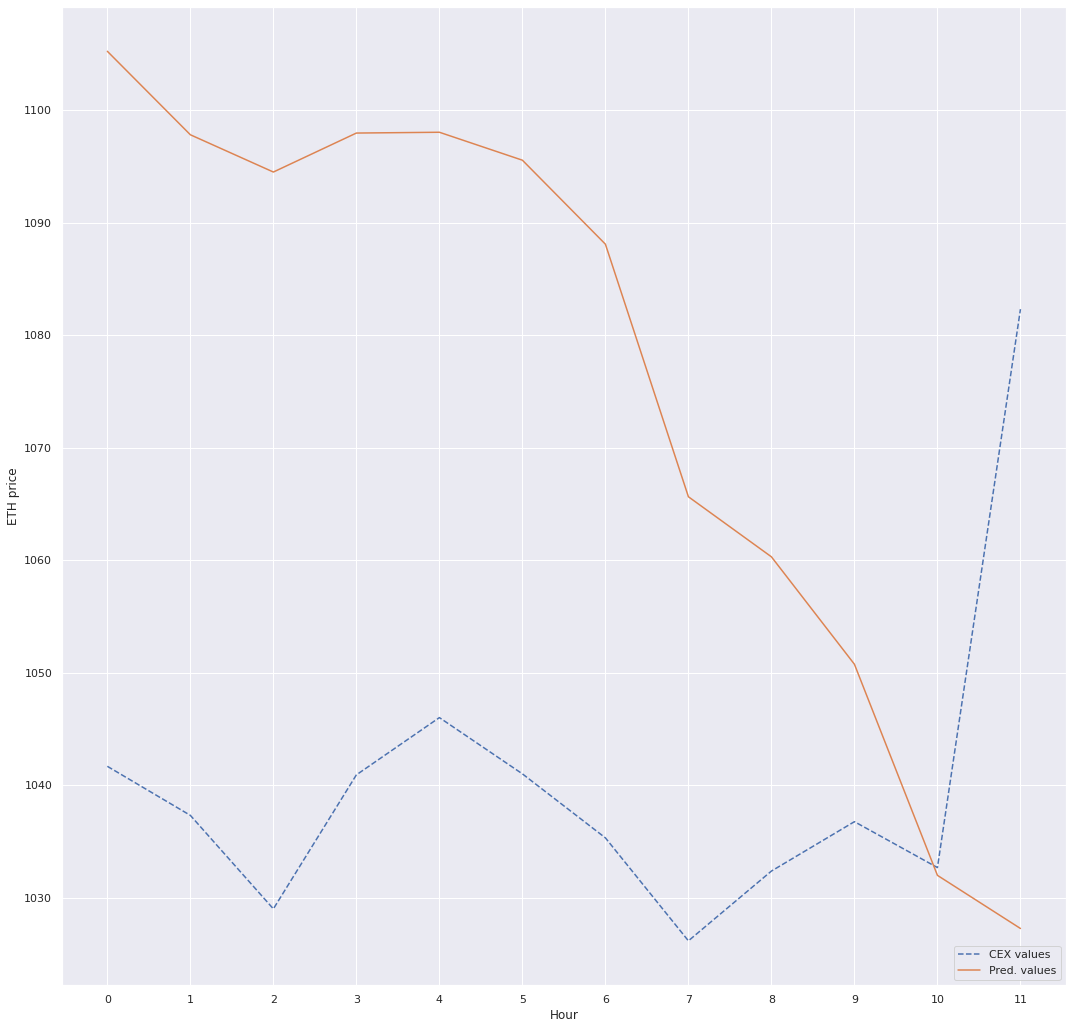

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/97n_vlcb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/x6mhcsc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51330', 'data', 'file=/tmp/tmpmu0vbl24/97n_vlcb.json', 'init=/tmp/tmpmu0vbl24/x6mhcsc4.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelux0trveh/prophet_model-20221212034929.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:29 - cmdstanpy - IN

2


03:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 7.322509610401012e-05


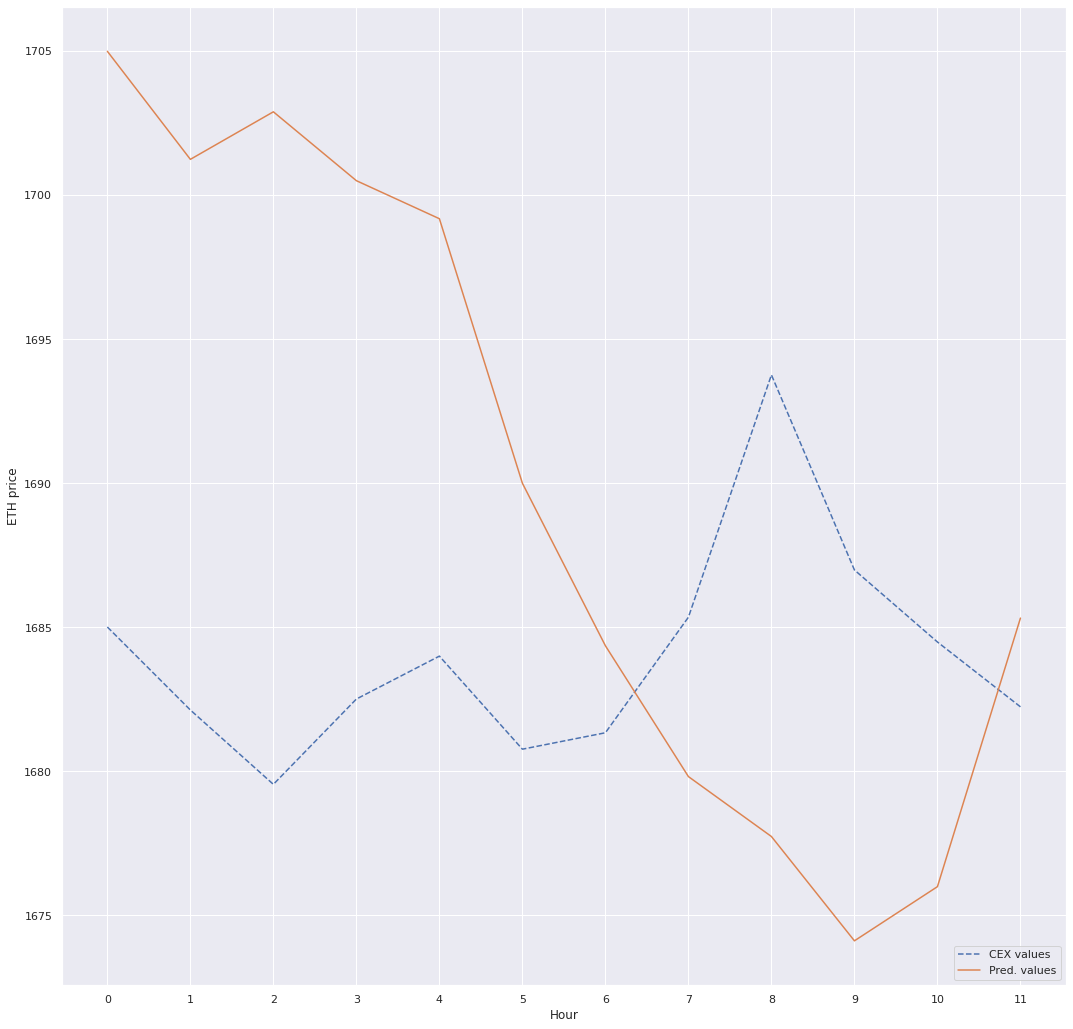

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/3nbi8ziq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/o6u_c743.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34494', 'data', 'file=/tmp/tmpmu0vbl24/3nbi8ziq.json', 'init=/tmp/tmpmu0vbl24/o6u_c743.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model6ptr7icg/prophet_model-20221212034930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:30 - cmdstanpy - IN

3


03:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 8.088392380458427e-05


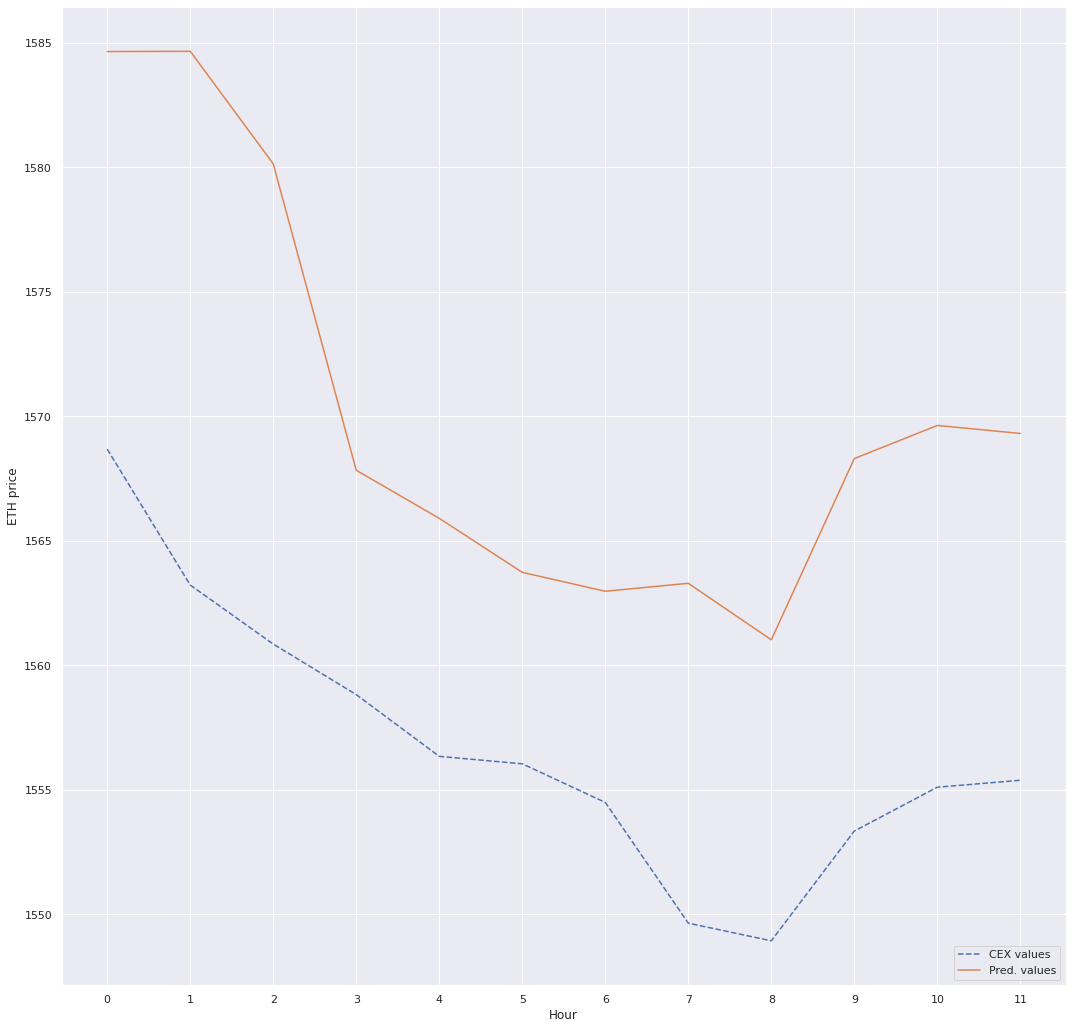

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/nt6ue2ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/h_e48cpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77428', 'data', 'file=/tmp/tmpmu0vbl24/nt6ue2ro.json', 'init=/tmp/tmpmu0vbl24/h_e48cpy.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_12ehobs/prophet_model-20221212034930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:30 - cmdstanpy - IN

4


03:49:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.988298852168005e-06


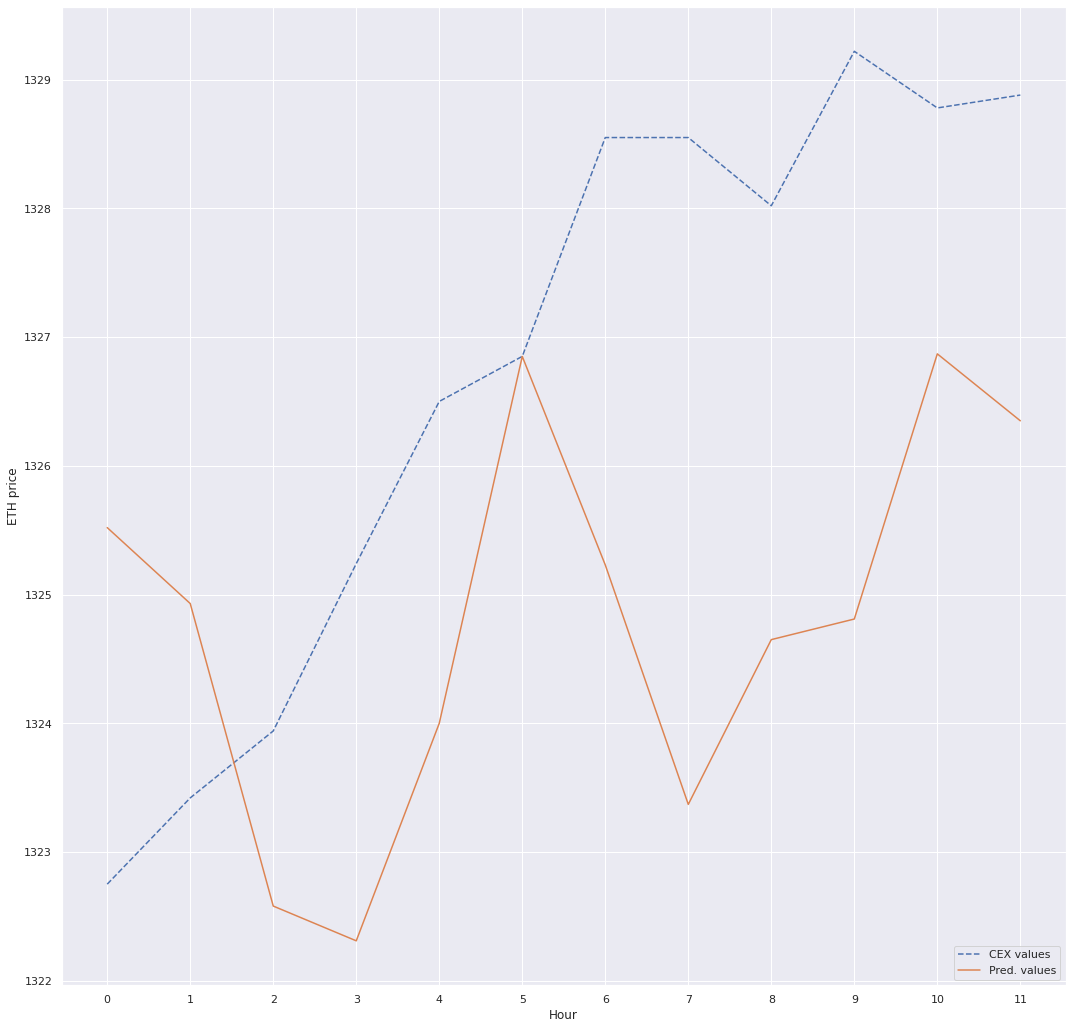

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/k71s8wyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/o487ic1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14474', 'data', 'file=/tmp/tmpmu0vbl24/k71s8wyl.json', 'init=/tmp/tmpmu0vbl24/o487ic1u.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelrkl2grpx/prophet_model-20221212034931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:31 - cmdstanpy - IN

5
NMSE = 1.5380615095318943e-05


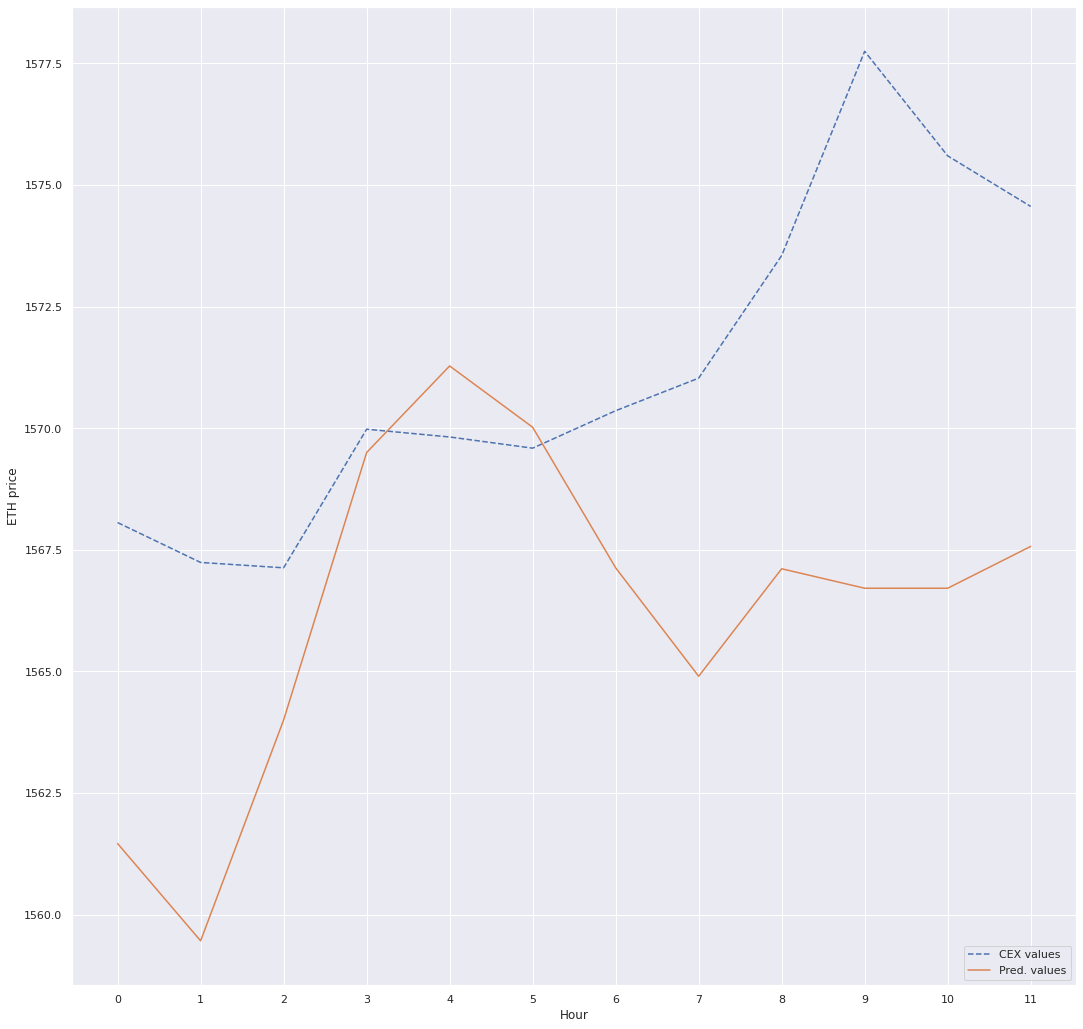

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kj5yk8f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kfit8o4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61887', 'data', 'file=/tmp/tmpmu0vbl24/kj5yk8f_.json', 'init=/tmp/tmpmu0vbl24/kfit8o4y.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model6vailcb0/prophet_model-20221212034931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:31 - cmdstanpy - IN

6


03:49:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 3.4881888518597646e-05


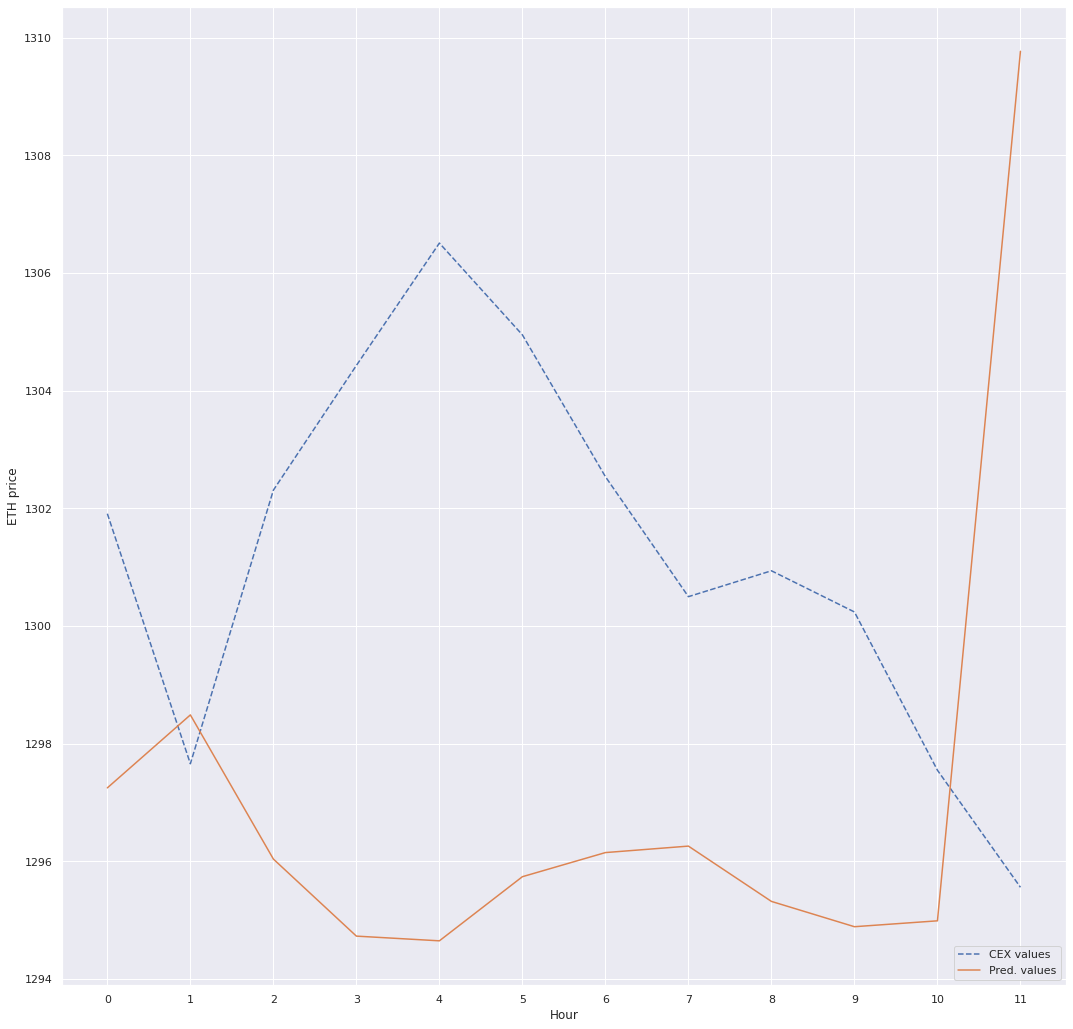

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/gygeqxc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/h3r110gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63116', 'data', 'file=/tmp/tmpmu0vbl24/gygeqxc_.json', 'init=/tmp/tmpmu0vbl24/h3r110gr.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelidrc1eu4/prophet_model-20221212034932.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:32 - cmdstanpy - IN

7


03:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.705873761052534e-06


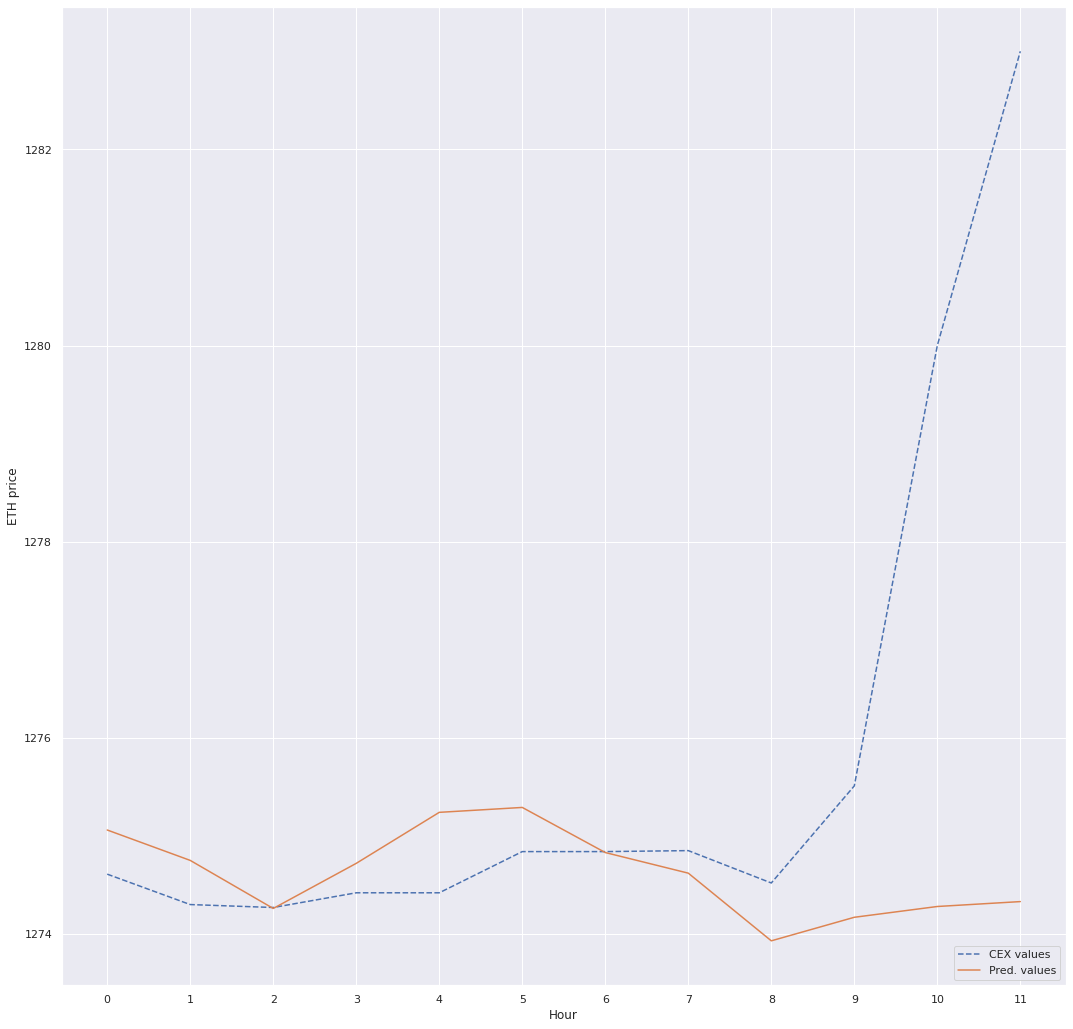

mean months nsme: 0.0003378024965160294


In [269]:
num_weeks = 1# 5 results in overfit
last_x_hours = 12
start_hour = math.ceil(24 * 7 * num_weeks) # this value doesn't matter too much

NSME_list = []

for i in range(len(ochlv_months)-15, len(ochlv_months)):
    print(i)
    w = ochlv_months[i] 
#     print(w)
    last_x_hours = 12
    
    
    train_data = w.iloc[-last_x_hours-24:-last_x_hours,:]
    test_data = w.iloc[-last_x_hours:,:]
    model= Prophet()
    model.add_regressor('open')
    model.add_regressor('high')
    model.add_regressor('low')
    model.add_regressor('volume')
    model.fit(train_data)
    #Predict ETH values over the range of the test set
    forecast = model.predict(train_data)
    pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()
    # now, we have predicted and actual values. Let's find error, and plot!
    cex_vals = test_data.y
    nmse = calc_nmse(cex_vals, pred_vals_test)
    print(f"NMSE = {nmse}")
    NSME_list.append(nmse)
    plot_prices(cex_vals, pred_vals_test,last_x_hours)
    
print("=" * 10)
print(f"mean months nsme: {np.mean(NSME_list)}")

# Try auto arima

In [134]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:000m eta 0:00:010:01
  Using cached Cython-0.29.32-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)


In [140]:
train_data.columns

Index(['ds', 'y'], dtype='object')

In [31]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

auto_arima_model = pm.auto_arima(train_data['y'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2822.526, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14395.668, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2813.829, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2809.876, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2798.053, Time=0.38 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3795.262, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2802.959, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2801.681, Time=0.45 sec
 

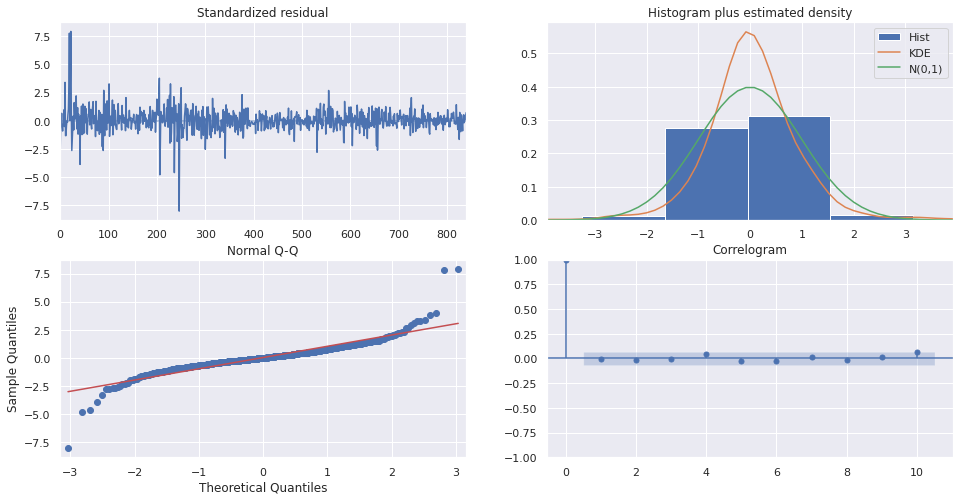

In [32]:


auto_arima_model.plot_diagnostics(figsize=(16,8))
plt.show()





So how to interpret the plot diagnostics?

    Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

    Top Right: The density plot suggest normal distribution with mean zero.

    Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

    Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.



In [41]:
test_data['y']

47990    1272.57
47991    1271.52
47992    1271.76
47993    1272.81
47994    1273.18
47995    1273.69
47996    1273.26
47997    1272.81
47998    1272.59
47999    1273.89
48000    1273.89
48001    1273.73
Name: y, dtype: float64

In [38]:
aa_predictions

47990    1272.661873
47991    1272.568219
47992    1272.628699
47993    1272.597306
47994    1272.566429
47995    1272.536059
47996    1272.506187
47997    1272.476806
47998    1272.447908
47999    1272.419484
48000    1272.391527
48001    1272.364029
dtype: float64

In [37]:
aa_predictions = auto_arima_model.predict(12)

NMSE = 5.445084325862161e-07


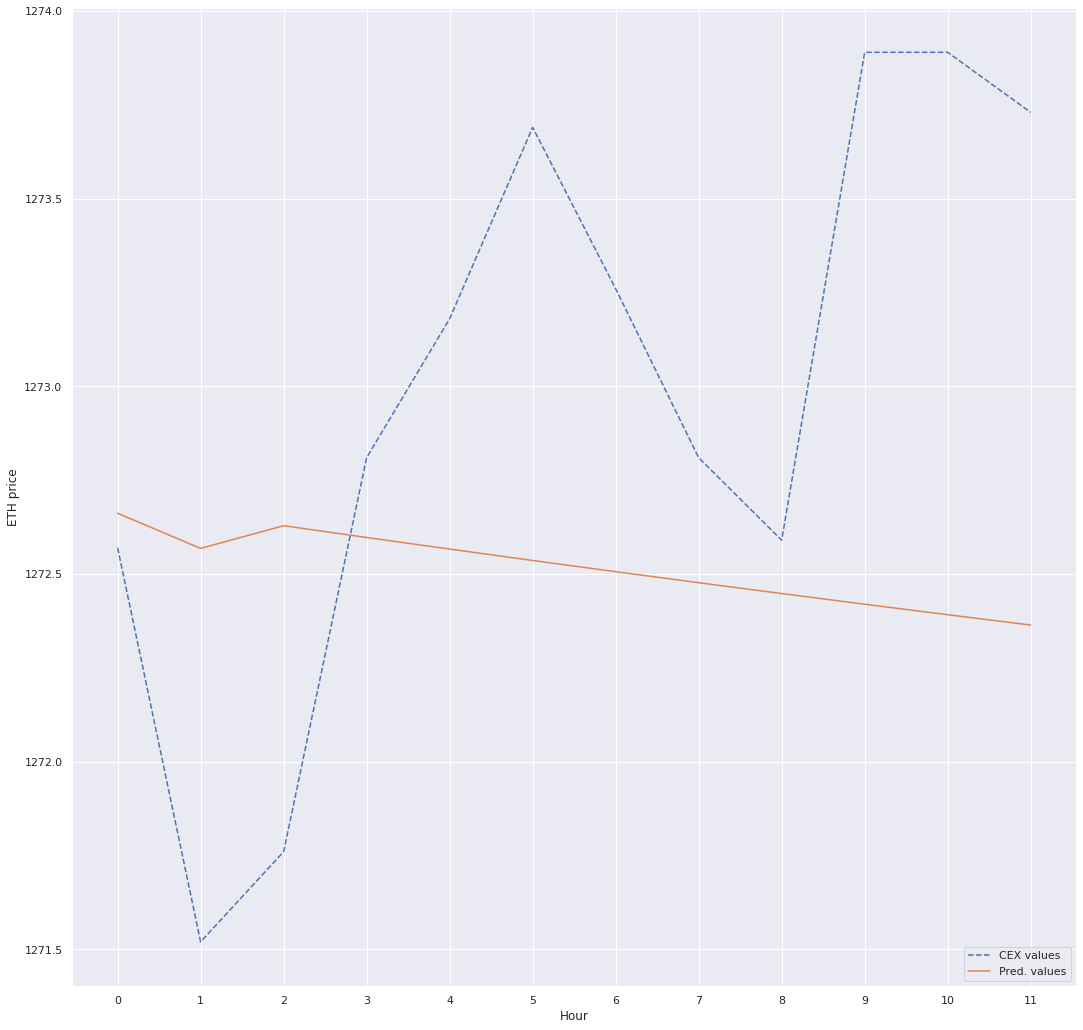

In [42]:
cex_vals = test_data.y
nmse = calc_nmse(cex_vals, aa_predictions)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, aa_predictions,last_x_hours)

## LIGHTGBM

In [189]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00m eta 0:00:010:01:01


In [271]:
#ref https://www.kaggle.com/code/sugghi/training-3rd-place-solution
import lightgbm as lgb

In [272]:
lags = [60,300,900]

In [289]:

seed0 = 8586

params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
         }



In [276]:
ochlv_data.columns

Index(['ds', 'open', 'y', 'high', 'low', 'volume'], dtype='object')

In [277]:
def lgb_get_features(df):   
    close_col = 'y'
    for lag in lags:
        df[f'log_close/mean_{lag}'] = np.log( np.array(df[close_col]) /  np.roll(np.append(np.convolve( np.array(df[close_col]), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
        df[f'log_return_{lag}']     = np.log( np.array(df[close_col]) /  np.roll(np.array(df[close_col]), lag)  )
    return df

In [279]:
ochlv_data_lgb = lgb_get_features(ochlv_data)
ochlv_data_lgb.head()

ds     open        y     high      low      volume  \
0 2022-05-21 00:00:00  1959.08  1973.95  1956.14  1963.41  14232.7649   
1 2022-05-21 01:00:00  1963.41  1965.41  1937.36  1951.93  19711.0810   
2 2022-05-21 02:00:00  1951.92  1962.57  1944.29  1959.40   8416.9029   
3 2022-05-21 03:00:00  1959.39  1969.95  1949.66  1967.75   9089.2800   
4 2022-05-21 04:00:00  1967.74  1969.43  1962.00  1965.17   6704.3441   

   log_close/mean_60  log_return_60  log_close/mean_300  log_return_300  \
0           7.587792       0.439336            7.587792        0.440421   
1           7.583456       0.435079            7.583456        0.435740   
2           7.582010       0.434270            7.582010        0.434435   
3           7.585763       0.438377            7.585763        0.437245   
4           7.585499       0.437610            7.585499        0.437445   

   log_close/mean_900  log_return_900  
0            7.587792        0.454496  
1            7.583456        0.450352  
2            7.582010        0.450671  
3            7.585763        0.452994  
4            7.585499        0.452890

In [302]:
not_use_features_train = ['ds', 'y']
features = list(ochlv_data_lgb.columns.drop(not_use_features_train))

In [303]:
features

['open',
 'high',
 'low',
 'volume',
 'log_close/mean_60',
 'log_return_60',
 'log_close/mean_300',
 'log_return_300',
 'log_close/mean_900',
 'log_return_900']

In [283]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [285]:
n_fold = 7

# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['ds'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip



doing split 1 out of 7
                      ds     open        y     high      low      volume  \
0    2022-05-21 00:00:00  1959.08  1973.95  1956.14  1963.41  14232.7649   
1    2022-05-21 01:00:00  1963.41  1965.41  1937.36  1951.93  19711.0810   
2    2022-05-21 02:00:00  1951.92  1962.57  1944.29  1959.40   8416.9029   
3    2022-05-21 03:00:00  1959.39  1969.95  1949.66  1967.75   9089.2800   
4    2022-05-21 04:00:00  1967.74  1969.43  1962.00  1965.17   6704.3441   
...                  ...      ...      ...      ...      ...         ...   
6857 2022-07-21 22:40:00  1575.40  1575.73  1570.54  1571.64   1745.8850   
6858 2022-07-21 22:45:00  1571.64  1578.28  1570.90  1572.62   2287.8331   
6859 2022-07-21 22:50:00  1572.63  1573.62  1568.67  1573.39   2423.6606   
6860 2022-07-21 22:55:00  1573.39  1579.38  1572.37  1575.98   2853.5614   
6861 2022-07-21 23:00:00  1575.98  1580.59  1574.18  1579.76   1882.0919   

      log_close/mean_60  log_return_60  log_close/mean_300  log_

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 21.8202	valid_1's rmse: 66.7188
[200]	training's rmse: 8.98516	valid_1's rmse: 44.7912
[300]	training's rmse: 5.98536	valid_1's rmse: 38.8569
[400]	training's rmse: 4.9189	valid_1's rmse: 35.5462
[500]	training's rmse: 4.29626	valid_1's rmse: 33.8247
[600]	training's rmse: 3.90368	valid_1's rmse: 33.0306
[700]	training's rmse: 3.65395	valid_1's rmse: 32.4666
[800]	training's rmse: 3.45064	valid_1's rmse: 31.953
[900]	training's rmse: 3.31961	valid_1's rmse: 31.507
[1000]	training's rmse: 3.21341	valid_1's rmse: 31.0054
[1100]	training's rmse: 3.12826	valid_1's rmse: 30.5161
[1200]	training's rmse: 3.05865	valid_1's rmse: 30.2002
[1300]	training's rmse: 3.00079	valid_1's rmse: 29.9571
[1400]	training's rmse: 2.94711	valid_1's rmse: 29.6459
[1500]	training's rmse: 2.89909	valid_1's rmse: 29.4128
[1600]	training's rmse: 2.85674	valid_1's rmse: 29.154
[1700]	training's rmse: 2.82123	valid_1's rmse: 28.9733
[1800]	training's rmse: 2.78187	valid_1's rmse: 28.8757
[1900

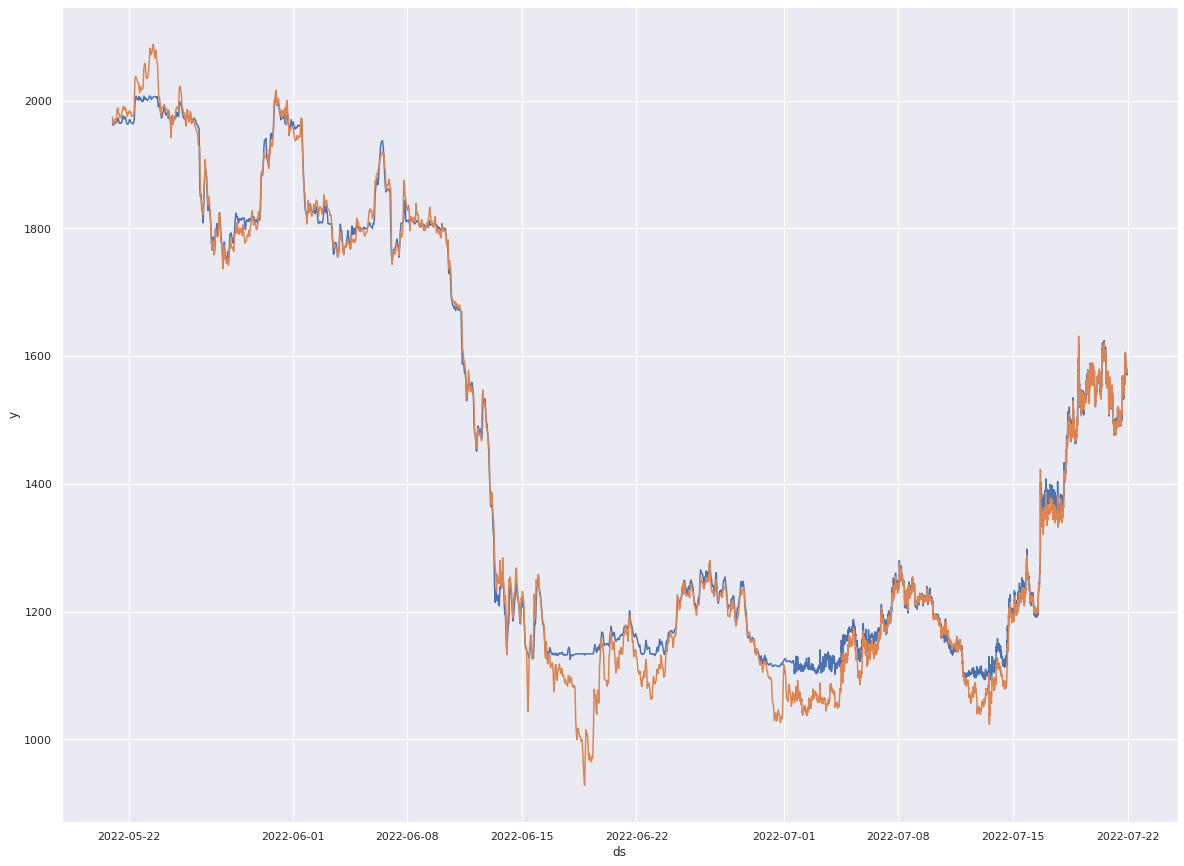

doing split 2 out of 7
                      ds     open        y     high      low      volume  \
0    2022-07-21 23:05:00  1579.76  1582.00  1575.64  1577.46   2241.2322   
1    2022-07-21 23:10:00  1577.46  1585.88  1577.44  1580.65   4813.5298   
2    2022-07-21 23:15:00  1580.65  1582.96  1580.34  1582.58   1602.9947   
3    2022-07-21 23:20:00  1582.58  1584.94  1580.65  1582.54   2083.9942   
4    2022-07-21 23:25:00  1582.53  1588.99  1582.53  1584.88   2760.8988   
...                  ...      ...      ...      ...      ...         ...   
6858 2022-08-14 18:00:00  1922.43  1925.44  1906.00  1911.88  12176.4983   
6859 2022-08-14 18:05:00  1911.92  1923.25  1910.30  1921.73   5012.5784   
6860 2022-08-14 18:10:00  1921.73  1923.48  1918.71  1919.28   1722.9775   
6861 2022-08-14 18:15:00  1919.28  1922.58  1917.04  1919.54   2002.5400   
6862 2022-08-14 18:20:00  1919.55  1923.29  1919.54  1921.70   1976.5536   

      log_close/mean_60  log_return_60  log_close/mean_300  log_

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 22.1709	valid_1's rmse: 71.4554
[200]	training's rmse: 9.96442	valid_1's rmse: 45.6633
[300]	training's rmse: 7.35961	valid_1's rmse: 34.9867
[400]	training's rmse: 6.17625	valid_1's rmse: 29.836
[500]	training's rmse: 5.51649	valid_1's rmse: 26.9387
[600]	training's rmse: 5.09979	valid_1's rmse: 25.2867
[700]	training's rmse: 4.78525	valid_1's rmse: 24.2089
[800]	training's rmse: 4.56482	valid_1's rmse: 23.2485
[900]	training's rmse: 4.37754	valid_1's rmse: 22.6319
[1000]	training's rmse: 4.23789	valid_1's rmse: 22.2232
[1100]	training's rmse: 4.11764	valid_1's rmse: 21.8902
[1200]	training's rmse: 4.00312	valid_1's rmse: 21.5345
[1300]	training's rmse: 3.90033	valid_1's rmse: 21.1799
[1400]	training's rmse: 3.81495	valid_1's rmse: 21.0088
[1500]	training's rmse: 3.73023	valid_1's rmse: 20.7305
[1600]	training's rmse: 3.67237	valid_1's rmse: 20.6239
[1700]	training's rmse: 3.61589	valid_1's rmse: 20.5217
[1800]	training's rmse: 3.55572	valid_1's rmse: 20.3667
[1

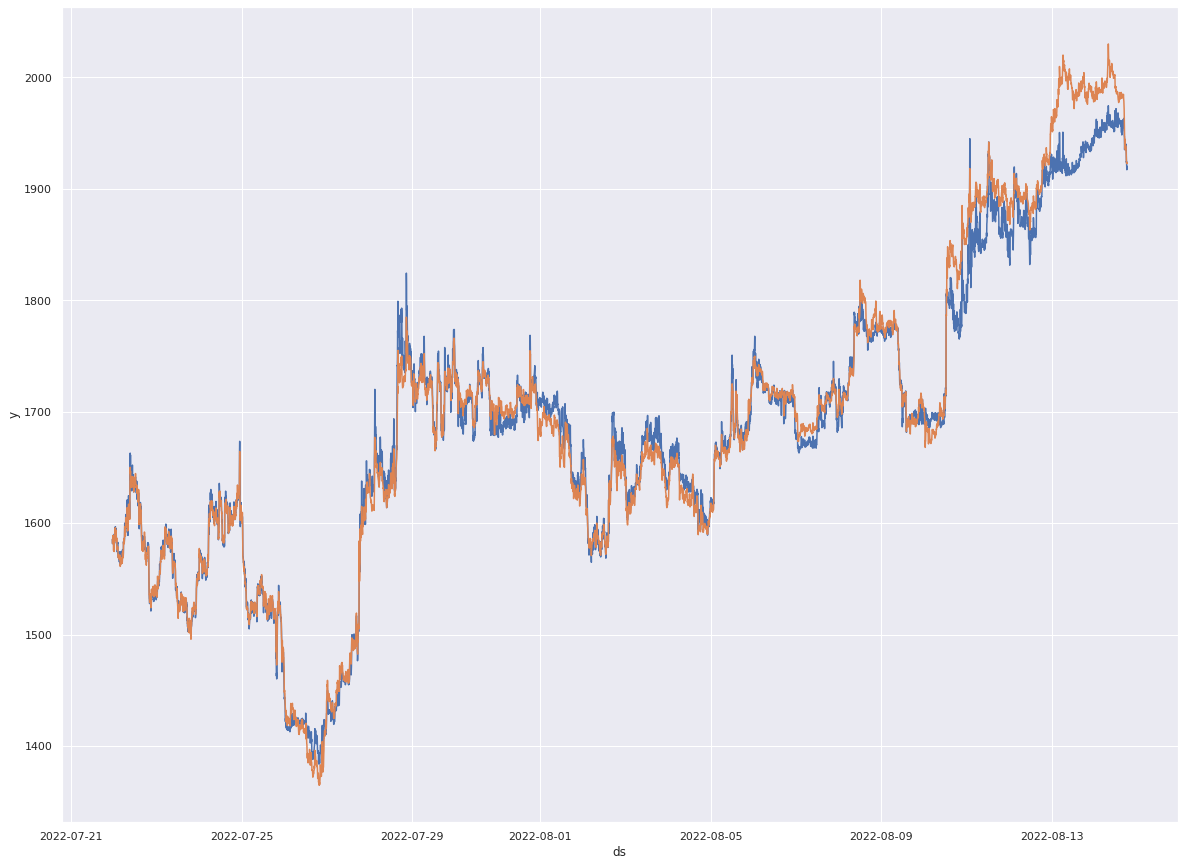

doing split 3 out of 7
                      ds     open        y     high      low     volume  \
0    2022-08-14 18:25:00  1921.70  1928.29  1921.69  1927.32  2386.3900   
1    2022-08-14 18:30:00  1927.32  1929.67  1926.02  1927.84  3024.4934   
2    2022-08-14 18:35:00  1927.84  1932.45  1926.72  1930.10  2345.0739   
3    2022-08-14 18:40:00  1930.10  1931.59  1927.71  1928.18  1490.3080   
4    2022-08-14 18:45:00  1928.18  1930.54  1927.23  1928.47   715.1761   
...                  ...      ...      ...      ...      ...        ...   
6858 2022-09-07 13:20:00  1531.83  1538.16  1531.49  1535.62  3654.4980   
6859 2022-09-07 13:25:00  1535.62  1537.00  1531.95  1532.84  3681.4878   
6860 2022-09-07 13:30:00  1532.84  1542.95  1532.15  1542.49  6201.8483   
6861 2022-09-07 13:35:00  1542.50  1547.70  1541.50  1545.28  7057.4849   
6862 2022-09-07 13:40:00  1545.27  1550.00  1540.07  1543.08  5737.6461   

      log_close/mean_60  log_return_60  log_close/mean_300  log_return_300  

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 22.3215	valid_1's rmse: 54.0038
[200]	training's rmse: 10.3232	valid_1's rmse: 30.511
[300]	training's rmse: 7.19983	valid_1's rmse: 22.5385
[400]	training's rmse: 5.76711	valid_1's rmse: 19.7752
[500]	training's rmse: 5.12434	valid_1's rmse: 18.75
[600]	training's rmse: 4.7526	valid_1's rmse: 17.843
[700]	training's rmse: 4.47533	valid_1's rmse: 17.1629
[800]	training's rmse: 4.2715	valid_1's rmse: 16.8218
[900]	training's rmse: 4.11095	valid_1's rmse: 16.3669
[1000]	training's rmse: 3.97661	valid_1's rmse: 16.0052
[1100]	training's rmse: 3.88108	valid_1's rmse: 15.8622
[1200]	training's rmse: 3.78867	valid_1's rmse: 15.5832
[1300]	training's rmse: 3.70918	valid_1's rmse: 15.4249
[1400]	training's rmse: 3.64151	valid_1's rmse: 15.2853
[1500]	training's rmse: 3.58097	valid_1's rmse: 15.1787
[1600]	training's rmse: 3.52556	valid_1's rmse: 15.0027
[1700]	training's rmse: 3.47643	valid_1's rmse: 14.9216
[1800]	training's rmse: 3.42698	valid_1's rmse: 14.8023
[1900]	

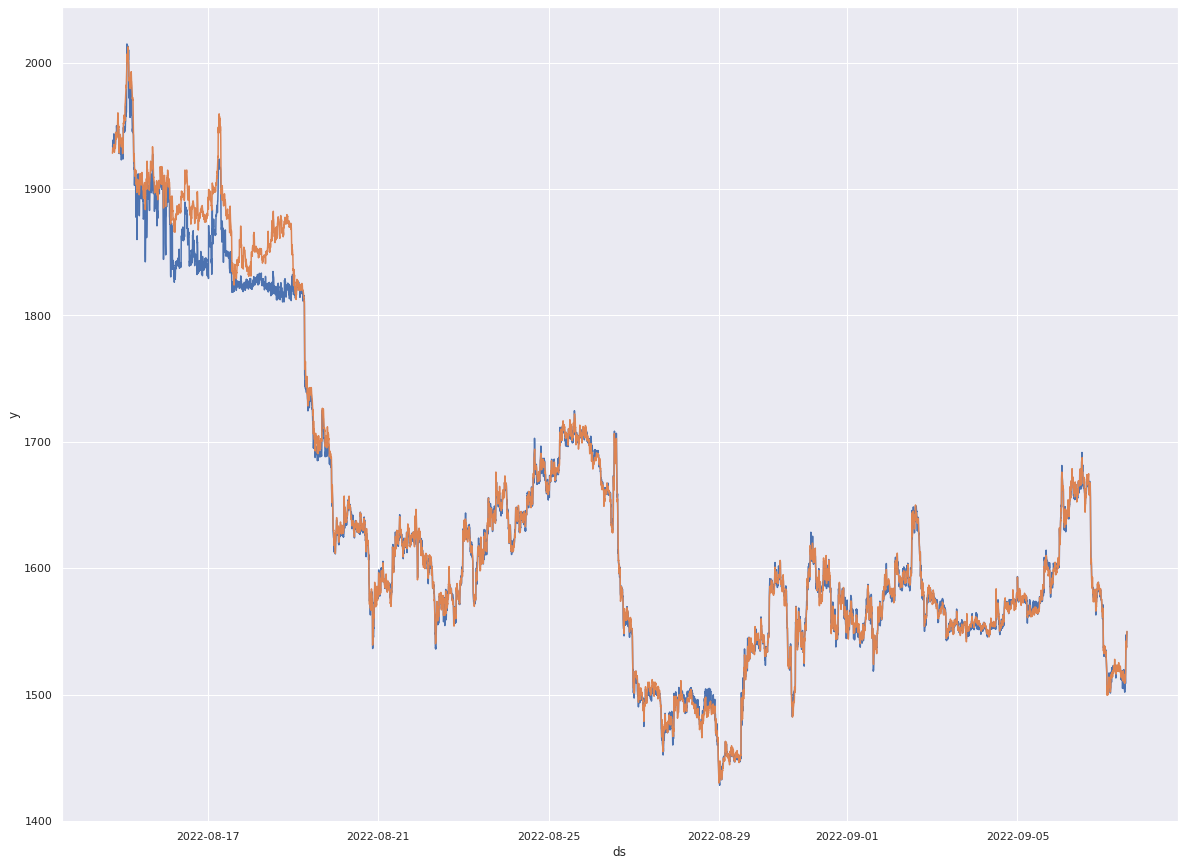

doing split 4 out of 7
                      ds     open        y     high      low     volume  \
0    2022-09-07 13:45:00  1543.07  1546.42  1539.71  1543.25  3278.7542   
1    2022-09-07 13:50:00  1543.26  1544.10  1537.17  1538.48  3326.2627   
2    2022-09-07 13:55:00  1538.48  1542.42  1536.06  1536.14  2629.0124   
3    2022-09-07 14:00:00  1536.14  1539.48  1532.72  1539.01  5335.6661   
4    2022-09-07 14:05:00  1539.02  1543.07  1537.77  1539.02  2133.7475   
...                  ...      ...      ...      ...      ...        ...   
6858 2022-10-01 08:40:00  1331.46  1332.58  1331.11  1332.16   617.0932   
6859 2022-10-01 08:45:00  1332.16  1332.38  1331.69  1331.70   376.0794   
6860 2022-10-01 08:50:00  1331.69  1332.43  1331.69  1331.88   349.0673   
6861 2022-10-01 08:55:00  1331.89  1331.89  1330.90  1331.62   467.6640   
6862 2022-10-01 09:00:00  1331.61  1332.54  1331.61  1332.43   455.5883   

      log_close/mean_60  log_return_60  log_close/mean_300  log_return_300  

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 22.7197	valid_1's rmse: 14.1741
Early stopping, best iteration is:
[106]	training's rmse: 20.7164	valid_1's rmse: 13.8681
Evaluated only: rmse
Trained model was saved to 'trained_model_fold3.pkl'



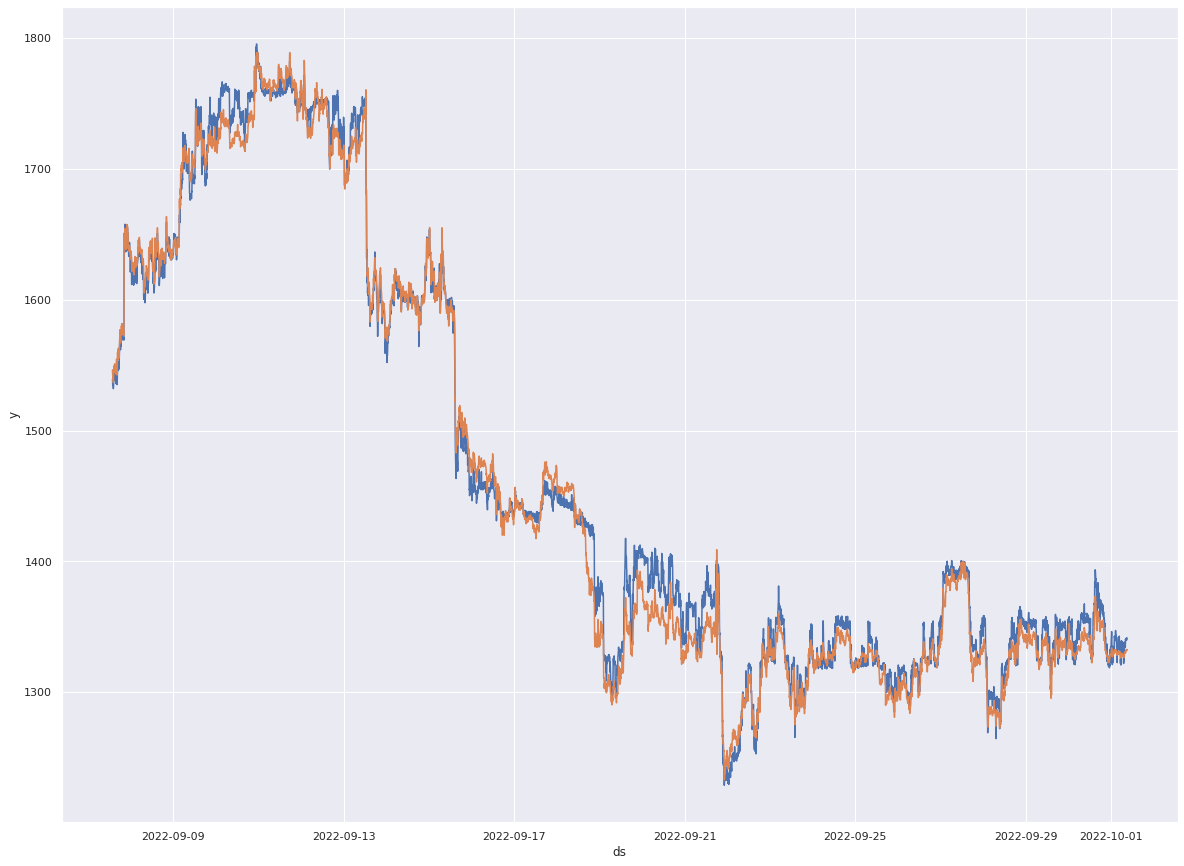

doing split 5 out of 7
                      ds     open        y     high      low     volume  \
0    2022-10-01 09:05:00  1332.42  1333.00  1330.98  1330.99  1276.6579   
1    2022-10-01 09:10:00  1330.99  1331.26  1329.50  1330.14  1065.1624   
2    2022-10-01 09:15:00  1330.13  1331.11  1329.89  1330.47   474.1106   
3    2022-10-01 09:20:00  1330.46  1330.97  1330.18  1330.80   367.1497   
4    2022-10-01 09:25:00  1330.79  1330.80  1330.38  1330.53   283.6941   
...                  ...      ...      ...      ...      ...        ...   
6858 2022-10-25 04:00:00  1347.61  1348.47  1347.52  1348.00  1075.6912   
6859 2022-10-25 04:05:00  1348.00  1348.33  1347.65  1348.17   608.7249   
6860 2022-10-25 04:10:00  1348.17  1351.26  1347.21  1347.22  2790.8110   
6861 2022-10-25 04:15:00  1347.23  1347.23  1345.88  1346.63   624.8704   
6862 2022-10-25 04:20:00  1346.64  1346.72  1345.81  1346.00   773.4741   

      log_close/mean_60  log_return_60  log_close/mean_300  log_return_300  

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 22.3802	valid_1's rmse: 13.1068
[200]	training's rmse: 8.99444	valid_1's rmse: 7.26526
[300]	training's rmse: 6.34969	valid_1's rmse: 6.32019
[400]	training's rmse: 5.47692	valid_1's rmse: 5.84915
[500]	training's rmse: 4.98194	valid_1's rmse: 5.59976
[600]	training's rmse: 4.63985	valid_1's rmse: 5.36001
[700]	training's rmse: 4.39199	valid_1's rmse: 5.20084
[800]	training's rmse: 4.19664	valid_1's rmse: 5.00219
[900]	training's rmse: 4.04535	valid_1's rmse: 4.85032
[1000]	training's rmse: 3.9291	valid_1's rmse: 4.71691
[1100]	training's rmse: 3.81768	valid_1's rmse: 4.61707
[1200]	training's rmse: 3.71298	valid_1's rmse: 4.40648
[1300]	training's rmse: 3.63206	valid_1's rmse: 4.2679
[1400]	training's rmse: 3.55827	valid_1's rmse: 4.15244
[1500]	training's rmse: 3.49122	valid_1's rmse: 4.04778
[1600]	training's rmse: 3.43759	valid_1's rmse: 3.97575
[1700]	training's rmse: 3.38722	valid_1's rmse: 3.92451
[1800]	training's rmse: 3.34251	valid_1's rmse: 3.88389
[19

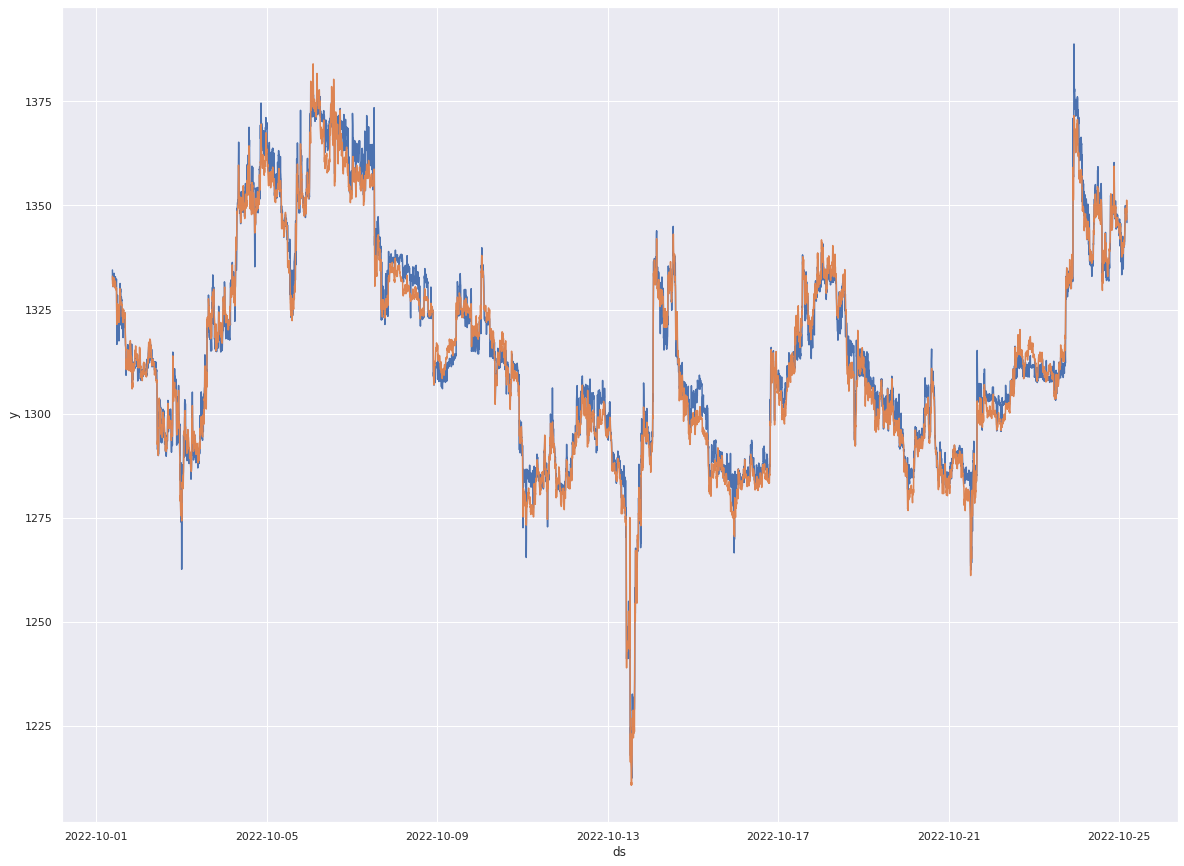

doing split 6 out of 7
                      ds     open        y     high      low     volume  \
0    2022-10-25 04:25:00  1346.00  1346.30  1345.59  1345.69   365.9742   
1    2022-10-25 04:30:00  1345.69  1346.68  1345.58  1346.22   496.6516   
2    2022-10-25 04:35:00  1346.22  1346.22  1345.17  1345.17   483.3256   
3    2022-10-25 04:40:00  1345.18  1346.58  1345.17  1346.24   546.2625   
4    2022-10-25 04:45:00  1346.25  1346.55  1346.24  1346.51   135.5818   
...                  ...      ...      ...      ...      ...        ...   
6858 2022-11-17 23:20:00  1201.48  1202.50  1200.80  1200.85  1852.9888   
6859 2022-11-17 23:25:00  1200.84  1201.50  1200.78  1201.49   946.6570   
6860 2022-11-17 23:30:00  1201.49  1202.00  1200.95  1201.21  1208.1230   
6861 2022-11-17 23:35:00  1201.20  1201.21  1196.27  1199.11  3608.3512   
6862 2022-11-17 23:40:00  1199.10  1201.67  1197.62  1201.55  1839.2682   

      log_close/mean_60  log_return_60  log_close/mean_300  log_return_300  

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 21.7659	valid_1's rmse: 12.8644
Early stopping, best iteration is:
[97]	training's rmse: 22.959	valid_1's rmse: 12.776
Evaluated only: rmse
Trained model was saved to 'trained_model_fold5.pkl'



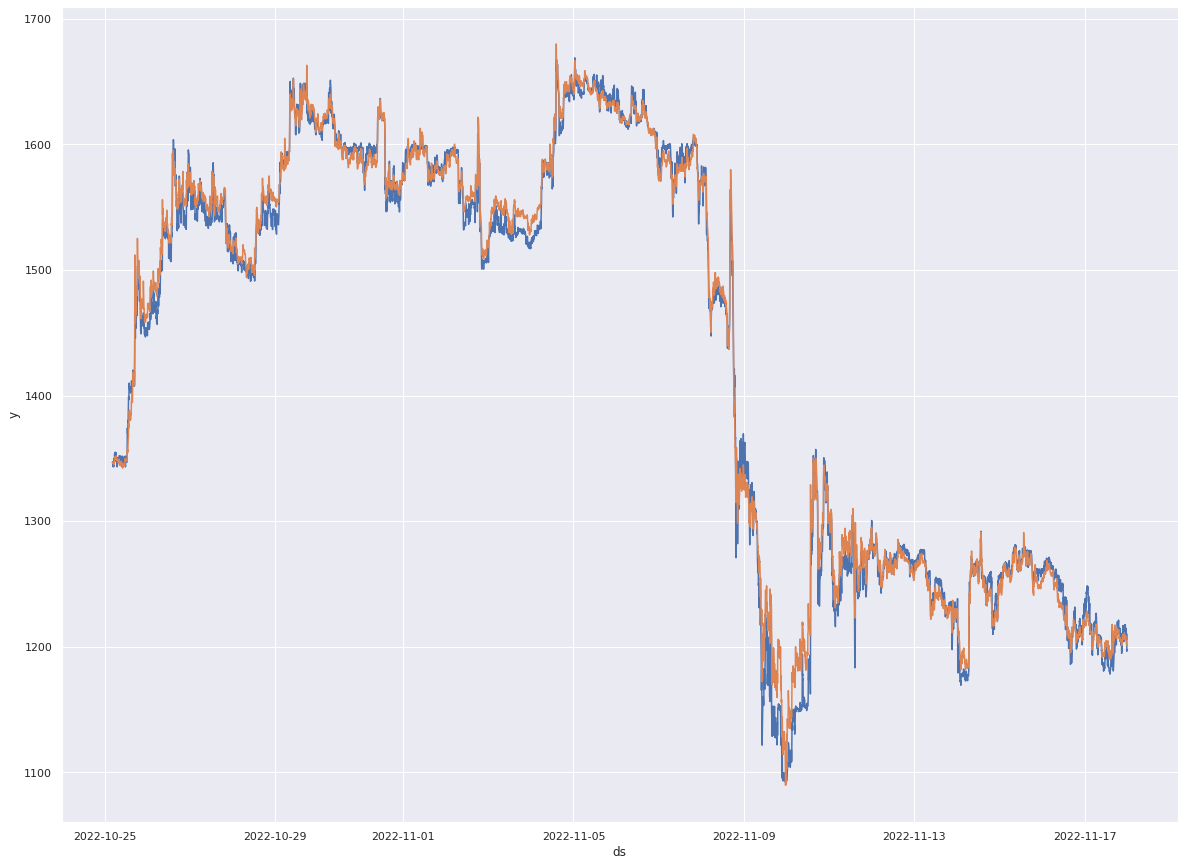

doing split 7 out of 7
                      ds     open        y     high      low     volume  \
0    2022-11-17 23:45:00  1201.54  1201.64  1200.00  1200.76   609.8606   
1    2022-11-17 23:50:00  1200.77  1200.77  1199.10  1199.54   461.5411   
2    2022-11-17 23:55:00  1199.55  1201.37  1199.54  1200.43   793.7443   
3    2022-11-18 00:00:00  1200.42  1202.99  1199.18  1202.73  1525.3378   
4    2022-11-18 00:05:00  1202.73  1203.25  1201.69  1203.16  1593.5736   
...                  ...      ...      ...      ...      ...        ...   
6858 2022-12-11 18:40:00  1274.78  1274.85  1274.51  1274.51   295.2495   
6859 2022-12-11 18:45:00  1274.52  1274.52  1274.25  1274.46   364.2896   
6860 2022-12-11 18:50:00  1274.46  1275.51  1273.80  1275.32   776.2476   
6861 2022-12-11 18:55:00  1275.32  1280.00  1275.15  1279.49  5382.4815   
6862 2022-12-11 19:00:00  1279.48  1283.00  1279.35  1281.93  4002.4441   

      log_close/mean_60  log_return_60  log_close/mean_300  log_return_300  

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 22.1238	valid_1's rmse: 18.6678
[200]	training's rmse: 8.54717	valid_1's rmse: 7.22907
[300]	training's rmse: 6.15019	valid_1's rmse: 6.46024
[400]	training's rmse: 5.36988	valid_1's rmse: 6.14043
[500]	training's rmse: 4.90378	valid_1's rmse: 5.81993
[600]	training's rmse: 4.58848	valid_1's rmse: 5.59068
[700]	training's rmse: 4.34772	valid_1's rmse: 5.40096
[800]	training's rmse: 4.14376	valid_1's rmse: 5.22169
[900]	training's rmse: 4.00103	valid_1's rmse: 5.1135
[1000]	training's rmse: 3.87417	valid_1's rmse: 4.95806
[1100]	training's rmse: 3.77341	valid_1's rmse: 4.84553
[1200]	training's rmse: 3.68301	valid_1's rmse: 4.7443
[1300]	training's rmse: 3.60832	valid_1's rmse: 4.66025
[1400]	training's rmse: 3.53979	valid_1's rmse: 4.58454
[1500]	training's rmse: 3.48097	valid_1's rmse: 4.51946
[1600]	training's rmse: 3.42422	valid_1's rmse: 4.45564
[1700]	training's rmse: 3.37395	valid_1's rmse: 4.39491
[1800]	training's rmse: 3.3303	valid_1's rmse: 4.34065
[190

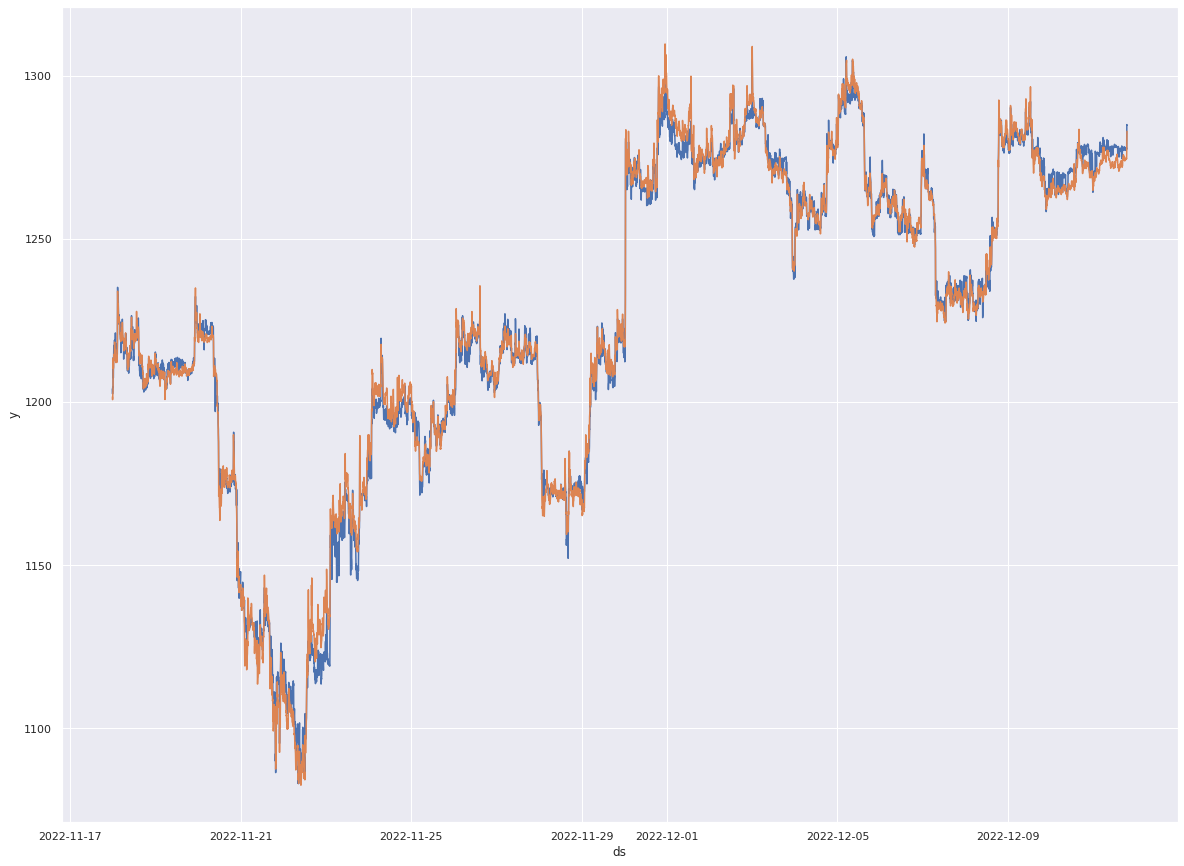

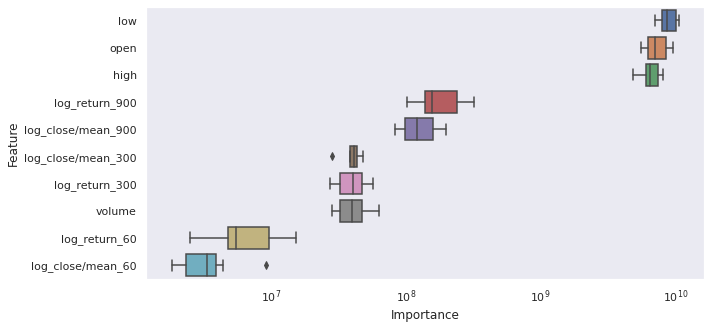

In [318]:
# EmbargoCV
df_proc = ochlv_data_lgb
target_col = 'y'
train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)

importances = []
oof_pred = []
oof_valid = [] 

for split, train_test_split in enumerate(train_test_zip):
    gc.collect()

    print(f"doing split {split+1} out of {n_fold}")
    train_split, test_split = train_test_split
    train_split_index = df_proc['ds'].isin(train_split)
    test_split_index = df_proc['ds'].isin(test_split)
    actual = df_proc.loc[test_split_index].reset_index(drop = True)
    print(actual)

    train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                df_proc.loc[train_split_index, target_col].values, 
                                feature_name = features, 
                               )
    val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                              df_proc.loc[test_split_index, target_col].values, 
                              feature_name = features, 
                             )
    
    print(f"number of train data: {len(df_proc.loc[train_split_index])}")
    print(f"number of val data:   {len(df_proc.loc[test_split_index])}")
#     print(df_proc.loc[test_split_index])
    model = lgb.train(params = params,
                      train_set = train_dataset, 
                      valid_sets=[train_dataset, val_dataset],
#                       valid_names=['tr', 'vl'],
                      num_boost_round = 5000,
                      verbose_eval = 100,   
                     )
    importances.append(model.feature_importance(importance_type='gain'))

    file = f'trained_model_fold{split}.pkl'
    pickle.dump(model, open(file, 'wb'))
    print(f"Trained model was saved to 'trained_model_fold{split}.pkl'")
    print("")
    fig, ax = plt.subplots(1,1,figsize=(20,15))
    
    prediction = model.predict(df_proc.loc[test_split_index, features]) 
    predict_df = pd.DataFrame(data={
        'ds': actual["ds"],
        'y':prediction
    })
    sns.lineplot(data=predict_df, x="ds", y='y', ax=ax)
    sns.lineplot(data=actual, x="ds", y='y',ax=ax)
    plt.show()
    
    oof_pred += list( prediction )
    oof_valid += list(   df_proc.loc[test_split_index, target_col].values    )
    
plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))


<AxesSubplot: >

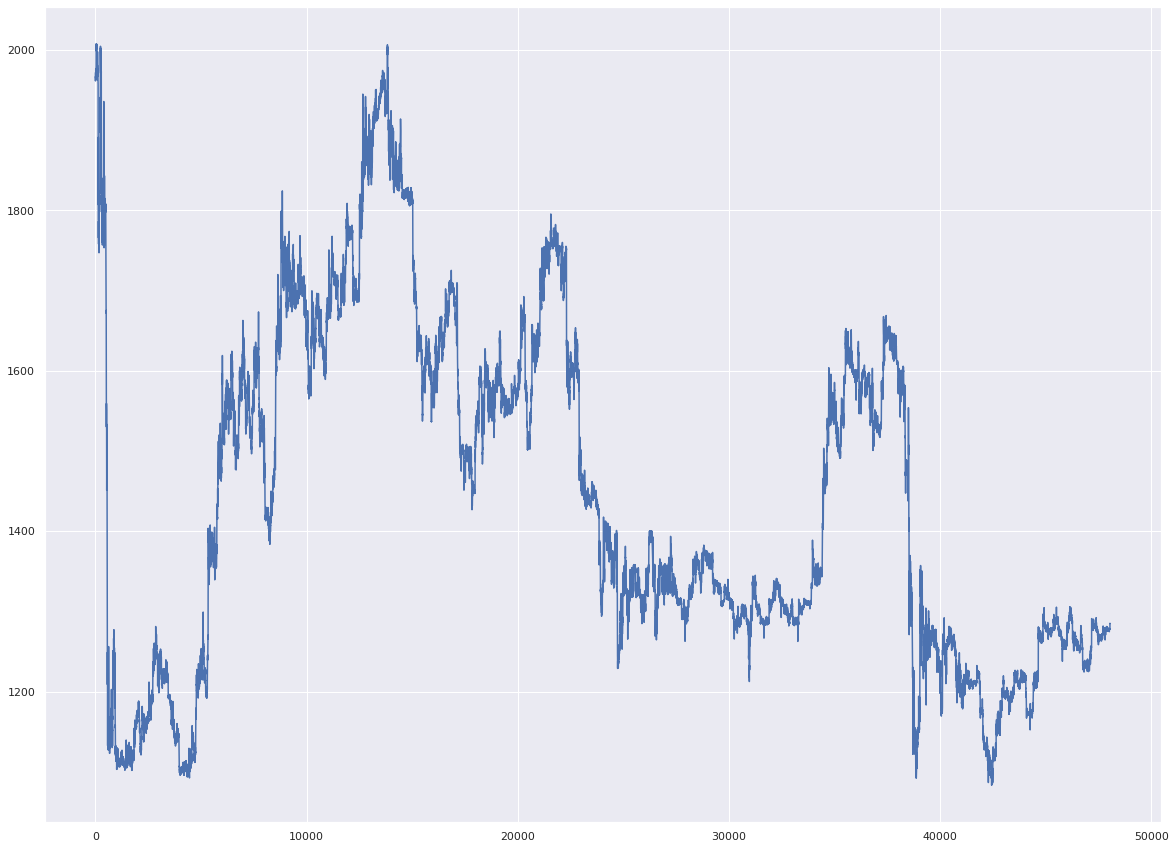

In [307]:

# fig, ax = plt.subplots(1,1,figsize=(20,15))
# w = weeks[i]
# # sns.lineplot(data=w, x="ds",y="y", ax=ax)
# sns.lineplot(data=oof_pred, ax=ax)

In [ ]:
# fit model with all the available data
model =lgb.load(filename = "trained_model_fold6.pkl")
# model.fit(data)

# generate dates for prediction (12 hours ahead of the latest datapoint in the data time)
future_dates = model.make_future_dataframe(periods=12, freq="h", include_history=False)

# predcit eth values on future_dates
forecast = model.predict(future_dates)
pred_vals = forecast.set_index('ds')['yhat'].to_numpy()


In [19]:
file_name = "/tmp/pred_vals.csv"
save_list(pred_vals, file_name)

In [24]:
from pybundlr import pybundlr
file_name = "/tmp/pred_vals.csv"
url = pybundlr.fund_and_upload(file_name, "matic", alice_wallet.private_key)
#e.g. url = "https://arweave.net/qctEbPb3CjvU8LmV3G_mynX74eCxo1domFQIlOBH1xU"
print(f"Your csv url: {url}")

NameError: name 'alice_wallet' is not defined

In [ ]:
name = "ETH predictions " + str(time.time()) #time for unique name
(data_nft, datatoken, asset) = ocean.assets.create_url_asset(name, url, alice_wallet, wait_for_aqua=False)
metadata_state = 5
data_nft.setMetaDataState(metadata_state, {"from":alice_wallet})
print(f"New asset created, with did={asset.did}, and datatoken.address={datatoken.address}")